# Machine Learning Engineer Nanodegree
## Capstone Project - Who Wrote This? 
... or how to use natural languange processing to identify the author of anonymous articles.

Stefan Dittforth  
February 27th, 2018

--------------

## Sources:

[1] ["Who’s At The Keyboard? Authorship Attribution in Digital Evidence Investigations"](www.utica.edu/academic/institutes/ecii/publications/articles/B49F9C4A-0362-765C-6A235CB8ABDFACFF.pdf): good reference regarding number of authors and text volume.

[2] ["How a Computer Program Helped Show J.K. Rowling write A Cuckoo’s Calling"](https://www.scientificamerican.com/article/how-a-computer-program-helped-show-jk-rowling-write-a-cuckoos-calling/): some good ideas for feature to analyse.

[3] [How to solve 90% of NLP problems: a step-by-step guide](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)

## Research Notes:

- add some article screen shots to the text
- test approaches suggested in [1]
- measure average word lentgh per article, distribution of word lengths, the 100 most common words, distribution of character 4-grams, word bigrams
- test with support vector machines
- using word embeddings as a much rich representation
Some good tips from [3]:
- Clean data:
    - Remove all irrelevant characters such as any non alphanumeric characters
    - Tokenize your text by separating it into individual words
    - Remove words that are not relevant, such as “@” twitter mentions or urls
    - Convert all characters to lowercase, in order to treat words such as “hello”, “Hello”, and “HELLO” the same
    - Consider combining misspelled or alternately spelled words to a single representation (e.g. “cool”/”kewl”/”cooool”)
    - Consider lemmatization (reduce words such as “am”, “are”, and “is” to a common form such as “be”)
- do random guess model
- One-hot encoding (Bag of Words)
- do we do bag-of-words on sentence level or article level? hmm ...
- apply PCA to visualise bag of words
- start with testing logistic regression for classification
- visualise confusion matrix
- vocabulary structure TF-IDF
- Word2Vec?
- LSTM
- Convolutional Neural Networks for Sentence Classification





----------------
## Introduction

write some introduction

----------------
## Data Acquisition

In order to allow the system to learn the writing characteristics of different authors we require a dataset that provides a large number of articles for individual authors. There are rich datasets for NLP research available in the public domain. A list, as an example, can be found [here](https://github.com/niderhoff/nlp-datasets). However, as part of this project we will build our own dataset. We will develop a web scraper that will collect articles from the publishing platform Medium. The articles on Medium seem to be reasonably long (at least several hundred words). There are enough authors that have published several hundreds articles. With this, it appears feasible to acquire a large enough data set to learn patterns in the writing characteristics to distinguish between individual authors.

This approach has been chosen as an opportunity to develop practical experience not only in machine learning but also around data acquisition. In data science and machine learning the acquisition and preparation of high quality data is often the bigger challenge than the actual development of the machine learning system itself. In "[Datasets Over Algorithms](https://www.edge.org/response-detail/26587)" author Alexander Wissner-Gross notes that 

>*"the average elapsed time between key [machine learning] algorithm proposals and corresponding advances was about eighteen years, whereas the average elapsed time between key dataset availabilities and corresponding advances was less than three years, or about six times faster, suggesting that datasets might have been limiting factors in the advances."*.

Conveniently the website [Top Authors](https://topauthors.xyz/) has published a list of 300+ top Medium authors. The project folder contains the short script `get_list_of_Medium_authors.py` that has been used to extract the Medium URL for each author. The initial list of 300+ authors has been reduced to 25. The criteria for this reduction was the number of published articles. For the 25 authors there are at least 300 articles available. The Medium URLs for these authors can be found in file `Medium_authors_25.txt`.

<img src="notebook/Top Authors.jpg" alt="Drawing" style="width: 400px;"/>
<center>*getting a list of Medium 
authors*</center>

The actual collection of the articles is done with the script `pull_Medium_articles.py`. The script performs two steps. First, it builds a list of all article URLs and for each article saves author URL and article URL in JSON format in the file `Medium_article_urls.json`. Below is an example how the entries for three articles look like.

```javascript
{"author_URL": "https://medium.com/@tedr/latest\n",
 "article_URL": "https://medium.com/season-of-the-witch/etiquette-and-the-cancer-patient-630a50047448?source=user_profile---------1----------------"}
{"author_URL": "https://medium.com/@esterbloom/latest\n",
 "article_URL": "https://medium.com/the-billfold/failing-at-shoplifting-life-with-kesha-bc2600b1f440?source=user_profile---------789----------------"}
{"author_URL": "https://medium.com/@gassee/latest",
 "article_URL": "https://mondaynote.com/the-ny-times-un-free-at-last-df2eddba360b?source=user_profile---------281----------------"}
```

The second part performs the actual download of the articles. The script reads the article URL saved in `Medium_article_urls.json`, navigates to the website and reads the text information from the html code of the article website. Each article is saved in text format in its own file. For each author a folder is generated that contains the articles for that author. Initially it was intended to store all articles in JSON format in one file. This turned out to be very cumbersome when troubleshooting the `pull_Medium_articles.py` script. Having a folder structure that allows to do quick visual inspections over the list of files in a file manager proved very helpful. In addition, the smaller article files made it easier to spot check the downloaded text information in a text editor.

During research for this project several Python libraries for interacting with websites have been explored: [mechanize](https://pypi.python.org/pypi/mechanize/0.3.6), [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#), [scrapy](https://scrapy.org/) and the [Selenium WebDriver](https://www.seleniumhq.org/projects/webdriver/). Eventually the decision was made to use the Selenium WebDriver. The key reason for this was: the Medium website uses a two step login process. The users provides its email address and then receives a one time login link via this email. That made it difficult to automate the login via script and ruled out all the libraries that don't allow user interaction with the website.

Once an article website is loaded, the required information can be pulled from the text attribute of specific html elements. The code snipped below shows the commands used to get the author name and the article text.

```python
author = self.browser.find_element_by_xpath('//a[@rel="author cc:attributionUrl"]').text
body = self.browser.find_element_by_xpath('//div[@class="postArticle-content js-postField js-notesSource js-trackedPost"]').text
```

As shown in the code snippet above the right elements are addressed by their respective xpath. Finding these xpaths required a bit of trail and error. A valuable tool for this is the FireFox Inspector. It allows to inspect the code and structure of a website and to find the right path to the right html element.

![Top Authors](notebook\Firefox Inspector.jpg)
<center>*finding the right xpath with Firefox Inspector*</center>

After the `pull_Medium_articles.py` script completed, the folder `Medium_articles` containing all article files has been compressed into a ZIP archive to preserve storage. With [`zipfile`](https://docs.python.org/3/library/zipfile.html) Python provides a library to work with ZIP archives. Going forward in this Notebook we will make use of this library to work with the files directly within the ZIP archive without the need to extract the archive.

Developing a web scraper script poses its own challenges. The initial idea is pretty straightforward: here is a list of URLs, go to each website, download the text part and save it in a file. As always, the pitfalls are discovered during implementation. Some time had to be invested to understand the structure of the Medium article websites and figure out the best way to find the right html elements that contain the required information. The Selenium WebDriver is not the most effective tool when it comes to scraping several thousand websites. The time to render each and every website adds up. An attempt has been made by parallelising the article download with multi-threading and spawning of several instances of the Firefox browser. This failed. It turned out that the fast sequence of websites caused Firefox to slowly consume all available memory and eventually Firefox stopped fetching new websites. In a parallelised version of the script the problem was only exaggerated. Finally, a pragamatic approach was taken and the script has been amended with the capability to continue the work where it has left off from a previous run. Over the course of several days the script has been restarted several times and eventually saved all articles.

In defense for Selenium, it needs to be noted that Selenium first and foremost is a tool to automate testing of websites and not a tool for scaping several thousand websites. The primary goal behind the `pull_Medium_articles.py` script was to get the data for this capstone project and not to develop a sophisticated web scraper. In this respect Selenium did the job. Despite the challenges, developing the web scraper script has been a worthwhile learing experience. It provided an opportunity to develop practical experience not only in machine learning but also around data acquisition.

In the next section we will explore the data set. We will also check what data preparation or cleaning activities might be required before we can apply algorithms  to the data set.

----------------
## Exploring the Data Set

All articles have been downloaded in individual text files and into folders for each author. This folder and file structure has been archived into `Medium_articles.zip`. Let's go through the files and get an overview about the data set. 

In [1]:
import zipfile
import json
import pandas as pd

def get_next_article_from_zip_file(file_name):
    """
    A generator function that reads the files in a zip archive one by one.
    """
    zf = zipfile.ZipFile(file_name, 'r')
    names = zf.namelist()
    for name in names:
        if name.endswith('.json'):
            data = zf.read(name)
            yield data
    zf.close()
    return

# read all articles into a pandas data frame
articles = pd.DataFrame(columns=['url', 'author', 'headline', 'body'])
for article_file in get_next_article_from_zip_file('Medium_articles.zip'):
    article = json.loads(article_file)
    articles = articles.append(json.loads(article_file), ignore_index=True)

In [2]:
# show a list of authors and the number of articles for each author
summary = articles[['author', 'body']].groupby('author').count()
summary.columns = ['number of articles']
display(summary.sort_values('number of articles', ascending=False))
print('Total number of articles: {:,}'.format(len(articles)))

,number of articles
author,
Nicole Dieker,1948
Fabricio Teixeira,1733
Ester Bloom,1328
Ethan Siegel,1323
Yann Girard,1042
Pascal Finette,1020
Jon Westenberg 🌈,932
Chris Messina,872
Mark Suster,825


Total number of articles: 18,564


## Cleaning the Dataset

The articles were downloaded by extracting the 'text' attribute from html elements that contain the body text of the article. Many articles contain images, URLs to other pages, etc. We are interested to see if the text extracts still contain html fragments we might need to clean out. We do a qick check by listing the articles that contain the '<' and '>' characters. Those two characters enclose HTML tags. 

In [3]:
import re

regex = r'<.*>' # find any HTML tag enclosing brackets
counter = 0
for index, article in articles.iterrows():
    matches = re.finditer(regex, article['body'], re.DOTALL)
    for matchNum, match in enumerate(matches):
        counter = counter + 1
        print('Match number: {}'.format(counter))
        print('Match in article index: {}'.format(index))
        print(article['url'])
        print(match.group())

Match number: 1
Match in article index: 239
https://medium.com/@bfeld/people-are-the-price-of-admission-7782d2c55bba?source=user_profile---------85----------------
<riff>
We have a set of filters. For an early stage investment, we only invest in our themes. We only invest in the US. We don’t have to be the first money in a company, but if the company has raised more than $5m, it’s too late for us. Our goal with this filter is to say no to almost everything within 60 seconds.
Assuming something passes through this filter, we then focus on three things.
Do we have an affinity for the product? We don’t have to be daily users of the product, but we have to care about it in some way.
Are the founders obsessed (not passionate, but obsessed) about what they are building? Passion is easy to fake. Obsession is not.
Do the founders want us to be investors in their company as much as we want to be investors in their company? If it’s not bi-directional, that’s fine, but it’s not for us.
</riff>
Ma

<a href=”http://stocktwits.com/jackdamn/message/57403438">Today the $TLT (the twenty year treasury bond fund) hit all-time highs</a>
Match number: 27
Match in article index: 6507
https://medium.com/@howardlindzon/the-flight-to-us-treasuries-and-trump-e1902d8fcf4a?source=user_profile---------747----------------
<blockquote class=”embedly-card”><p>15-year monthly chart of <a href=”http://stocktwits.com/symbol/TLT?utm_source=social&utm_campaign=embed">$TLT</a>. Up about 194% since 2002 (dividend adj.). <a href=”http://stocktwits.com/symbol/SPY?utm_source=social&utm_campaign=embed">$SPY</a> <a href=”http://stocktwits.com/symbol/TNX?utm_source=social&utm_campaign=embed">$TNX</a></p>&mdash; Kas (@jackdamn) <a href=”http://stocktwits.com/jackdamn/message/57404808?utm_source=social&utm_campaign=embed">Jun. 27 at 06:46 AM</a></blockquote><script async src=”//cdn.embedly.com/widgets/platform.js” charset=”UTF-8"></script>
Match number: 28
Match in article index: 6634
https://medium.com/@howardlin

Match number: 44
Match in article index: 15041
https://medium.com/the-mission/38-life-lessons-from-38-years-on-the-planet-ce8e0021249d?source=user_profile---------164----------------
<a href=”https://www.flickr.com/photos/134805501@N08/26043905392/">SmoHoHo</a> via <a href=”http://compfight.com">Compfight</a> <a href=”https://creativecommons.org/licenses/by-nc/2.0/">cc</a>
Match number: 45
Match in article index: 15049
https://medium.com/the-mission/5-daily-habits-to-improve-your-attention-span-9a508285342e?source=user_profile---------86----------------
<a href=”https://www.flickr.com/photos/90863480@N00/10268837315/">theilr</a> Flickr via <a href=”http://compfight.com">Compfight</a> <a href=”https://creativecommons.org/licenses/by-sa/2.0/">cc</a>
Match number: 46
Match in article index: 15051
https://medium.com/the-mission/5-essential-qualities-for-a-fulfilling-creative-life-f3ca0513933a?source=user_profile---------92----------------
<a href=”https://www.flickr.com/photos/133455339@N0

There are only 156 occurences for the '<' and '>' characters in over 18,500 articles. Doing some spot checks it appears that the tag brackets are genuine parts of the article text (for example the text is about HTML coding). We will leave them in for now. No need to clean them out.

Let's have a look at some article texts.

In [4]:
import random

print('A few example articles:')
for _ in range(1,4):
    i = random.randrange(len(articles))
    print('----------------------')
    print('Index: {}'.format(i))
    print('URL: {}'.format(articles.iloc[i]['url']))
    print('Author: {}'.format(articles.iloc[i]['author']))
    print('Headline: {}'.format(articles.iloc[i]['headline']))
    print('Body: {}'.format(articles.iloc[i]['body']))

A few example articles:
----------------------
Index: 11656
URL: https://medium.com/the-billfold/happy-national-coffee-day-874fd62e2e15?source=user_profile---------636----------------
Author: Nicole Dieker
Headline: Happy National Coffee Day!
Body: Happy National Coffee Day!
Let’s do the math ONE MORE TIME on how much money we could save if we weren’t drinking this stuff!
It’s National Coffee Day, so let’s discuss how much we spend on coffee each month and which of our financial dreams we could be achieving if we were willing to give up this daily pleasure.
I buy 12-oz bags of Starbucks Italian Roast (whole bean) for $6.99, and one of those bags lasts me about three weeks, so I’m spending roughly $10.50 on coffee per month. (I do buy Starbucks because it’s inexpensive, compared to brands that I know would provide a more complex coffee flavor, but I also buy it because it’s good enough.)
If I gave up my coffee for an entire year, I’d save maybe $126. Think of all the things I could do w

The code above randomly selects 3 articles. We run it a few times. At each run we spot check the text in the 'Body' section. It appears that the text is clean and good to go for our next step.

Typically NLP text cleaning tasks include removing punctuation characters. For now we will keep them. In one of our first classification approaches we will use them to engineer features around number and length of sentences and paragraphs in articles.

---
## Balancing the Data Set

As seen above in the table with the number of articles per authors the data set is skewed. The number of articles ranges from 1,948 for Nicole Dieker and 307 for Gary Vaynerchuk. To avoid that our system develops a bias towards authors with a high number of articles we will balance the data set. This will be done by keeping the number of articles for each author equal to the author with the lowest number of articles.

In [5]:
# get the smallest number for articles for one author 
num_articles_to_keep = summary.min(axis=0)['number of articles']

# only keep the smallest number of articles for each author
indices_to_keep = []
for author, num_of_articles in summary.iterrows():
    indices_to_keep = indices_to_keep + \
                      list(articles[articles.author == author]\
                      [:num_articles_to_keep].index.values)
articles = articles.iloc[indices_to_keep]

# check number of articles for each author
summary = articles[['author', 'body']].groupby('author').count()
summary.columns = ['number of articles']
display(summary.sort_values('number of articles', ascending=False))
print('Total number of articles: {:,}'.format(len(articles)))

,number of articles
author,
Brad Feld,307
Nicole Dieker,307
howardlindzon,307
Yann Girard,307
Todd Brison,307
Tim Boucher,307
Thaddeus Howze,307
Ted Rheingold,307
Srinivas Rao,307


Total number of articles: 7,675


## Model 1: The Baseline Model - Just Guess the Author

In the course of this notebook we will try several approaches to predicting the author of a given text. To assess the quality of the prediction we will need to compare against some baseline. In our case we will simply do a random guess of who the author of an article is. This should get us in the order of $1/n\cdot100$ percent accuracy, where $n$ represents the number of authors in the dataset.

In [91]:
import numpy as np

labels = articles_metrics[['author']]
authors = labels.author.unique()
y_predict = pd.DataFrame()
y_predict['author'] = np.random.choice((authors), len(labels))
score_test = accuracy_score(labels, y_predict)

# report random guess results
print('Just guess the author:')
print('----------------------\n')
print('number of authors in data set: {}'.format(len(authors)))
print('expected prediction accuracy around: {:.2f}%'.format(1/len(authors)*100))
print('prediction accuracy score on data set: {:.2f}%'.format(score_test*100))

Just guess the author:
----------------------

number of authors in data set: 25
expected prediction accuracy around: 4.00%
prediction accuracy score on data set: 3.97%


## Model 2: Basic Article Metrics

Let's first come up with some simple metrics as features that might help us to predict the author of an article.  Some metrics that come to mind are: the total, mean, median, min and max number of words in paragraphs, sentences and the article itself. When looking at different authors it appears that these features might be useful differentiators. Some authors have a tendency to longer articles. Others use longer sentences or shorter paragraphs.

The code below "tokenizes" the articles into paragraphs, sentences and words. In addition in counts the number of each. The tokenized article is returned as a nested dict object. check the next code cell to see how this looks for a sample article.

In [6]:
import re
import string
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import pprint

pp = pprint.PrettyPrinter(indent=2)

def tokenize_paragraphs(text):
    paragraphs = [p for p in text.split('\n')]
    paragraphs_tokenized = []
    for paragraph in paragraphs:
        sentences = tokenize_sentences(paragraph)
        paragraphs_tokenized.append(sentences)
    num_paragraphs = len(paragraphs_tokenized)
    text_tokenized = {'num_paragraphs': num_paragraphs,
                      'paragraphs': paragraphs_tokenized}
    return text_tokenized

def tokenize_sentences(paragraph):
    sentences = sent_tokenize(paragraph)
    sentences_tokenized = []
    for sentence in sentences:
        words = tokenize_words(sentence)
        sentences_tokenized.append(words)
    num_sentences = len(sentences_tokenized)
    paragraph_tokenized = {'num_sentences': num_sentences,
                           'sentences': sentences_tokenized}
    return paragraph_tokenized

def tokenize_words(sentence):
    words_tokenized = word_tokenize(sentence)
    # remove punctuations from word list
    words_tokenized = [w for w in words_tokenized 
                       if not re.fullmatch('[' + string.punctuation + '’“‘”–…' ']', w)]
    num_words = len(words_tokenized)
    sentence_tokenized = {'num_words': num_words,
                          'words': words_tokenized}
    return sentence_tokenized

def get_article_metrics(body):
    body_tokenized = tokenize_paragraphs(body)
    paragraphs_sentences = []
    sentences_words = []
    for paragraph in body_tokenized['paragraphs']:
        paragraphs_sentences.append(paragraph['num_sentences'])
        for sentence in paragraph['sentences']:
            sentences_words.append(sentence['num_words'])
    paragraphs_sentences = pd.Series(paragraphs_sentences)
    sentences_words = pd.Series(sentences_words)
    metrics = {'article_num_paragraphs': body_tokenized['num_paragraphs'],
               'article_num_sentences': paragraphs_sentences.sum(),
               'article_num_words': sentences_words.sum(),
               'paragraphs_min_sentences': paragraphs_sentences.min(),
               'paragraphs_max_sentences': paragraphs_sentences.max(),
               'paragraphs_mean_sentences': paragraphs_sentences.mean(),
               'paragraphs_median_sentences': paragraphs_sentences.median(),
               'sentences_min_words': sentences_words.min(),
               'sentences_max_words': sentences_words.max(),
               'sentences_mean_words': sentences_words.mean(),
               'sentences_median_words': sentences_words.median()}
    return metrics

# calculate the basic metrics for each article
articles_metrics = pd.DataFrame(list(articles['body'].map(get_article_metrics)),
                                index=articles.index)
articles_metrics.insert(loc=0, column='author', value=articles['author'])
display(articles_metrics)

,author,article_num_paragraphs,article_num_sentences,article_num_words,paragraphs_max_sentences,paragraphs_mean_sentences,paragraphs_median_sentences,paragraphs_min_sentences,sentences_max_words,sentences_mean_words,sentences_median_words,sentences_min_words
0,Brad Feld,3,5,67,3,1.666667,1.0,1,31,13.400000,9.0,2
1,Brad Feld,3,4,68,2,1.333333,1.0,1,43,17.000000,10.0,5
2,Brad Feld,13,45,708,7,3.461538,3.0,1,30,15.733333,17.0,3
3,Brad Feld,5,10,90,5,2.000000,1.0,1,19,9.000000,8.0,1
4,Brad Feld,16,40,582,5,2.500000,2.0,1,48,14.550000,12.0,2
5,Brad Feld,7,23,424,7,3.285714,3.0,1,42,18.434783,18.0,3
6,Brad Feld,19,52,860,5,2.736842,3.0,1,41,16.538462,14.5,5
7,Brad Feld,6,12,223,4,2.000000,1.5,1,49,18.583333,15.5,5
8,Brad Feld,14,42,755,6,3.000000,3.0,1,50,17.976190,16.5,3
9,Brad Feld,14,32,494,7,2.285714,2.0,1,38,15.437500,13.0,4


And here is how a tokenized article looks like ...

In [7]:
# display an example for a tokenized article
sample_article_index = 17125 # just a random pick
body_tokenized = tokenize_paragraphs(articles.loc[sample_article_index]['body'])
print('\nSample article tokenized:\n')
pp.pprint(body_tokenized)


Sample article tokenized:

{ 'num_paragraphs': 32,
  'paragraphs': [ { 'num_sentences': 1,
                    'sentences': [ { 'num_words': 2,
                                     'words': ['Primate', 'Logic']}]},
                  { 'num_sentences': 1,
                    'sentences': [ { 'num_words': 8,
                                     'words': [ 'Should',
                                                'Minorities',
                                                'Care',
                                                'About',
                                                'Societies',
                                                'That',
                                                'Despise',
                                                'Them']}]},
                  { 'num_sentences': 1,
                    'sentences': [{'num_words': 1, 'words': ['I']}]},
                  { 'num_sentences': 2,
                    'sentences': [ { 'num_words': 9,
                   

                                                'are',
                                                'just',
                                                'legitimizing',
                                                'a',
                                                'social',
                                                'order',
                                                'in',
                                                'which',
                                                'they',
                                                'are',
                                                'unjustly',
                                                'treated',
                                                'to',
                                                'begin',
                                                'with']},
                                   { 'num_words': 22,
                                     'words': [ 'And',
                                      

Now that we have the basic metrics as features in a pandas data frame we will plot a few scatter diagrams to get a feeling for how strong they separate different authors.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler

plt.style.use('seaborn-whitegrid')

def plot_feature_scatters(articles_list, authors, plot_features, plot_labels):
    num_features = plot_features.__len__()
    
    # set up the figure 
    fig, axes = plt.subplots(nrows=num_features, ncols=num_features)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle("Feature Relationships", fontsize=18)
    
    # set up the axes
    for ax in axes.flat:
        ax.tick_params(axis='both',
                       bottom='off', top='off', left='off', right='off',
                       labelbottom='off', labeltop='off',
                       labelleft='off', labelright='off')
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
            ax.tick_params(axis='y', left='on', labelleft='on')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.tick_params(axis='y', right='on', labelright='on')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.tick_params(axis='x', top='on', labeltop='on')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            ax.tick_params(axis='x', bottom='on', labelbottom='on')
        # set colour cycler, each author a different colour 
        ax.set_prop_cycle(cycler('color', ['blue', 'green', 'red', 'cyan',
                                           'magenta', 'yellow', 'black', 'white']))
        
    # plot the scatter plots
    for c in range(num_features):
        for r in range(num_features):
            if c == r:
                # leave diagonal plots empty and remove ticks and labels
                axes[r, c].xaxis.set_visible(False)
                axes[r, c].yaxis.set_visible(False)
            elif r > c:
                axes[r, c].axis('off')
            else:
                axes[r, c].set_prop_cycle(None) # reset colour cycler
                for author in authors:
                    x = articles_list[articles_list.author == author][plot_features[c]]
                    y = articles_list[articles_list.author == author][plot_features[r]]
                    axes[r, c].scatter(x, y, s=2, alpha=0.5, label=author)

    # place a legend below the top left plot
    axes[0, 1].legend(bbox_to_anchor=(-1.1, 1), loc=3, prop={'size': 12}, markerscale=6)

    # add axis labels in diagonal boxes
    for i, label in enumerate(plot_labels):
        axes[i,i].annotate(label, (0.5, 0.5), 
                           xycoords='axes fraction', ha='center', va='center',
                           size=12)
    
    return fig

# set plot figure size
plt.rcParams["figure.figsize"] = [13, 13]

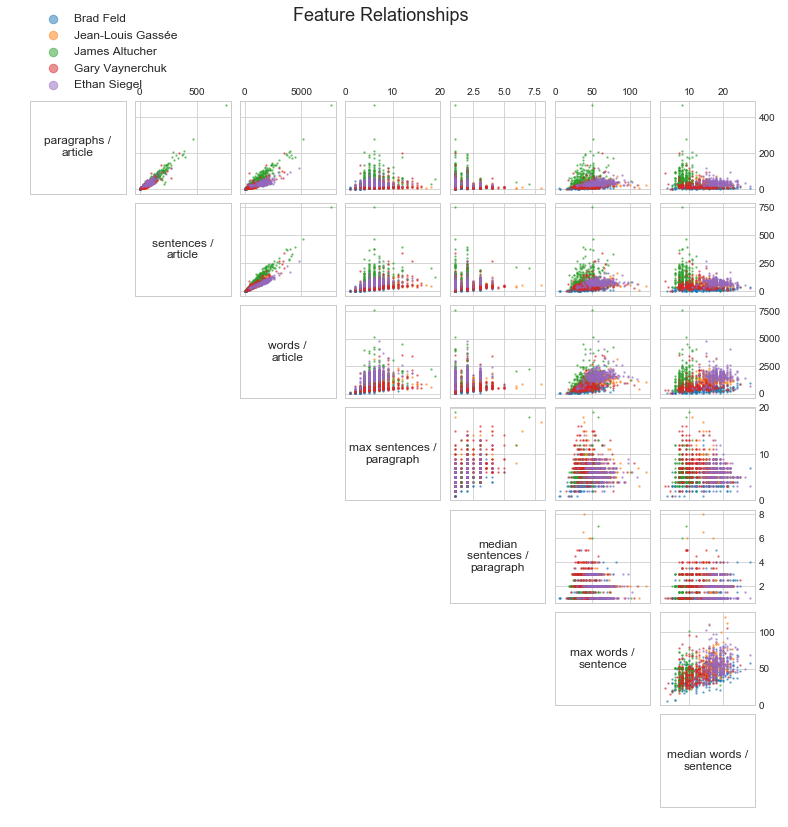

In [9]:
figure1 = plot_feature_scatters(articles_metrics,
                ['Brad Feld', 'Jean-Louis Gassée',
                 'James Altucher', 'Gary Vaynerchuk', 'Ethan Siegel'],
                ['article_num_paragraphs', 'article_num_sentences', 'article_num_words',
                 'paragraphs_max_sentences', 'paragraphs_median_sentences',
                 'sentences_max_words', 'sentences_median_words'],
                ['paragraphs /\narticle', 'sentences /\narticle', 'words /\narticle',
                 'max sentences /\nparagraph', 'median\nsentences /\nparagraph',
                 'max words /\nsentence', 'median words /\nsentence'])
plt.show()

From the scatter plots above it appears that a separation to some degree would be possible. For example, the plot for "words / article" vs "max words / sentence" shows distinct clusters for individual authors. Although the clusters seem to overlap quite a bit.

We will run a few classifier models and see what prediction accuracy we can achieve on a training data set. First, we will try the decision tree algorithm. Decision tree has the advantage that it can work with features that are not normalised.

In [10]:
from sklearn import tree
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split labels into separate data frame
data = articles_metrics
labels = data[['author']]
data = data.drop('author', 1)

# shuffle training test split
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    test_size=0.25,
                                                    random_state=23)

# decision tree prediction model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
score_train = accuracy_score(y_train, clf.predict(X_train))
score_test = accuracy_score(y_test, clf.predict(X_test))

# report decision tree results
print('decision tree classifier:')
print('-------------------------\n')
print('prediction accuracy score on training data set: {:.2f}%'.format(score_train*100))
print('prediction accuracy score on test data set: {:.2f}%'.format(score_test*100))

decision tree classifier:
-------------------------

prediction accuracy score on training data set: 99.98%
prediction accuracy score on test data set: 33.19%


Nearly 100% on the training data! That's awaesome!

Ok.... just joking ;-)

On unseen data the accuracy is 33.51%. I think that's not too bad for a model that tries to guess the author of an article only based on word count lenght of articles, paragraphs and sentences. The model does not take anything of the article content into account. The 100% accuracy on the training data means the model is extremly biased. It would be interesting to see if a grid search can find a better set of parameters.

In [17]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# setup grid search
cv_sets = ShuffleSplit(n_splits=10, test_size = 0.25, random_state = 23)
learning_model = tree.DecisionTreeClassifier()
params = {'max_depth': list(range(1,30)),
          'min_samples_split': list(range(2,50))}
scoring_fnc = make_scorer(accuracy_score, greater_is_better=True)
grid = GridSearchCV(estimator=learning_model,
                    param_grid=params,
                    scoring=scoring_fnc,
                    cv=cv_sets,
                    verbose=2)

# run grid search
grid = grid.fit(X_train, y_train)
best_clf = grid.best_estimator_
score_test = accuracy_score(y_test, best_clf.predict(X_test))

# TODO: add some code to save grid search result object to pickle file

print('GridSearch prediction accuracy score on test data set: {:.2f}%'.format(score_test*100))
print('best parameters:')
print('    max_depth:{0}'.format(best_clf.get_params()['max_depth']))
print('    min_samples_split:{0}'.format(best_clf.get_params()['min_samples_split']))

Fitting 10 folds for each of 1392 candidates, totalling 13920 fits
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] .....

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................. max_depth=1, min_samples_split=2, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.0s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] ................. max_depth=1, min_samples_split=3, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] ................. max_depth=1, min_samples_split=3, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] ................. max_depth=1, min_samples_split=3, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] ................. max_depth=1, min_samples_split=3, total=   0.0s
[CV] max_depth=1, min_samples_split=3 ................................
[CV] .

[CV] ................. max_depth=1, min_samples_split=9, total=   0.0s
[CV] max_depth=1, min_samples_split=9 ................................
[CV] ................. max_depth=1, min_samples_split=9, total=   0.0s
[CV] max_depth=1, min_samples_split=9 ................................
[CV] ................. max_depth=1, min_samples_split=9, total=   0.0s
[CV] max_depth=1, min_samples_split=9 ................................
[CV] ................. max_depth=1, min_samples_split=9, total=   0.0s
[CV] max_depth=1, min_samples_split=9 ................................
[CV] ................. max_depth=1, min_samples_split=9, total=   0.0s
[CV] max_depth=1, min_samples_split=9 ................................
[CV] ................. max_depth=1, min_samples_split=9, total=   0.0s
[CV] max_depth=1, min_samples_split=9 ................................
[CV] ................. max_depth=1, min_samples_split=9, total=   0.0s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] .

[CV] ................ max_depth=1, min_samples_split=15, total=   0.0s
[CV] max_depth=1, min_samples_split=15 ...............................
[CV] ................ max_depth=1, min_samples_split=15, total=   0.0s
[CV] max_depth=1, min_samples_split=15 ...............................
[CV] ................ max_depth=1, min_samples_split=15, total=   0.0s
[CV] max_depth=1, min_samples_split=15 ...............................
[CV] ................ max_depth=1, min_samples_split=15, total=   0.0s
[CV] max_depth=1, min_samples_split=15 ...............................
[CV] ................ max_depth=1, min_samples_split=15, total=   0.0s
[CV] max_depth=1, min_samples_split=16 ...............................
[CV] ................ max_depth=1, min_samples_split=16, total=   0.0s
[CV] max_depth=1, min_samples_split=16 ...............................
[CV] ................ max_depth=1, min_samples_split=16, total=   0.0s
[CV] max_depth=1, min_samples_split=16 ...............................
[CV] .

[CV] ................ max_depth=1, min_samples_split=21, total=   0.0s
[CV] max_depth=1, min_samples_split=21 ...............................
[CV] ................ max_depth=1, min_samples_split=21, total=   0.0s
[CV] max_depth=1, min_samples_split=21 ...............................
[CV] ................ max_depth=1, min_samples_split=21, total=   0.0s
[CV] max_depth=1, min_samples_split=22 ...............................
[CV] ................ max_depth=1, min_samples_split=22, total=   0.0s
[CV] max_depth=1, min_samples_split=22 ...............................
[CV] ................ max_depth=1, min_samples_split=22, total=   0.0s
[CV] max_depth=1, min_samples_split=22 ...............................
[CV] ................ max_depth=1, min_samples_split=22, total=   0.0s
[CV] max_depth=1, min_samples_split=22 ...............................
[CV] ................ max_depth=1, min_samples_split=22, total=   0.0s
[CV] max_depth=1, min_samples_split=22 ...............................
[CV] .

[CV] ................ max_depth=1, min_samples_split=28, total=   0.0s
[CV] max_depth=1, min_samples_split=28 ...............................
[CV] ................ max_depth=1, min_samples_split=28, total=   0.0s
[CV] max_depth=1, min_samples_split=28 ...............................
[CV] ................ max_depth=1, min_samples_split=28, total=   0.0s
[CV] max_depth=1, min_samples_split=28 ...............................
[CV] ................ max_depth=1, min_samples_split=28, total=   0.0s
[CV] max_depth=1, min_samples_split=28 ...............................
[CV] ................ max_depth=1, min_samples_split=28, total=   0.0s
[CV] max_depth=1, min_samples_split=28 ...............................
[CV] ................ max_depth=1, min_samples_split=28, total=   0.0s
[CV] max_depth=1, min_samples_split=28 ...............................
[CV] ................ max_depth=1, min_samples_split=28, total=   0.0s
[CV] max_depth=1, min_samples_split=28 ...............................
[CV] .

[CV] ................ max_depth=1, min_samples_split=34, total=   0.0s
[CV] max_depth=1, min_samples_split=34 ...............................
[CV] ................ max_depth=1, min_samples_split=34, total=   0.0s
[CV] max_depth=1, min_samples_split=34 ...............................
[CV] ................ max_depth=1, min_samples_split=34, total=   0.0s
[CV] max_depth=1, min_samples_split=34 ...............................
[CV] ................ max_depth=1, min_samples_split=34, total=   0.0s
[CV] max_depth=1, min_samples_split=34 ...............................
[CV] ................ max_depth=1, min_samples_split=34, total=   0.0s
[CV] max_depth=1, min_samples_split=34 ...............................
[CV] ................ max_depth=1, min_samples_split=34, total=   0.0s
[CV] max_depth=1, min_samples_split=34 ...............................
[CV] ................ max_depth=1, min_samples_split=34, total=   0.0s
[CV] max_depth=1, min_samples_split=34 ...............................
[CV] .

[CV] ................ max_depth=1, min_samples_split=40, total=   0.0s
[CV] max_depth=1, min_samples_split=40 ...............................
[CV] ................ max_depth=1, min_samples_split=40, total=   0.0s
[CV] max_depth=1, min_samples_split=40 ...............................
[CV] ................ max_depth=1, min_samples_split=40, total=   0.0s
[CV] max_depth=1, min_samples_split=41 ...............................
[CV] ................ max_depth=1, min_samples_split=41, total=   0.0s
[CV] max_depth=1, min_samples_split=41 ...............................
[CV] ................ max_depth=1, min_samples_split=41, total=   0.0s
[CV] max_depth=1, min_samples_split=41 ...............................
[CV] ................ max_depth=1, min_samples_split=41, total=   0.0s
[CV] max_depth=1, min_samples_split=41 ...............................
[CV] ................ max_depth=1, min_samples_split=41, total=   0.0s
[CV] max_depth=1, min_samples_split=41 ...............................
[CV] .

[CV] ................ max_depth=1, min_samples_split=47, total=   0.0s
[CV] max_depth=1, min_samples_split=47 ...............................
[CV] ................ max_depth=1, min_samples_split=47, total=   0.0s
[CV] max_depth=1, min_samples_split=47 ...............................
[CV] ................ max_depth=1, min_samples_split=47, total=   0.0s
[CV] max_depth=1, min_samples_split=47 ...............................
[CV] ................ max_depth=1, min_samples_split=47, total=   0.0s
[CV] max_depth=1, min_samples_split=47 ...............................
[CV] ................ max_depth=1, min_samples_split=47, total=   0.0s
[CV] max_depth=1, min_samples_split=47 ...............................
[CV] ................ max_depth=1, min_samples_split=47, total=   0.0s
[CV] max_depth=1, min_samples_split=47 ...............................
[CV] ................ max_depth=1, min_samples_split=47, total=   0.0s
[CV] max_depth=1, min_samples_split=47 ...............................
[CV] .

[CV] ................. max_depth=2, min_samples_split=4, total=   0.0s
[CV] max_depth=2, min_samples_split=4 ................................
[CV] ................. max_depth=2, min_samples_split=4, total=   0.0s
[CV] max_depth=2, min_samples_split=5 ................................
[CV] ................. max_depth=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_split=5 ................................
[CV] ................. max_depth=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_split=5 ................................
[CV] ................. max_depth=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_split=5 ................................
[CV] ................. max_depth=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_split=5 ................................
[CV] ................. max_depth=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_split=5 ................................
[CV] .

[CV] ................ max_depth=2, min_samples_split=11, total=   0.0s
[CV] max_depth=2, min_samples_split=11 ...............................
[CV] ................ max_depth=2, min_samples_split=11, total=   0.0s
[CV] max_depth=2, min_samples_split=11 ...............................
[CV] ................ max_depth=2, min_samples_split=11, total=   0.0s
[CV] max_depth=2, min_samples_split=11 ...............................
[CV] ................ max_depth=2, min_samples_split=11, total=   0.0s
[CV] max_depth=2, min_samples_split=11 ...............................
[CV] ................ max_depth=2, min_samples_split=11, total=   0.0s
[CV] max_depth=2, min_samples_split=11 ...............................
[CV] ................ max_depth=2, min_samples_split=11, total=   0.0s
[CV] max_depth=2, min_samples_split=11 ...............................
[CV] ................ max_depth=2, min_samples_split=11, total=   0.0s
[CV] max_depth=2, min_samples_split=12 ...............................
[CV] .

[CV] ................ max_depth=2, min_samples_split=17, total=   0.0s
[CV] max_depth=2, min_samples_split=17 ...............................
[CV] ................ max_depth=2, min_samples_split=17, total=   0.0s
[CV] max_depth=2, min_samples_split=17 ...............................
[CV] ................ max_depth=2, min_samples_split=17, total=   0.0s
[CV] max_depth=2, min_samples_split=17 ...............................
[CV] ................ max_depth=2, min_samples_split=17, total=   0.0s
[CV] max_depth=2, min_samples_split=18 ...............................
[CV] ................ max_depth=2, min_samples_split=18, total=   0.0s
[CV] max_depth=2, min_samples_split=18 ...............................
[CV] ................ max_depth=2, min_samples_split=18, total=   0.0s
[CV] max_depth=2, min_samples_split=18 ...............................
[CV] ................ max_depth=2, min_samples_split=18, total=   0.0s
[CV] max_depth=2, min_samples_split=18 ...............................
[CV] .

[CV] ................ max_depth=2, min_samples_split=23, total=   0.0s
[CV] max_depth=2, min_samples_split=23 ...............................
[CV] ................ max_depth=2, min_samples_split=23, total=   0.0s
[CV] max_depth=2, min_samples_split=24 ...............................
[CV] ................ max_depth=2, min_samples_split=24, total=   0.0s
[CV] max_depth=2, min_samples_split=24 ...............................
[CV] ................ max_depth=2, min_samples_split=24, total=   0.0s
[CV] max_depth=2, min_samples_split=24 ...............................
[CV] ................ max_depth=2, min_samples_split=24, total=   0.0s
[CV] max_depth=2, min_samples_split=24 ...............................
[CV] ................ max_depth=2, min_samples_split=24, total=   0.0s
[CV] max_depth=2, min_samples_split=24 ...............................
[CV] ................ max_depth=2, min_samples_split=24, total=   0.0s
[CV] max_depth=2, min_samples_split=24 ...............................
[CV] .

[CV] ................ max_depth=2, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_split=30 ...............................
[CV] ................ max_depth=2, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_split=30 ...............................
[CV] ................ max_depth=2, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_split=30 ...............................
[CV] ................ max_depth=2, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_split=30 ...............................
[CV] ................ max_depth=2, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_split=30 ...............................
[CV] ................ max_depth=2, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_split=30 ...............................
[CV] ................ max_depth=2, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_split=30 ...............................
[CV] .

[CV] ................ max_depth=2, min_samples_split=36, total=   0.0s
[CV] max_depth=2, min_samples_split=36 ...............................
[CV] ................ max_depth=2, min_samples_split=36, total=   0.0s
[CV] max_depth=2, min_samples_split=36 ...............................
[CV] ................ max_depth=2, min_samples_split=36, total=   0.0s
[CV] max_depth=2, min_samples_split=36 ...............................
[CV] ................ max_depth=2, min_samples_split=36, total=   0.0s
[CV] max_depth=2, min_samples_split=36 ...............................
[CV] ................ max_depth=2, min_samples_split=36, total=   0.0s
[CV] max_depth=2, min_samples_split=36 ...............................
[CV] ................ max_depth=2, min_samples_split=36, total=   0.0s
[CV] max_depth=2, min_samples_split=36 ...............................
[CV] ................ max_depth=2, min_samples_split=36, total=   0.0s
[CV] max_depth=2, min_samples_split=36 ...............................
[CV] .

[CV] ................ max_depth=2, min_samples_split=42, total=   0.0s
[CV] max_depth=2, min_samples_split=42 ...............................
[CV] ................ max_depth=2, min_samples_split=42, total=   0.0s
[CV] max_depth=2, min_samples_split=42 ...............................
[CV] ................ max_depth=2, min_samples_split=42, total=   0.0s
[CV] max_depth=2, min_samples_split=42 ...............................
[CV] ................ max_depth=2, min_samples_split=42, total=   0.0s
[CV] max_depth=2, min_samples_split=42 ...............................
[CV] ................ max_depth=2, min_samples_split=42, total=   0.0s
[CV] max_depth=2, min_samples_split=42 ...............................
[CV] ................ max_depth=2, min_samples_split=42, total=   0.0s
[CV] max_depth=2, min_samples_split=42 ...............................
[CV] ................ max_depth=2, min_samples_split=42, total=   0.0s
[CV] max_depth=2, min_samples_split=42 ...............................
[CV] .

[CV] ................ max_depth=2, min_samples_split=48, total=   0.0s
[CV] max_depth=2, min_samples_split=48 ...............................
[CV] ................ max_depth=2, min_samples_split=48, total=   0.0s
[CV] max_depth=2, min_samples_split=48 ...............................
[CV] ................ max_depth=2, min_samples_split=48, total=   0.0s
[CV] max_depth=2, min_samples_split=48 ...............................
[CV] ................ max_depth=2, min_samples_split=48, total=   0.0s
[CV] max_depth=2, min_samples_split=48 ...............................
[CV] ................ max_depth=2, min_samples_split=48, total=   0.0s
[CV] max_depth=2, min_samples_split=48 ...............................
[CV] ................ max_depth=2, min_samples_split=48, total=   0.0s
[CV] max_depth=2, min_samples_split=49 ...............................
[CV] ................ max_depth=2, min_samples_split=49, total=   0.0s
[CV] max_depth=2, min_samples_split=49 ...............................
[CV] .

[CV] ................. max_depth=3, min_samples_split=6, total=   0.0s
[CV] max_depth=3, min_samples_split=6 ................................
[CV] ................. max_depth=3, min_samples_split=6, total=   0.0s
[CV] max_depth=3, min_samples_split=6 ................................
[CV] ................. max_depth=3, min_samples_split=6, total=   0.0s
[CV] max_depth=3, min_samples_split=6 ................................
[CV] ................. max_depth=3, min_samples_split=6, total=   0.0s
[CV] max_depth=3, min_samples_split=6 ................................
[CV] ................. max_depth=3, min_samples_split=6, total=   0.0s
[CV] max_depth=3, min_samples_split=6 ................................
[CV] ................. max_depth=3, min_samples_split=6, total=   0.0s
[CV] max_depth=3, min_samples_split=6 ................................
[CV] ................. max_depth=3, min_samples_split=6, total=   0.0s
[CV] max_depth=3, min_samples_split=7 ................................
[CV] .

[CV] ................ max_depth=3, min_samples_split=12, total=   0.0s
[CV] max_depth=3, min_samples_split=12 ...............................
[CV] ................ max_depth=3, min_samples_split=12, total=   0.0s
[CV] max_depth=3, min_samples_split=12 ...............................
[CV] ................ max_depth=3, min_samples_split=12, total=   0.0s
[CV] max_depth=3, min_samples_split=12 ...............................
[CV] ................ max_depth=3, min_samples_split=12, total=   0.0s
[CV] max_depth=3, min_samples_split=12 ...............................
[CV] ................ max_depth=3, min_samples_split=12, total=   0.0s
[CV] max_depth=3, min_samples_split=12 ...............................
[CV] ................ max_depth=3, min_samples_split=12, total=   0.0s
[CV] max_depth=3, min_samples_split=12 ...............................
[CV] ................ max_depth=3, min_samples_split=12, total=   0.0s
[CV] max_depth=3, min_samples_split=12 ...............................
[CV] .

[CV] ................ max_depth=3, min_samples_split=18, total=   0.0s
[CV] max_depth=3, min_samples_split=18 ...............................
[CV] ................ max_depth=3, min_samples_split=18, total=   0.0s
[CV] max_depth=3, min_samples_split=18 ...............................
[CV] ................ max_depth=3, min_samples_split=18, total=   0.0s
[CV] max_depth=3, min_samples_split=18 ...............................
[CV] ................ max_depth=3, min_samples_split=18, total=   0.0s
[CV] max_depth=3, min_samples_split=18 ...............................
[CV] ................ max_depth=3, min_samples_split=18, total=   0.0s
[CV] max_depth=3, min_samples_split=18 ...............................
[CV] ................ max_depth=3, min_samples_split=18, total=   0.0s
[CV] max_depth=3, min_samples_split=18 ...............................
[CV] ................ max_depth=3, min_samples_split=18, total=   0.0s
[CV] max_depth=3, min_samples_split=18 ...............................
[CV] .

[CV] ................ max_depth=3, min_samples_split=23, total=   0.0s
[CV] max_depth=3, min_samples_split=23 ...............................
[CV] ................ max_depth=3, min_samples_split=23, total=   0.0s
[CV] max_depth=3, min_samples_split=24 ...............................
[CV] ................ max_depth=3, min_samples_split=24, total=   0.0s
[CV] max_depth=3, min_samples_split=24 ...............................
[CV] ................ max_depth=3, min_samples_split=24, total=   0.0s
[CV] max_depth=3, min_samples_split=24 ...............................
[CV] ................ max_depth=3, min_samples_split=24, total=   0.0s
[CV] max_depth=3, min_samples_split=24 ...............................
[CV] ................ max_depth=3, min_samples_split=24, total=   0.0s
[CV] max_depth=3, min_samples_split=24 ...............................
[CV] ................ max_depth=3, min_samples_split=24, total=   0.0s
[CV] max_depth=3, min_samples_split=24 ...............................
[CV] .

[CV] ................ max_depth=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_split=30 ...............................
[CV] ................ max_depth=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_split=30 ...............................
[CV] ................ max_depth=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_split=30 ...............................
[CV] ................ max_depth=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_split=30 ...............................
[CV] ................ max_depth=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_split=30 ...............................
[CV] ................ max_depth=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_split=30 ...............................
[CV] ................ max_depth=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_split=30 ...............................
[CV] .

[CV] ................ max_depth=3, min_samples_split=36, total=   0.0s
[CV] max_depth=3, min_samples_split=36 ...............................
[CV] ................ max_depth=3, min_samples_split=36, total=   0.0s
[CV] max_depth=3, min_samples_split=36 ...............................
[CV] ................ max_depth=3, min_samples_split=36, total=   0.0s
[CV] max_depth=3, min_samples_split=36 ...............................
[CV] ................ max_depth=3, min_samples_split=36, total=   0.0s
[CV] max_depth=3, min_samples_split=36 ...............................
[CV] ................ max_depth=3, min_samples_split=36, total=   0.0s
[CV] max_depth=3, min_samples_split=36 ...............................
[CV] ................ max_depth=3, min_samples_split=36, total=   0.0s
[CV] max_depth=3, min_samples_split=36 ...............................
[CV] ................ max_depth=3, min_samples_split=36, total=   0.0s
[CV] max_depth=3, min_samples_split=36 ...............................
[CV] .

[CV] ................ max_depth=3, min_samples_split=42, total=   0.0s
[CV] max_depth=3, min_samples_split=42 ...............................
[CV] ................ max_depth=3, min_samples_split=42, total=   0.0s
[CV] max_depth=3, min_samples_split=42 ...............................
[CV] ................ max_depth=3, min_samples_split=42, total=   0.0s
[CV] max_depth=3, min_samples_split=42 ...............................
[CV] ................ max_depth=3, min_samples_split=42, total=   0.0s
[CV] max_depth=3, min_samples_split=42 ...............................
[CV] ................ max_depth=3, min_samples_split=42, total=   0.0s
[CV] max_depth=3, min_samples_split=42 ...............................
[CV] ................ max_depth=3, min_samples_split=42, total=   0.0s
[CV] max_depth=3, min_samples_split=42 ...............................
[CV] ................ max_depth=3, min_samples_split=42, total=   0.0s
[CV] max_depth=3, min_samples_split=43 ...............................
[CV] .

[CV] ................ max_depth=3, min_samples_split=48, total=   0.0s
[CV] max_depth=3, min_samples_split=48 ...............................
[CV] ................ max_depth=3, min_samples_split=48, total=   0.0s
[CV] max_depth=3, min_samples_split=48 ...............................
[CV] ................ max_depth=3, min_samples_split=48, total=   0.0s
[CV] max_depth=3, min_samples_split=48 ...............................
[CV] ................ max_depth=3, min_samples_split=48, total=   0.0s
[CV] max_depth=3, min_samples_split=48 ...............................
[CV] ................ max_depth=3, min_samples_split=48, total=   0.0s
[CV] max_depth=3, min_samples_split=49 ...............................
[CV] ................ max_depth=3, min_samples_split=49, total=   0.0s
[CV] max_depth=3, min_samples_split=49 ...............................
[CV] ................ max_depth=3, min_samples_split=49, total=   0.0s
[CV] max_depth=3, min_samples_split=49 ...............................
[CV] .

[CV] max_depth=4, min_samples_split=6 ................................
[CV] ................. max_depth=4, min_samples_split=6, total=   0.0s
[CV] max_depth=4, min_samples_split=6 ................................
[CV] ................. max_depth=4, min_samples_split=6, total=   0.0s
[CV] max_depth=4, min_samples_split=6 ................................
[CV] ................. max_depth=4, min_samples_split=6, total=   0.0s
[CV] max_depth=4, min_samples_split=6 ................................
[CV] ................. max_depth=4, min_samples_split=6, total=   0.0s
[CV] max_depth=4, min_samples_split=7 ................................
[CV] ................. max_depth=4, min_samples_split=7, total=   0.0s
[CV] max_depth=4, min_samples_split=7 ................................
[CV] ................. max_depth=4, min_samples_split=7, total=   0.0s
[CV] max_depth=4, min_samples_split=7 ................................
[CV] ................. max_depth=4, min_samples_split=7, total=   0.0s
[CV] m

[CV] ................ max_depth=4, min_samples_split=12, total=   0.0s
[CV] max_depth=4, min_samples_split=12 ...............................
[CV] ................ max_depth=4, min_samples_split=12, total=   0.0s
[CV] max_depth=4, min_samples_split=12 ...............................
[CV] ................ max_depth=4, min_samples_split=12, total=   0.0s
[CV] max_depth=4, min_samples_split=12 ...............................
[CV] ................ max_depth=4, min_samples_split=12, total=   0.0s
[CV] max_depth=4, min_samples_split=12 ...............................
[CV] ................ max_depth=4, min_samples_split=12, total=   0.0s
[CV] max_depth=4, min_samples_split=12 ...............................
[CV] ................ max_depth=4, min_samples_split=12, total=   0.0s
[CV] max_depth=4, min_samples_split=13 ...............................
[CV] ................ max_depth=4, min_samples_split=13, total=   0.0s
[CV] max_depth=4, min_samples_split=13 ...............................
[CV] .

[CV] ................ max_depth=4, min_samples_split=18, total=   0.0s
[CV] max_depth=4, min_samples_split=18 ...............................
[CV] ................ max_depth=4, min_samples_split=18, total=   0.0s
[CV] max_depth=4, min_samples_split=18 ...............................
[CV] ................ max_depth=4, min_samples_split=18, total=   0.0s
[CV] max_depth=4, min_samples_split=18 ...............................
[CV] ................ max_depth=4, min_samples_split=18, total=   0.0s
[CV] max_depth=4, min_samples_split=18 ...............................
[CV] ................ max_depth=4, min_samples_split=18, total=   0.0s
[CV] max_depth=4, min_samples_split=18 ...............................
[CV] ................ max_depth=4, min_samples_split=18, total=   0.0s
[CV] max_depth=4, min_samples_split=18 ...............................
[CV] ................ max_depth=4, min_samples_split=18, total=   0.0s
[CV] max_depth=4, min_samples_split=19 ...............................
[CV] .

[CV] ................ max_depth=4, min_samples_split=24, total=   0.0s
[CV] max_depth=4, min_samples_split=24 ...............................
[CV] ................ max_depth=4, min_samples_split=24, total=   0.0s
[CV] max_depth=4, min_samples_split=24 ...............................
[CV] ................ max_depth=4, min_samples_split=24, total=   0.0s
[CV] max_depth=4, min_samples_split=24 ...............................
[CV] ................ max_depth=4, min_samples_split=24, total=   0.0s
[CV] max_depth=4, min_samples_split=24 ...............................
[CV] ................ max_depth=4, min_samples_split=24, total=   0.0s
[CV] max_depth=4, min_samples_split=24 ...............................
[CV] ................ max_depth=4, min_samples_split=24, total=   0.0s
[CV] max_depth=4, min_samples_split=24 ...............................
[CV] ................ max_depth=4, min_samples_split=24, total=   0.0s
[CV] max_depth=4, min_samples_split=24 ...............................
[CV] .

[CV] ................ max_depth=4, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_split=30 ...............................
[CV] ................ max_depth=4, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_split=30 ...............................
[CV] ................ max_depth=4, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_split=30 ...............................
[CV] ................ max_depth=4, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_split=30 ...............................
[CV] ................ max_depth=4, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_split=30 ...............................
[CV] ................ max_depth=4, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_split=30 ...............................
[CV] ................ max_depth=4, min_samples_split=30, total=   0.0s
[CV] max_depth=4, min_samples_split=30 ...............................
[CV] .

[CV] ................ max_depth=4, min_samples_split=36, total=   0.0s
[CV] max_depth=4, min_samples_split=36 ...............................
[CV] ................ max_depth=4, min_samples_split=36, total=   0.0s
[CV] max_depth=4, min_samples_split=36 ...............................
[CV] ................ max_depth=4, min_samples_split=36, total=   0.0s
[CV] max_depth=4, min_samples_split=36 ...............................
[CV] ................ max_depth=4, min_samples_split=36, total=   0.0s
[CV] max_depth=4, min_samples_split=36 ...............................
[CV] ................ max_depth=4, min_samples_split=36, total=   0.0s
[CV] max_depth=4, min_samples_split=36 ...............................
[CV] ................ max_depth=4, min_samples_split=36, total=   0.0s
[CV] max_depth=4, min_samples_split=36 ...............................
[CV] ................ max_depth=4, min_samples_split=36, total=   0.0s
[CV] max_depth=4, min_samples_split=36 ...............................
[CV] .

[CV] ................ max_depth=4, min_samples_split=41, total=   0.0s
[CV] max_depth=4, min_samples_split=42 ...............................
[CV] ................ max_depth=4, min_samples_split=42, total=   0.0s
[CV] max_depth=4, min_samples_split=42 ...............................
[CV] ................ max_depth=4, min_samples_split=42, total=   0.0s
[CV] max_depth=4, min_samples_split=42 ...............................
[CV] ................ max_depth=4, min_samples_split=42, total=   0.0s
[CV] max_depth=4, min_samples_split=42 ...............................
[CV] ................ max_depth=4, min_samples_split=42, total=   0.0s
[CV] max_depth=4, min_samples_split=42 ...............................
[CV] ................ max_depth=4, min_samples_split=42, total=   0.0s
[CV] max_depth=4, min_samples_split=42 ...............................
[CV] ................ max_depth=4, min_samples_split=42, total=   0.0s
[CV] max_depth=4, min_samples_split=42 ...............................
[CV] .

[CV] max_depth=4, min_samples_split=48 ...............................
[CV] ................ max_depth=4, min_samples_split=48, total=   0.0s
[CV] max_depth=4, min_samples_split=48 ...............................
[CV] ................ max_depth=4, min_samples_split=48, total=   0.0s
[CV] max_depth=4, min_samples_split=48 ...............................
[CV] ................ max_depth=4, min_samples_split=48, total=   0.0s
[CV] max_depth=4, min_samples_split=48 ...............................
[CV] ................ max_depth=4, min_samples_split=48, total=   0.0s
[CV] max_depth=4, min_samples_split=48 ...............................
[CV] ................ max_depth=4, min_samples_split=48, total=   0.0s
[CV] max_depth=4, min_samples_split=48 ...............................
[CV] ................ max_depth=4, min_samples_split=48, total=   0.0s
[CV] max_depth=4, min_samples_split=48 ...............................
[CV] ................ max_depth=4, min_samples_split=48, total=   0.0s
[CV] m

[CV] ................. max_depth=5, min_samples_split=6, total=   0.0s
[CV] max_depth=5, min_samples_split=6 ................................
[CV] ................. max_depth=5, min_samples_split=6, total=   0.0s
[CV] max_depth=5, min_samples_split=6 ................................
[CV] ................. max_depth=5, min_samples_split=6, total=   0.0s
[CV] max_depth=5, min_samples_split=6 ................................
[CV] ................. max_depth=5, min_samples_split=6, total=   0.0s
[CV] max_depth=5, min_samples_split=6 ................................
[CV] ................. max_depth=5, min_samples_split=6, total=   0.0s
[CV] max_depth=5, min_samples_split=6 ................................
[CV] ................. max_depth=5, min_samples_split=6, total=   0.0s
[CV] max_depth=5, min_samples_split=6 ................................
[CV] ................. max_depth=5, min_samples_split=6, total=   0.0s
[CV] max_depth=5, min_samples_split=7 ................................
[CV] .

[CV] ................ max_depth=5, min_samples_split=12, total=   0.0s
[CV] max_depth=5, min_samples_split=12 ...............................
[CV] ................ max_depth=5, min_samples_split=12, total=   0.0s
[CV] max_depth=5, min_samples_split=12 ...............................
[CV] ................ max_depth=5, min_samples_split=12, total=   0.0s
[CV] max_depth=5, min_samples_split=12 ...............................
[CV] ................ max_depth=5, min_samples_split=12, total=   0.0s
[CV] max_depth=5, min_samples_split=13 ...............................
[CV] ................ max_depth=5, min_samples_split=13, total=   0.0s
[CV] max_depth=5, min_samples_split=13 ...............................
[CV] ................ max_depth=5, min_samples_split=13, total=   0.0s
[CV] max_depth=5, min_samples_split=13 ...............................
[CV] ................ max_depth=5, min_samples_split=13, total=   0.0s
[CV] max_depth=5, min_samples_split=13 ...............................
[CV] .

[CV] ................ max_depth=5, min_samples_split=19, total=   0.0s
[CV] max_depth=5, min_samples_split=19 ...............................
[CV] ................ max_depth=5, min_samples_split=19, total=   0.0s
[CV] max_depth=5, min_samples_split=19 ...............................
[CV] ................ max_depth=5, min_samples_split=19, total=   0.0s
[CV] max_depth=5, min_samples_split=19 ...............................
[CV] ................ max_depth=5, min_samples_split=19, total=   0.0s
[CV] max_depth=5, min_samples_split=19 ...............................
[CV] ................ max_depth=5, min_samples_split=19, total=   0.0s
[CV] max_depth=5, min_samples_split=19 ...............................
[CV] ................ max_depth=5, min_samples_split=19, total=   0.0s
[CV] max_depth=5, min_samples_split=19 ...............................
[CV] ................ max_depth=5, min_samples_split=19, total=   0.0s
[CV] max_depth=5, min_samples_split=19 ...............................
[CV] .

[CV] ................ max_depth=5, min_samples_split=25, total=   0.0s
[CV] max_depth=5, min_samples_split=25 ...............................
[CV] ................ max_depth=5, min_samples_split=25, total=   0.0s
[CV] max_depth=5, min_samples_split=25 ...............................
[CV] ................ max_depth=5, min_samples_split=25, total=   0.0s
[CV] max_depth=5, min_samples_split=25 ...............................
[CV] ................ max_depth=5, min_samples_split=25, total=   0.0s
[CV] max_depth=5, min_samples_split=25 ...............................
[CV] ................ max_depth=5, min_samples_split=25, total=   0.0s
[CV] max_depth=5, min_samples_split=25 ...............................
[CV] ................ max_depth=5, min_samples_split=25, total=   0.0s
[CV] max_depth=5, min_samples_split=25 ...............................
[CV] ................ max_depth=5, min_samples_split=25, total=   0.0s
[CV] max_depth=5, min_samples_split=26 ...............................
[CV] .

[CV] ................ max_depth=5, min_samples_split=31, total=   0.0s
[CV] max_depth=5, min_samples_split=31 ...............................
[CV] ................ max_depth=5, min_samples_split=31, total=   0.0s
[CV] max_depth=5, min_samples_split=31 ...............................
[CV] ................ max_depth=5, min_samples_split=31, total=   0.0s
[CV] max_depth=5, min_samples_split=31 ...............................
[CV] ................ max_depth=5, min_samples_split=31, total=   0.0s
[CV] max_depth=5, min_samples_split=31 ...............................
[CV] ................ max_depth=5, min_samples_split=31, total=   0.0s
[CV] max_depth=5, min_samples_split=31 ...............................
[CV] ................ max_depth=5, min_samples_split=31, total=   0.0s
[CV] max_depth=5, min_samples_split=31 ...............................
[CV] ................ max_depth=5, min_samples_split=31, total=   0.0s
[CV] max_depth=5, min_samples_split=32 ...............................
[CV] .

[CV] ................ max_depth=5, min_samples_split=37, total=   0.0s
[CV] max_depth=5, min_samples_split=37 ...............................
[CV] ................ max_depth=5, min_samples_split=37, total=   0.0s
[CV] max_depth=5, min_samples_split=37 ...............................
[CV] ................ max_depth=5, min_samples_split=37, total=   0.0s
[CV] max_depth=5, min_samples_split=37 ...............................
[CV] ................ max_depth=5, min_samples_split=37, total=   0.0s
[CV] max_depth=5, min_samples_split=37 ...............................
[CV] ................ max_depth=5, min_samples_split=37, total=   0.0s
[CV] max_depth=5, min_samples_split=37 ...............................
[CV] ................ max_depth=5, min_samples_split=37, total=   0.0s
[CV] max_depth=5, min_samples_split=37 ...............................
[CV] ................ max_depth=5, min_samples_split=37, total=   0.0s
[CV] max_depth=5, min_samples_split=37 ...............................
[CV] .

[CV] ................ max_depth=5, min_samples_split=43, total=   0.0s
[CV] max_depth=5, min_samples_split=43 ...............................
[CV] ................ max_depth=5, min_samples_split=43, total=   0.0s
[CV] max_depth=5, min_samples_split=43 ...............................
[CV] ................ max_depth=5, min_samples_split=43, total=   0.0s
[CV] max_depth=5, min_samples_split=43 ...............................
[CV] ................ max_depth=5, min_samples_split=43, total=   0.0s
[CV] max_depth=5, min_samples_split=43 ...............................
[CV] ................ max_depth=5, min_samples_split=43, total=   0.0s
[CV] max_depth=5, min_samples_split=43 ...............................
[CV] ................ max_depth=5, min_samples_split=43, total=   0.0s
[CV] max_depth=5, min_samples_split=43 ...............................
[CV] ................ max_depth=5, min_samples_split=43, total=   0.0s
[CV] max_depth=5, min_samples_split=43 ...............................
[CV] .

[CV] max_depth=5, min_samples_split=49 ...............................
[CV] ................ max_depth=5, min_samples_split=49, total=   0.0s
[CV] max_depth=5, min_samples_split=49 ...............................
[CV] ................ max_depth=5, min_samples_split=49, total=   0.0s
[CV] max_depth=5, min_samples_split=49 ...............................
[CV] ................ max_depth=5, min_samples_split=49, total=   0.0s
[CV] max_depth=5, min_samples_split=49 ...............................
[CV] ................ max_depth=5, min_samples_split=49, total=   0.0s
[CV] max_depth=5, min_samples_split=49 ...............................
[CV] ................ max_depth=5, min_samples_split=49, total=   0.0s
[CV] max_depth=5, min_samples_split=49 ...............................
[CV] ................ max_depth=5, min_samples_split=49, total=   0.0s
[CV] max_depth=5, min_samples_split=49 ...............................
[CV] ................ max_depth=5, min_samples_split=49, total=   0.0s
[CV] m

[CV] ................. max_depth=6, min_samples_split=7, total=   0.0s
[CV] max_depth=6, min_samples_split=7 ................................
[CV] ................. max_depth=6, min_samples_split=7, total=   0.0s
[CV] max_depth=6, min_samples_split=7 ................................
[CV] ................. max_depth=6, min_samples_split=7, total=   0.0s
[CV] max_depth=6, min_samples_split=7 ................................
[CV] ................. max_depth=6, min_samples_split=7, total=   0.0s
[CV] max_depth=6, min_samples_split=7 ................................
[CV] ................. max_depth=6, min_samples_split=7, total=   0.0s
[CV] max_depth=6, min_samples_split=8 ................................
[CV] ................. max_depth=6, min_samples_split=8, total=   0.0s
[CV] max_depth=6, min_samples_split=8 ................................
[CV] ................. max_depth=6, min_samples_split=8, total=   0.0s
[CV] max_depth=6, min_samples_split=8 ................................
[CV] .

[CV] ................ max_depth=6, min_samples_split=13, total=   0.0s
[CV] max_depth=6, min_samples_split=13 ...............................
[CV] ................ max_depth=6, min_samples_split=13, total=   0.0s
[CV] max_depth=6, min_samples_split=13 ...............................
[CV] ................ max_depth=6, min_samples_split=13, total=   0.0s
[CV] max_depth=6, min_samples_split=13 ...............................
[CV] ................ max_depth=6, min_samples_split=13, total=   0.0s
[CV] max_depth=6, min_samples_split=13 ...............................
[CV] ................ max_depth=6, min_samples_split=13, total=   0.0s
[CV] max_depth=6, min_samples_split=13 ...............................
[CV] ................ max_depth=6, min_samples_split=13, total=   0.0s
[CV] max_depth=6, min_samples_split=14 ...............................
[CV] ................ max_depth=6, min_samples_split=14, total=   0.0s
[CV] max_depth=6, min_samples_split=14 ...............................
[CV] .

[CV] ................ max_depth=6, min_samples_split=19, total=   0.0s
[CV] max_depth=6, min_samples_split=19 ...............................
[CV] ................ max_depth=6, min_samples_split=19, total=   0.0s
[CV] max_depth=6, min_samples_split=19 ...............................
[CV] ................ max_depth=6, min_samples_split=19, total=   0.0s
[CV] max_depth=6, min_samples_split=19 ...............................
[CV] ................ max_depth=6, min_samples_split=19, total=   0.0s
[CV] max_depth=6, min_samples_split=19 ...............................
[CV] ................ max_depth=6, min_samples_split=19, total=   0.0s
[CV] max_depth=6, min_samples_split=20 ...............................
[CV] ................ max_depth=6, min_samples_split=20, total=   0.0s
[CV] max_depth=6, min_samples_split=20 ...............................
[CV] ................ max_depth=6, min_samples_split=20, total=   0.0s
[CV] max_depth=6, min_samples_split=20 ...............................
[CV] .

[CV] ................ max_depth=6, min_samples_split=25, total=   0.0s
[CV] max_depth=6, min_samples_split=25 ...............................
[CV] ................ max_depth=6, min_samples_split=25, total=   0.0s
[CV] max_depth=6, min_samples_split=25 ...............................
[CV] ................ max_depth=6, min_samples_split=25, total=   0.0s
[CV] max_depth=6, min_samples_split=25 ...............................
[CV] ................ max_depth=6, min_samples_split=25, total=   0.0s
[CV] max_depth=6, min_samples_split=25 ...............................
[CV] ................ max_depth=6, min_samples_split=25, total=   0.0s
[CV] max_depth=6, min_samples_split=25 ...............................
[CV] ................ max_depth=6, min_samples_split=25, total=   0.0s
[CV] max_depth=6, min_samples_split=26 ...............................
[CV] ................ max_depth=6, min_samples_split=26, total=   0.0s
[CV] max_depth=6, min_samples_split=26 ...............................
[CV] .

[CV] ................ max_depth=6, min_samples_split=31, total=   0.0s
[CV] max_depth=6, min_samples_split=31 ...............................
[CV] ................ max_depth=6, min_samples_split=31, total=   0.0s
[CV] max_depth=6, min_samples_split=31 ...............................
[CV] ................ max_depth=6, min_samples_split=31, total=   0.0s
[CV] max_depth=6, min_samples_split=31 ...............................
[CV] ................ max_depth=6, min_samples_split=31, total=   0.0s
[CV] max_depth=6, min_samples_split=31 ...............................
[CV] ................ max_depth=6, min_samples_split=31, total=   0.0s
[CV] max_depth=6, min_samples_split=31 ...............................
[CV] ................ max_depth=6, min_samples_split=31, total=   0.0s
[CV] max_depth=6, min_samples_split=32 ...............................
[CV] ................ max_depth=6, min_samples_split=32, total=   0.0s
[CV] max_depth=6, min_samples_split=32 ...............................
[CV] .

[CV] ................ max_depth=6, min_samples_split=37, total=   0.0s
[CV] max_depth=6, min_samples_split=37 ...............................
[CV] ................ max_depth=6, min_samples_split=37, total=   0.0s
[CV] max_depth=6, min_samples_split=37 ...............................
[CV] ................ max_depth=6, min_samples_split=37, total=   0.0s
[CV] max_depth=6, min_samples_split=37 ...............................
[CV] ................ max_depth=6, min_samples_split=37, total=   0.0s
[CV] max_depth=6, min_samples_split=37 ...............................
[CV] ................ max_depth=6, min_samples_split=37, total=   0.0s
[CV] max_depth=6, min_samples_split=37 ...............................
[CV] ................ max_depth=6, min_samples_split=37, total=   0.0s
[CV] max_depth=6, min_samples_split=38 ...............................
[CV] ................ max_depth=6, min_samples_split=38, total=   0.0s
[CV] max_depth=6, min_samples_split=38 ...............................
[CV] .

[CV] ................ max_depth=6, min_samples_split=43, total=   0.0s
[CV] max_depth=6, min_samples_split=43 ...............................
[CV] ................ max_depth=6, min_samples_split=43, total=   0.0s
[CV] max_depth=6, min_samples_split=43 ...............................
[CV] ................ max_depth=6, min_samples_split=43, total=   0.0s
[CV] max_depth=6, min_samples_split=43 ...............................
[CV] ................ max_depth=6, min_samples_split=43, total=   0.0s
[CV] max_depth=6, min_samples_split=44 ...............................
[CV] ................ max_depth=6, min_samples_split=44, total=   0.0s
[CV] max_depth=6, min_samples_split=44 ...............................
[CV] ................ max_depth=6, min_samples_split=44, total=   0.0s
[CV] max_depth=6, min_samples_split=44 ...............................
[CV] ................ max_depth=6, min_samples_split=44, total=   0.0s
[CV] max_depth=6, min_samples_split=44 ...............................
[CV] .

[CV] ................ max_depth=6, min_samples_split=49, total=   0.0s
[CV] max_depth=6, min_samples_split=49 ...............................
[CV] ................ max_depth=6, min_samples_split=49, total=   0.0s
[CV] max_depth=6, min_samples_split=49 ...............................
[CV] ................ max_depth=6, min_samples_split=49, total=   0.0s
[CV] max_depth=6, min_samples_split=49 ...............................
[CV] ................ max_depth=6, min_samples_split=49, total=   0.0s
[CV] max_depth=6, min_samples_split=49 ...............................
[CV] ................ max_depth=6, min_samples_split=49, total=   0.0s
[CV] max_depth=7, min_samples_split=2 ................................
[CV] ................. max_depth=7, min_samples_split=2, total=   0.0s
[CV] max_depth=7, min_samples_split=2 ................................
[CV] ................. max_depth=7, min_samples_split=2, total=   0.0s
[CV] max_depth=7, min_samples_split=2 ................................
[CV] .

[CV] ................. max_depth=7, min_samples_split=7, total=   0.0s
[CV] max_depth=7, min_samples_split=7 ................................
[CV] ................. max_depth=7, min_samples_split=7, total=   0.0s
[CV] max_depth=7, min_samples_split=7 ................................
[CV] ................. max_depth=7, min_samples_split=7, total=   0.0s
[CV] max_depth=7, min_samples_split=7 ................................
[CV] ................. max_depth=7, min_samples_split=7, total=   0.0s
[CV] max_depth=7, min_samples_split=7 ................................
[CV] ................. max_depth=7, min_samples_split=7, total=   0.0s
[CV] max_depth=7, min_samples_split=7 ................................
[CV] ................. max_depth=7, min_samples_split=7, total=   0.0s
[CV] max_depth=7, min_samples_split=7 ................................
[CV] ................. max_depth=7, min_samples_split=7, total=   0.0s
[CV] max_depth=7, min_samples_split=8 ................................
[CV] .

[CV] ................ max_depth=7, min_samples_split=13, total=   0.0s
[CV] max_depth=7, min_samples_split=13 ...............................
[CV] ................ max_depth=7, min_samples_split=13, total=   0.0s
[CV] max_depth=7, min_samples_split=13 ...............................
[CV] ................ max_depth=7, min_samples_split=13, total=   0.0s
[CV] max_depth=7, min_samples_split=13 ...............................
[CV] ................ max_depth=7, min_samples_split=13, total=   0.0s
[CV] max_depth=7, min_samples_split=13 ...............................
[CV] ................ max_depth=7, min_samples_split=13, total=   0.0s
[CV] max_depth=7, min_samples_split=13 ...............................
[CV] ................ max_depth=7, min_samples_split=13, total=   0.0s
[CV] max_depth=7, min_samples_split=13 ...............................
[CV] ................ max_depth=7, min_samples_split=13, total=   0.0s
[CV] max_depth=7, min_samples_split=13 ...............................
[CV] .

[CV] ................ max_depth=7, min_samples_split=19, total=   0.0s
[CV] max_depth=7, min_samples_split=19 ...............................
[CV] ................ max_depth=7, min_samples_split=19, total=   0.0s
[CV] max_depth=7, min_samples_split=19 ...............................
[CV] ................ max_depth=7, min_samples_split=19, total=   0.0s
[CV] max_depth=7, min_samples_split=19 ...............................
[CV] ................ max_depth=7, min_samples_split=19, total=   0.0s
[CV] max_depth=7, min_samples_split=19 ...............................
[CV] ................ max_depth=7, min_samples_split=19, total=   0.0s
[CV] max_depth=7, min_samples_split=19 ...............................
[CV] ................ max_depth=7, min_samples_split=19, total=   0.0s
[CV] max_depth=7, min_samples_split=19 ...............................
[CV] ................ max_depth=7, min_samples_split=19, total=   0.0s
[CV] max_depth=7, min_samples_split=19 ...............................
[CV] .

[CV] ................ max_depth=7, min_samples_split=25, total=   0.0s
[CV] max_depth=7, min_samples_split=25 ...............................
[CV] ................ max_depth=7, min_samples_split=25, total=   0.0s
[CV] max_depth=7, min_samples_split=25 ...............................
[CV] ................ max_depth=7, min_samples_split=25, total=   0.0s
[CV] max_depth=7, min_samples_split=25 ...............................
[CV] ................ max_depth=7, min_samples_split=25, total=   0.0s
[CV] max_depth=7, min_samples_split=25 ...............................
[CV] ................ max_depth=7, min_samples_split=25, total=   0.0s
[CV] max_depth=7, min_samples_split=25 ...............................
[CV] ................ max_depth=7, min_samples_split=25, total=   0.0s
[CV] max_depth=7, min_samples_split=25 ...............................
[CV] ................ max_depth=7, min_samples_split=25, total=   0.0s
[CV] max_depth=7, min_samples_split=25 ...............................
[CV] .

[CV] ................ max_depth=7, min_samples_split=31, total=   0.0s
[CV] max_depth=7, min_samples_split=31 ...............................
[CV] ................ max_depth=7, min_samples_split=31, total=   0.0s
[CV] max_depth=7, min_samples_split=31 ...............................
[CV] ................ max_depth=7, min_samples_split=31, total=   0.0s
[CV] max_depth=7, min_samples_split=31 ...............................
[CV] ................ max_depth=7, min_samples_split=31, total=   0.0s
[CV] max_depth=7, min_samples_split=31 ...............................
[CV] ................ max_depth=7, min_samples_split=31, total=   0.0s
[CV] max_depth=7, min_samples_split=31 ...............................
[CV] ................ max_depth=7, min_samples_split=31, total=   0.0s
[CV] max_depth=7, min_samples_split=31 ...............................
[CV] ................ max_depth=7, min_samples_split=31, total=   0.0s
[CV] max_depth=7, min_samples_split=31 ...............................
[CV] .

[CV] ................ max_depth=7, min_samples_split=37, total=   0.0s
[CV] max_depth=7, min_samples_split=37 ...............................
[CV] ................ max_depth=7, min_samples_split=37, total=   0.0s
[CV] max_depth=7, min_samples_split=37 ...............................
[CV] ................ max_depth=7, min_samples_split=37, total=   0.0s
[CV] max_depth=7, min_samples_split=37 ...............................
[CV] ................ max_depth=7, min_samples_split=37, total=   0.0s
[CV] max_depth=7, min_samples_split=37 ...............................
[CV] ................ max_depth=7, min_samples_split=37, total=   0.0s
[CV] max_depth=7, min_samples_split=37 ...............................
[CV] ................ max_depth=7, min_samples_split=37, total=   0.0s
[CV] max_depth=7, min_samples_split=37 ...............................
[CV] ................ max_depth=7, min_samples_split=37, total=   0.0s
[CV] max_depth=7, min_samples_split=37 ...............................
[CV] .

[CV] ................ max_depth=7, min_samples_split=42, total=   0.0s
[CV] max_depth=7, min_samples_split=42 ...............................
[CV] ................ max_depth=7, min_samples_split=42, total=   0.0s
[CV] max_depth=7, min_samples_split=43 ...............................
[CV] ................ max_depth=7, min_samples_split=43, total=   0.0s
[CV] max_depth=7, min_samples_split=43 ...............................
[CV] ................ max_depth=7, min_samples_split=43, total=   0.0s
[CV] max_depth=7, min_samples_split=43 ...............................
[CV] ................ max_depth=7, min_samples_split=43, total=   0.0s
[CV] max_depth=7, min_samples_split=43 ...............................
[CV] ................ max_depth=7, min_samples_split=43, total=   0.0s
[CV] max_depth=7, min_samples_split=43 ...............................
[CV] ................ max_depth=7, min_samples_split=43, total=   0.0s
[CV] max_depth=7, min_samples_split=43 ...............................
[CV] .

[CV] ................ max_depth=7, min_samples_split=48, total=   0.0s
[CV] max_depth=7, min_samples_split=48 ...............................
[CV] ................ max_depth=7, min_samples_split=48, total=   0.0s
[CV] max_depth=7, min_samples_split=48 ...............................
[CV] ................ max_depth=7, min_samples_split=48, total=   0.0s
[CV] max_depth=7, min_samples_split=48 ...............................
[CV] ................ max_depth=7, min_samples_split=48, total=   0.0s
[CV] max_depth=7, min_samples_split=49 ...............................
[CV] ................ max_depth=7, min_samples_split=49, total=   0.0s
[CV] max_depth=7, min_samples_split=49 ...............................
[CV] ................ max_depth=7, min_samples_split=49, total=   0.0s
[CV] max_depth=7, min_samples_split=49 ...............................
[CV] ................ max_depth=7, min_samples_split=49, total=   0.0s
[CV] max_depth=7, min_samples_split=49 ...............................
[CV] .

[CV] ................. max_depth=8, min_samples_split=6, total=   0.0s
[CV] max_depth=8, min_samples_split=6 ................................
[CV] ................. max_depth=8, min_samples_split=6, total=   0.0s
[CV] max_depth=8, min_samples_split=6 ................................
[CV] ................. max_depth=8, min_samples_split=6, total=   0.0s
[CV] max_depth=8, min_samples_split=6 ................................
[CV] ................. max_depth=8, min_samples_split=6, total=   0.0s
[CV] max_depth=8, min_samples_split=6 ................................
[CV] ................. max_depth=8, min_samples_split=6, total=   0.0s
[CV] max_depth=8, min_samples_split=6 ................................
[CV] ................. max_depth=8, min_samples_split=6, total=   0.0s
[CV] max_depth=8, min_samples_split=7 ................................
[CV] ................. max_depth=8, min_samples_split=7, total=   0.0s
[CV] max_depth=8, min_samples_split=7 ................................
[CV] .

[CV] ................ max_depth=8, min_samples_split=12, total=   0.0s
[CV] max_depth=8, min_samples_split=12 ...............................
[CV] ................ max_depth=8, min_samples_split=12, total=   0.0s
[CV] max_depth=8, min_samples_split=12 ...............................
[CV] ................ max_depth=8, min_samples_split=12, total=   0.0s
[CV] max_depth=8, min_samples_split=12 ...............................
[CV] ................ max_depth=8, min_samples_split=12, total=   0.0s
[CV] max_depth=8, min_samples_split=12 ...............................
[CV] ................ max_depth=8, min_samples_split=12, total=   0.0s
[CV] max_depth=8, min_samples_split=12 ...............................
[CV] ................ max_depth=8, min_samples_split=12, total=   0.0s
[CV] max_depth=8, min_samples_split=12 ...............................
[CV] ................ max_depth=8, min_samples_split=12, total=   0.0s
[CV] max_depth=8, min_samples_split=13 ...............................
[CV] .

[CV] ................ max_depth=8, min_samples_split=18, total=   0.0s
[CV] max_depth=8, min_samples_split=18 ...............................
[CV] ................ max_depth=8, min_samples_split=18, total=   0.0s
[CV] max_depth=8, min_samples_split=18 ...............................
[CV] ................ max_depth=8, min_samples_split=18, total=   0.0s
[CV] max_depth=8, min_samples_split=18 ...............................
[CV] ................ max_depth=8, min_samples_split=18, total=   0.0s
[CV] max_depth=8, min_samples_split=18 ...............................
[CV] ................ max_depth=8, min_samples_split=18, total=   0.0s
[CV] max_depth=8, min_samples_split=19 ...............................
[CV] ................ max_depth=8, min_samples_split=19, total=   0.0s
[CV] max_depth=8, min_samples_split=19 ...............................
[CV] ................ max_depth=8, min_samples_split=19, total=   0.0s
[CV] max_depth=8, min_samples_split=19 ...............................
[CV] .

[CV] ................ max_depth=8, min_samples_split=24, total=   0.0s
[CV] max_depth=8, min_samples_split=24 ...............................
[CV] ................ max_depth=8, min_samples_split=24, total=   0.0s
[CV] max_depth=8, min_samples_split=24 ...............................
[CV] ................ max_depth=8, min_samples_split=24, total=   0.0s
[CV] max_depth=8, min_samples_split=24 ...............................
[CV] ................ max_depth=8, min_samples_split=24, total=   0.0s
[CV] max_depth=8, min_samples_split=24 ...............................
[CV] ................ max_depth=8, min_samples_split=24, total=   0.0s
[CV] max_depth=8, min_samples_split=24 ...............................
[CV] ................ max_depth=8, min_samples_split=24, total=   0.0s
[CV] max_depth=8, min_samples_split=25 ...............................
[CV] ................ max_depth=8, min_samples_split=25, total=   0.0s
[CV] max_depth=8, min_samples_split=25 ...............................
[CV] .

[CV] ................ max_depth=8, min_samples_split=30, total=   0.0s
[CV] max_depth=8, min_samples_split=30 ...............................
[CV] ................ max_depth=8, min_samples_split=30, total=   0.0s
[CV] max_depth=8, min_samples_split=30 ...............................
[CV] ................ max_depth=8, min_samples_split=30, total=   0.0s
[CV] max_depth=8, min_samples_split=30 ...............................
[CV] ................ max_depth=8, min_samples_split=30, total=   0.0s
[CV] max_depth=8, min_samples_split=31 ...............................
[CV] ................ max_depth=8, min_samples_split=31, total=   0.0s
[CV] max_depth=8, min_samples_split=31 ...............................
[CV] ................ max_depth=8, min_samples_split=31, total=   0.0s
[CV] max_depth=8, min_samples_split=31 ...............................
[CV] ................ max_depth=8, min_samples_split=31, total=   0.0s
[CV] max_depth=8, min_samples_split=31 ...............................
[CV] .

[CV] ................ max_depth=8, min_samples_split=36, total=   0.0s
[CV] max_depth=8, min_samples_split=36 ...............................
[CV] ................ max_depth=8, min_samples_split=36, total=   0.0s
[CV] max_depth=8, min_samples_split=36 ...............................
[CV] ................ max_depth=8, min_samples_split=36, total=   0.0s
[CV] max_depth=8, min_samples_split=36 ...............................
[CV] ................ max_depth=8, min_samples_split=36, total=   0.0s
[CV] max_depth=8, min_samples_split=37 ...............................
[CV] ................ max_depth=8, min_samples_split=37, total=   0.0s
[CV] max_depth=8, min_samples_split=37 ...............................
[CV] ................ max_depth=8, min_samples_split=37, total=   0.0s
[CV] max_depth=8, min_samples_split=37 ...............................
[CV] ................ max_depth=8, min_samples_split=37, total=   0.0s
[CV] max_depth=8, min_samples_split=37 ...............................
[CV] .

[CV] ................ max_depth=8, min_samples_split=42, total=   0.0s
[CV] max_depth=8, min_samples_split=43 ...............................
[CV] ................ max_depth=8, min_samples_split=43, total=   0.0s
[CV] max_depth=8, min_samples_split=43 ...............................
[CV] ................ max_depth=8, min_samples_split=43, total=   0.0s
[CV] max_depth=8, min_samples_split=43 ...............................
[CV] ................ max_depth=8, min_samples_split=43, total=   0.0s
[CV] max_depth=8, min_samples_split=43 ...............................
[CV] ................ max_depth=8, min_samples_split=43, total=   0.0s
[CV] max_depth=8, min_samples_split=43 ...............................
[CV] ................ max_depth=8, min_samples_split=43, total=   0.0s
[CV] max_depth=8, min_samples_split=43 ...............................
[CV] ................ max_depth=8, min_samples_split=43, total=   0.0s
[CV] max_depth=8, min_samples_split=43 ...............................
[CV] .

[CV] ................ max_depth=8, min_samples_split=48, total=   0.0s
[CV] max_depth=8, min_samples_split=49 ...............................
[CV] ................ max_depth=8, min_samples_split=49, total=   0.0s
[CV] max_depth=8, min_samples_split=49 ...............................
[CV] ................ max_depth=8, min_samples_split=49, total=   0.0s
[CV] max_depth=8, min_samples_split=49 ...............................
[CV] ................ max_depth=8, min_samples_split=49, total=   0.0s
[CV] max_depth=8, min_samples_split=49 ...............................
[CV] ................ max_depth=8, min_samples_split=49, total=   0.0s
[CV] max_depth=8, min_samples_split=49 ...............................
[CV] ................ max_depth=8, min_samples_split=49, total=   0.0s
[CV] max_depth=8, min_samples_split=49 ...............................
[CV] ................ max_depth=8, min_samples_split=49, total=   0.0s
[CV] max_depth=8, min_samples_split=49 ...............................
[CV] .

[CV] ................. max_depth=9, min_samples_split=7, total=   0.0s
[CV] max_depth=9, min_samples_split=7 ................................
[CV] ................. max_depth=9, min_samples_split=7, total=   0.0s
[CV] max_depth=9, min_samples_split=7 ................................
[CV] ................. max_depth=9, min_samples_split=7, total=   0.0s
[CV] max_depth=9, min_samples_split=7 ................................
[CV] ................. max_depth=9, min_samples_split=7, total=   0.0s
[CV] max_depth=9, min_samples_split=7 ................................
[CV] ................. max_depth=9, min_samples_split=7, total=   0.0s
[CV] max_depth=9, min_samples_split=7 ................................
[CV] ................. max_depth=9, min_samples_split=7, total=   0.0s
[CV] max_depth=9, min_samples_split=7 ................................
[CV] ................. max_depth=9, min_samples_split=7, total=   0.0s
[CV] max_depth=9, min_samples_split=7 ................................
[CV] .

[CV] ................ max_depth=9, min_samples_split=13, total=   0.0s
[CV] max_depth=9, min_samples_split=13 ...............................
[CV] ................ max_depth=9, min_samples_split=13, total=   0.0s
[CV] max_depth=9, min_samples_split=13 ...............................
[CV] ................ max_depth=9, min_samples_split=13, total=   0.0s
[CV] max_depth=9, min_samples_split=13 ...............................
[CV] ................ max_depth=9, min_samples_split=13, total=   0.0s
[CV] max_depth=9, min_samples_split=13 ...............................
[CV] ................ max_depth=9, min_samples_split=13, total=   0.0s
[CV] max_depth=9, min_samples_split=13 ...............................
[CV] ................ max_depth=9, min_samples_split=13, total=   0.0s
[CV] max_depth=9, min_samples_split=13 ...............................
[CV] ................ max_depth=9, min_samples_split=13, total=   0.0s
[CV] max_depth=9, min_samples_split=13 ...............................
[CV] .

[CV] ................ max_depth=9, min_samples_split=19, total=   0.0s
[CV] max_depth=9, min_samples_split=19 ...............................
[CV] ................ max_depth=9, min_samples_split=19, total=   0.0s
[CV] max_depth=9, min_samples_split=19 ...............................
[CV] ................ max_depth=9, min_samples_split=19, total=   0.0s
[CV] max_depth=9, min_samples_split=19 ...............................
[CV] ................ max_depth=9, min_samples_split=19, total=   0.0s
[CV] max_depth=9, min_samples_split=19 ...............................
[CV] ................ max_depth=9, min_samples_split=19, total=   0.0s
[CV] max_depth=9, min_samples_split=19 ...............................
[CV] ................ max_depth=9, min_samples_split=19, total=   0.0s
[CV] max_depth=9, min_samples_split=19 ...............................
[CV] ................ max_depth=9, min_samples_split=19, total=   0.0s
[CV] max_depth=9, min_samples_split=19 ...............................
[CV] .

[CV] ................ max_depth=9, min_samples_split=25, total=   0.0s
[CV] max_depth=9, min_samples_split=25 ...............................
[CV] ................ max_depth=9, min_samples_split=25, total=   0.0s
[CV] max_depth=9, min_samples_split=25 ...............................
[CV] ................ max_depth=9, min_samples_split=25, total=   0.0s
[CV] max_depth=9, min_samples_split=25 ...............................
[CV] ................ max_depth=9, min_samples_split=25, total=   0.0s
[CV] max_depth=9, min_samples_split=25 ...............................
[CV] ................ max_depth=9, min_samples_split=25, total=   0.0s
[CV] max_depth=9, min_samples_split=25 ...............................
[CV] ................ max_depth=9, min_samples_split=25, total=   0.0s
[CV] max_depth=9, min_samples_split=25 ...............................
[CV] ................ max_depth=9, min_samples_split=25, total=   0.0s
[CV] max_depth=9, min_samples_split=25 ...............................
[CV] .

[CV] ................ max_depth=9, min_samples_split=31, total=   0.0s
[CV] max_depth=9, min_samples_split=31 ...............................
[CV] ................ max_depth=9, min_samples_split=31, total=   0.0s
[CV] max_depth=9, min_samples_split=31 ...............................
[CV] ................ max_depth=9, min_samples_split=31, total=   0.0s
[CV] max_depth=9, min_samples_split=31 ...............................
[CV] ................ max_depth=9, min_samples_split=31, total=   0.0s
[CV] max_depth=9, min_samples_split=31 ...............................
[CV] ................ max_depth=9, min_samples_split=31, total=   0.0s
[CV] max_depth=9, min_samples_split=31 ...............................
[CV] ................ max_depth=9, min_samples_split=31, total=   0.0s
[CV] max_depth=9, min_samples_split=31 ...............................
[CV] ................ max_depth=9, min_samples_split=31, total=   0.0s
[CV] max_depth=9, min_samples_split=31 ...............................
[CV] .

[CV] ................ max_depth=9, min_samples_split=37, total=   0.0s
[CV] max_depth=9, min_samples_split=37 ...............................
[CV] ................ max_depth=9, min_samples_split=37, total=   0.0s
[CV] max_depth=9, min_samples_split=37 ...............................
[CV] ................ max_depth=9, min_samples_split=37, total=   0.0s
[CV] max_depth=9, min_samples_split=37 ...............................
[CV] ................ max_depth=9, min_samples_split=37, total=   0.0s
[CV] max_depth=9, min_samples_split=37 ...............................
[CV] ................ max_depth=9, min_samples_split=37, total=   0.0s
[CV] max_depth=9, min_samples_split=37 ...............................
[CV] ................ max_depth=9, min_samples_split=37, total=   0.0s
[CV] max_depth=9, min_samples_split=37 ...............................
[CV] ................ max_depth=9, min_samples_split=37, total=   0.0s
[CV] max_depth=9, min_samples_split=37 ...............................
[CV] .

[CV] ................ max_depth=9, min_samples_split=43, total=   0.0s
[CV] max_depth=9, min_samples_split=43 ...............................
[CV] ................ max_depth=9, min_samples_split=43, total=   0.0s
[CV] max_depth=9, min_samples_split=43 ...............................
[CV] ................ max_depth=9, min_samples_split=43, total=   0.0s
[CV] max_depth=9, min_samples_split=43 ...............................
[CV] ................ max_depth=9, min_samples_split=43, total=   0.0s
[CV] max_depth=9, min_samples_split=43 ...............................
[CV] ................ max_depth=9, min_samples_split=43, total=   0.0s
[CV] max_depth=9, min_samples_split=43 ...............................
[CV] ................ max_depth=9, min_samples_split=43, total=   0.0s
[CV] max_depth=9, min_samples_split=43 ...............................
[CV] ................ max_depth=9, min_samples_split=43, total=   0.0s
[CV] max_depth=9, min_samples_split=44 ...............................
[CV] .

[CV] ................ max_depth=9, min_samples_split=49, total=   0.0s
[CV] max_depth=9, min_samples_split=49 ...............................
[CV] ................ max_depth=9, min_samples_split=49, total=   0.0s
[CV] max_depth=9, min_samples_split=49 ...............................
[CV] ................ max_depth=9, min_samples_split=49, total=   0.0s
[CV] max_depth=9, min_samples_split=49 ...............................
[CV] ................ max_depth=9, min_samples_split=49, total=   0.0s
[CV] max_depth=9, min_samples_split=49 ...............................
[CV] ................ max_depth=9, min_samples_split=49, total=   0.0s
[CV] max_depth=9, min_samples_split=49 ...............................
[CV] ................ max_depth=9, min_samples_split=49, total=   0.0s
[CV] max_depth=9, min_samples_split=49 ...............................
[CV] ................ max_depth=9, min_samples_split=49, total=   0.0s
[CV] max_depth=9, min_samples_split=49 ...............................
[CV] .

[CV] ................ max_depth=10, min_samples_split=7, total=   0.0s
[CV] max_depth=10, min_samples_split=7 ...............................
[CV] ................ max_depth=10, min_samples_split=7, total=   0.0s
[CV] max_depth=10, min_samples_split=7 ...............................
[CV] ................ max_depth=10, min_samples_split=7, total=   0.0s
[CV] max_depth=10, min_samples_split=7 ...............................
[CV] ................ max_depth=10, min_samples_split=7, total=   0.0s
[CV] max_depth=10, min_samples_split=7 ...............................
[CV] ................ max_depth=10, min_samples_split=7, total=   0.0s
[CV] max_depth=10, min_samples_split=7 ...............................
[CV] ................ max_depth=10, min_samples_split=7, total=   0.0s
[CV] max_depth=10, min_samples_split=7 ...............................
[CV] ................ max_depth=10, min_samples_split=7, total=   0.0s
[CV] max_depth=10, min_samples_split=7 ...............................
[CV] .

[CV] ............... max_depth=10, min_samples_split=13, total=   0.0s
[CV] max_depth=10, min_samples_split=13 ..............................
[CV] ............... max_depth=10, min_samples_split=13, total=   0.0s
[CV] max_depth=10, min_samples_split=13 ..............................
[CV] ............... max_depth=10, min_samples_split=13, total=   0.0s
[CV] max_depth=10, min_samples_split=13 ..............................
[CV] ............... max_depth=10, min_samples_split=13, total=   0.0s
[CV] max_depth=10, min_samples_split=13 ..............................
[CV] ............... max_depth=10, min_samples_split=13, total=   0.0s
[CV] max_depth=10, min_samples_split=13 ..............................
[CV] ............... max_depth=10, min_samples_split=13, total=   0.0s
[CV] max_depth=10, min_samples_split=13 ..............................
[CV] ............... max_depth=10, min_samples_split=13, total=   0.0s
[CV] max_depth=10, min_samples_split=13 ..............................
[CV] .

[CV] ............... max_depth=10, min_samples_split=18, total=   0.0s
[CV] max_depth=10, min_samples_split=19 ..............................
[CV] ............... max_depth=10, min_samples_split=19, total=   0.0s
[CV] max_depth=10, min_samples_split=19 ..............................
[CV] ............... max_depth=10, min_samples_split=19, total=   0.0s
[CV] max_depth=10, min_samples_split=19 ..............................
[CV] ............... max_depth=10, min_samples_split=19, total=   0.0s
[CV] max_depth=10, min_samples_split=19 ..............................
[CV] ............... max_depth=10, min_samples_split=19, total=   0.0s
[CV] max_depth=10, min_samples_split=19 ..............................
[CV] ............... max_depth=10, min_samples_split=19, total=   0.0s
[CV] max_depth=10, min_samples_split=19 ..............................
[CV] ............... max_depth=10, min_samples_split=19, total=   0.0s
[CV] max_depth=10, min_samples_split=19 ..............................
[CV] .

[CV] ............... max_depth=10, min_samples_split=24, total=   0.0s
[CV] max_depth=10, min_samples_split=24 ..............................
[CV] ............... max_depth=10, min_samples_split=24, total=   0.0s
[CV] max_depth=10, min_samples_split=24 ..............................
[CV] ............... max_depth=10, min_samples_split=24, total=   0.0s
[CV] max_depth=10, min_samples_split=25 ..............................
[CV] ............... max_depth=10, min_samples_split=25, total=   0.0s
[CV] max_depth=10, min_samples_split=25 ..............................
[CV] ............... max_depth=10, min_samples_split=25, total=   0.0s
[CV] max_depth=10, min_samples_split=25 ..............................
[CV] ............... max_depth=10, min_samples_split=25, total=   0.0s
[CV] max_depth=10, min_samples_split=25 ..............................
[CV] ............... max_depth=10, min_samples_split=25, total=   0.0s
[CV] max_depth=10, min_samples_split=25 ..............................
[CV] .

[CV] ............... max_depth=10, min_samples_split=30, total=   0.0s
[CV] max_depth=10, min_samples_split=30 ..............................
[CV] ............... max_depth=10, min_samples_split=30, total=   0.0s
[CV] max_depth=10, min_samples_split=30 ..............................
[CV] ............... max_depth=10, min_samples_split=30, total=   0.0s
[CV] max_depth=10, min_samples_split=30 ..............................
[CV] ............... max_depth=10, min_samples_split=30, total=   0.0s
[CV] max_depth=10, min_samples_split=31 ..............................
[CV] ............... max_depth=10, min_samples_split=31, total=   0.0s
[CV] max_depth=10, min_samples_split=31 ..............................
[CV] ............... max_depth=10, min_samples_split=31, total=   0.0s
[CV] max_depth=10, min_samples_split=31 ..............................
[CV] ............... max_depth=10, min_samples_split=31, total=   0.0s
[CV] max_depth=10, min_samples_split=31 ..............................
[CV] .

[CV] ............... max_depth=10, min_samples_split=36, total=   0.0s
[CV] max_depth=10, min_samples_split=36 ..............................
[CV] ............... max_depth=10, min_samples_split=36, total=   0.0s
[CV] max_depth=10, min_samples_split=36 ..............................
[CV] ............... max_depth=10, min_samples_split=36, total=   0.0s
[CV] max_depth=10, min_samples_split=37 ..............................
[CV] ............... max_depth=10, min_samples_split=37, total=   0.0s
[CV] max_depth=10, min_samples_split=37 ..............................
[CV] ............... max_depth=10, min_samples_split=37, total=   0.0s
[CV] max_depth=10, min_samples_split=37 ..............................
[CV] ............... max_depth=10, min_samples_split=37, total=   0.0s
[CV] max_depth=10, min_samples_split=37 ..............................
[CV] ............... max_depth=10, min_samples_split=37, total=   0.0s
[CV] max_depth=10, min_samples_split=37 ..............................
[CV] .

[CV] ............... max_depth=10, min_samples_split=42, total=   0.0s
[CV] max_depth=10, min_samples_split=43 ..............................
[CV] ............... max_depth=10, min_samples_split=43, total=   0.0s
[CV] max_depth=10, min_samples_split=43 ..............................
[CV] ............... max_depth=10, min_samples_split=43, total=   0.0s
[CV] max_depth=10, min_samples_split=43 ..............................
[CV] ............... max_depth=10, min_samples_split=43, total=   0.0s
[CV] max_depth=10, min_samples_split=43 ..............................
[CV] ............... max_depth=10, min_samples_split=43, total=   0.0s
[CV] max_depth=10, min_samples_split=43 ..............................
[CV] ............... max_depth=10, min_samples_split=43, total=   0.0s
[CV] max_depth=10, min_samples_split=43 ..............................
[CV] ............... max_depth=10, min_samples_split=43, total=   0.0s
[CV] max_depth=10, min_samples_split=43 ..............................
[CV] .

[CV] ............... max_depth=10, min_samples_split=48, total=   0.0s
[CV] max_depth=10, min_samples_split=48 ..............................
[CV] ............... max_depth=10, min_samples_split=48, total=   0.0s
[CV] max_depth=10, min_samples_split=49 ..............................
[CV] ............... max_depth=10, min_samples_split=49, total=   0.0s
[CV] max_depth=10, min_samples_split=49 ..............................
[CV] ............... max_depth=10, min_samples_split=49, total=   0.0s
[CV] max_depth=10, min_samples_split=49 ..............................
[CV] ............... max_depth=10, min_samples_split=49, total=   0.0s
[CV] max_depth=10, min_samples_split=49 ..............................
[CV] ............... max_depth=10, min_samples_split=49, total=   0.0s
[CV] max_depth=10, min_samples_split=49 ..............................
[CV] ............... max_depth=10, min_samples_split=49, total=   0.0s
[CV] max_depth=10, min_samples_split=49 ..............................
[CV] .

[CV] ................ max_depth=11, min_samples_split=6, total=   0.0s
[CV] max_depth=11, min_samples_split=6 ...............................
[CV] ................ max_depth=11, min_samples_split=6, total=   0.0s
[CV] max_depth=11, min_samples_split=6 ...............................
[CV] ................ max_depth=11, min_samples_split=6, total=   0.0s
[CV] max_depth=11, min_samples_split=7 ...............................
[CV] ................ max_depth=11, min_samples_split=7, total=   0.0s
[CV] max_depth=11, min_samples_split=7 ...............................
[CV] ................ max_depth=11, min_samples_split=7, total=   0.0s
[CV] max_depth=11, min_samples_split=7 ...............................
[CV] ................ max_depth=11, min_samples_split=7, total=   0.0s
[CV] max_depth=11, min_samples_split=7 ...............................
[CV] ................ max_depth=11, min_samples_split=7, total=   0.0s
[CV] max_depth=11, min_samples_split=7 ...............................
[CV] .

[CV] ............... max_depth=11, min_samples_split=12, total=   0.0s
[CV] max_depth=11, min_samples_split=12 ..............................
[CV] ............... max_depth=11, min_samples_split=12, total=   0.0s
[CV] max_depth=11, min_samples_split=12 ..............................
[CV] ............... max_depth=11, min_samples_split=12, total=   0.0s
[CV] max_depth=11, min_samples_split=13 ..............................
[CV] ............... max_depth=11, min_samples_split=13, total=   0.0s
[CV] max_depth=11, min_samples_split=13 ..............................
[CV] ............... max_depth=11, min_samples_split=13, total=   0.0s
[CV] max_depth=11, min_samples_split=13 ..............................
[CV] ............... max_depth=11, min_samples_split=13, total=   0.0s
[CV] max_depth=11, min_samples_split=13 ..............................
[CV] ............... max_depth=11, min_samples_split=13, total=   0.0s
[CV] max_depth=11, min_samples_split=13 ..............................
[CV] .

[CV] ............... max_depth=11, min_samples_split=18, total=   0.0s
[CV] max_depth=11, min_samples_split=18 ..............................
[CV] ............... max_depth=11, min_samples_split=18, total=   0.0s
[CV] max_depth=11, min_samples_split=18 ..............................
[CV] ............... max_depth=11, min_samples_split=18, total=   0.0s
[CV] max_depth=11, min_samples_split=19 ..............................
[CV] ............... max_depth=11, min_samples_split=19, total=   0.0s
[CV] max_depth=11, min_samples_split=19 ..............................
[CV] ............... max_depth=11, min_samples_split=19, total=   0.0s
[CV] max_depth=11, min_samples_split=19 ..............................
[CV] ............... max_depth=11, min_samples_split=19, total=   0.0s
[CV] max_depth=11, min_samples_split=19 ..............................
[CV] ............... max_depth=11, min_samples_split=19, total=   0.0s
[CV] max_depth=11, min_samples_split=19 ..............................
[CV] .

[CV] ............... max_depth=11, min_samples_split=24, total=   0.0s
[CV] max_depth=11, min_samples_split=24 ..............................
[CV] ............... max_depth=11, min_samples_split=24, total=   0.0s
[CV] max_depth=11, min_samples_split=24 ..............................
[CV] ............... max_depth=11, min_samples_split=24, total=   0.0s
[CV] max_depth=11, min_samples_split=24 ..............................
[CV] ............... max_depth=11, min_samples_split=24, total=   0.0s
[CV] max_depth=11, min_samples_split=25 ..............................
[CV] ............... max_depth=11, min_samples_split=25, total=   0.0s
[CV] max_depth=11, min_samples_split=25 ..............................
[CV] ............... max_depth=11, min_samples_split=25, total=   0.0s
[CV] max_depth=11, min_samples_split=25 ..............................
[CV] ............... max_depth=11, min_samples_split=25, total=   0.0s
[CV] max_depth=11, min_samples_split=25 ..............................
[CV] .

[CV] ............... max_depth=11, min_samples_split=30, total=   0.0s
[CV] max_depth=11, min_samples_split=30 ..............................
[CV] ............... max_depth=11, min_samples_split=30, total=   0.0s
[CV] max_depth=11, min_samples_split=30 ..............................
[CV] ............... max_depth=11, min_samples_split=30, total=   0.0s
[CV] max_depth=11, min_samples_split=30 ..............................
[CV] ............... max_depth=11, min_samples_split=30, total=   0.0s
[CV] max_depth=11, min_samples_split=31 ..............................
[CV] ............... max_depth=11, min_samples_split=31, total=   0.0s
[CV] max_depth=11, min_samples_split=31 ..............................
[CV] ............... max_depth=11, min_samples_split=31, total=   0.0s
[CV] max_depth=11, min_samples_split=31 ..............................
[CV] ............... max_depth=11, min_samples_split=31, total=   0.0s
[CV] max_depth=11, min_samples_split=31 ..............................
[CV] .

[CV] ............... max_depth=11, min_samples_split=36, total=   0.0s
[CV] max_depth=11, min_samples_split=36 ..............................
[CV] ............... max_depth=11, min_samples_split=36, total=   0.0s
[CV] max_depth=11, min_samples_split=36 ..............................
[CV] ............... max_depth=11, min_samples_split=36, total=   0.0s
[CV] max_depth=11, min_samples_split=36 ..............................
[CV] ............... max_depth=11, min_samples_split=36, total=   0.0s
[CV] max_depth=11, min_samples_split=36 ..............................
[CV] ............... max_depth=11, min_samples_split=36, total=   0.0s
[CV] max_depth=11, min_samples_split=36 ..............................
[CV] ............... max_depth=11, min_samples_split=36, total=   0.0s
[CV] max_depth=11, min_samples_split=37 ..............................
[CV] ............... max_depth=11, min_samples_split=37, total=   0.0s
[CV] max_depth=11, min_samples_split=37 ..............................
[CV] .

[CV] ............... max_depth=11, min_samples_split=42, total=   0.0s
[CV] max_depth=11, min_samples_split=42 ..............................
[CV] ............... max_depth=11, min_samples_split=42, total=   0.0s
[CV] max_depth=11, min_samples_split=42 ..............................
[CV] ............... max_depth=11, min_samples_split=42, total=   0.0s
[CV] max_depth=11, min_samples_split=42 ..............................
[CV] ............... max_depth=11, min_samples_split=42, total=   0.0s
[CV] max_depth=11, min_samples_split=42 ..............................
[CV] ............... max_depth=11, min_samples_split=42, total=   0.0s
[CV] max_depth=11, min_samples_split=42 ..............................
[CV] ............... max_depth=11, min_samples_split=42, total=   0.0s
[CV] max_depth=11, min_samples_split=43 ..............................
[CV] ............... max_depth=11, min_samples_split=43, total=   0.0s
[CV] max_depth=11, min_samples_split=43 ..............................
[CV] .

[CV] ............... max_depth=11, min_samples_split=48, total=   0.0s
[CV] max_depth=11, min_samples_split=48 ..............................
[CV] ............... max_depth=11, min_samples_split=48, total=   0.0s
[CV] max_depth=11, min_samples_split=48 ..............................
[CV] ............... max_depth=11, min_samples_split=48, total=   0.0s
[CV] max_depth=11, min_samples_split=48 ..............................
[CV] ............... max_depth=11, min_samples_split=48, total=   0.0s
[CV] max_depth=11, min_samples_split=49 ..............................
[CV] ............... max_depth=11, min_samples_split=49, total=   0.0s
[CV] max_depth=11, min_samples_split=49 ..............................
[CV] ............... max_depth=11, min_samples_split=49, total=   0.0s
[CV] max_depth=11, min_samples_split=49 ..............................
[CV] ............... max_depth=11, min_samples_split=49, total=   0.0s
[CV] max_depth=11, min_samples_split=49 ..............................
[CV] .

[CV] ................ max_depth=12, min_samples_split=6, total=   0.0s
[CV] max_depth=12, min_samples_split=6 ...............................
[CV] ................ max_depth=12, min_samples_split=6, total=   0.0s
[CV] max_depth=12, min_samples_split=6 ...............................
[CV] ................ max_depth=12, min_samples_split=6, total=   0.0s
[CV] max_depth=12, min_samples_split=6 ...............................
[CV] ................ max_depth=12, min_samples_split=6, total=   0.0s
[CV] max_depth=12, min_samples_split=6 ...............................
[CV] ................ max_depth=12, min_samples_split=6, total=   0.0s
[CV] max_depth=12, min_samples_split=6 ...............................
[CV] ................ max_depth=12, min_samples_split=6, total=   0.0s
[CV] max_depth=12, min_samples_split=7 ...............................
[CV] ................ max_depth=12, min_samples_split=7, total=   0.0s
[CV] max_depth=12, min_samples_split=7 ...............................
[CV] .

[CV] ............... max_depth=12, min_samples_split=12, total=   0.0s
[CV] max_depth=12, min_samples_split=12 ..............................
[CV] ............... max_depth=12, min_samples_split=12, total=   0.0s
[CV] max_depth=12, min_samples_split=12 ..............................
[CV] ............... max_depth=12, min_samples_split=12, total=   0.0s
[CV] max_depth=12, min_samples_split=12 ..............................
[CV] ............... max_depth=12, min_samples_split=12, total=   0.0s
[CV] max_depth=12, min_samples_split=13 ..............................
[CV] ............... max_depth=12, min_samples_split=13, total=   0.0s
[CV] max_depth=12, min_samples_split=13 ..............................
[CV] ............... max_depth=12, min_samples_split=13, total=   0.0s
[CV] max_depth=12, min_samples_split=13 ..............................
[CV] ............... max_depth=12, min_samples_split=13, total=   0.0s
[CV] max_depth=12, min_samples_split=13 ..............................
[CV] .

[CV] ............... max_depth=12, min_samples_split=18, total=   0.0s
[CV] max_depth=12, min_samples_split=18 ..............................
[CV] ............... max_depth=12, min_samples_split=18, total=   0.0s
[CV] max_depth=12, min_samples_split=18 ..............................
[CV] ............... max_depth=12, min_samples_split=18, total=   0.0s
[CV] max_depth=12, min_samples_split=18 ..............................
[CV] ............... max_depth=12, min_samples_split=18, total=   0.0s
[CV] max_depth=12, min_samples_split=19 ..............................
[CV] ............... max_depth=12, min_samples_split=19, total=   0.0s
[CV] max_depth=12, min_samples_split=19 ..............................
[CV] ............... max_depth=12, min_samples_split=19, total=   0.0s
[CV] max_depth=12, min_samples_split=19 ..............................
[CV] ............... max_depth=12, min_samples_split=19, total=   0.0s
[CV] max_depth=12, min_samples_split=19 ..............................
[CV] .

[CV] ............... max_depth=12, min_samples_split=24, total=   0.0s
[CV] max_depth=12, min_samples_split=24 ..............................
[CV] ............... max_depth=12, min_samples_split=24, total=   0.0s
[CV] max_depth=12, min_samples_split=24 ..............................
[CV] ............... max_depth=12, min_samples_split=24, total=   0.0s
[CV] max_depth=12, min_samples_split=24 ..............................
[CV] ............... max_depth=12, min_samples_split=24, total=   0.0s
[CV] max_depth=12, min_samples_split=24 ..............................
[CV] ............... max_depth=12, min_samples_split=24, total=   0.0s
[CV] max_depth=12, min_samples_split=24 ..............................
[CV] ............... max_depth=12, min_samples_split=24, total=   0.0s
[CV] max_depth=12, min_samples_split=25 ..............................
[CV] ............... max_depth=12, min_samples_split=25, total=   0.0s
[CV] max_depth=12, min_samples_split=25 ..............................
[CV] .

[CV] ............... max_depth=12, min_samples_split=30, total=   0.0s
[CV] max_depth=12, min_samples_split=30 ..............................
[CV] ............... max_depth=12, min_samples_split=30, total=   0.0s
[CV] max_depth=12, min_samples_split=30 ..............................
[CV] ............... max_depth=12, min_samples_split=30, total=   0.0s
[CV] max_depth=12, min_samples_split=30 ..............................
[CV] ............... max_depth=12, min_samples_split=30, total=   0.0s
[CV] max_depth=12, min_samples_split=30 ..............................
[CV] ............... max_depth=12, min_samples_split=30, total=   0.0s
[CV] max_depth=12, min_samples_split=31 ..............................
[CV] ............... max_depth=12, min_samples_split=31, total=   0.0s
[CV] max_depth=12, min_samples_split=31 ..............................
[CV] ............... max_depth=12, min_samples_split=31, total=   0.0s
[CV] max_depth=12, min_samples_split=31 ..............................
[CV] .

[CV] ............... max_depth=12, min_samples_split=36, total=   0.0s
[CV] max_depth=12, min_samples_split=36 ..............................
[CV] ............... max_depth=12, min_samples_split=36, total=   0.0s
[CV] max_depth=12, min_samples_split=36 ..............................
[CV] ............... max_depth=12, min_samples_split=36, total=   0.0s
[CV] max_depth=12, min_samples_split=36 ..............................
[CV] ............... max_depth=12, min_samples_split=36, total=   0.0s
[CV] max_depth=12, min_samples_split=36 ..............................
[CV] ............... max_depth=12, min_samples_split=36, total=   0.0s
[CV] max_depth=12, min_samples_split=36 ..............................
[CV] ............... max_depth=12, min_samples_split=36, total=   0.0s
[CV] max_depth=12, min_samples_split=36 ..............................
[CV] ............... max_depth=12, min_samples_split=36, total=   0.0s
[CV] max_depth=12, min_samples_split=37 ..............................
[CV] .

[CV] ............... max_depth=12, min_samples_split=42, total=   0.0s
[CV] max_depth=12, min_samples_split=42 ..............................
[CV] ............... max_depth=12, min_samples_split=42, total=   0.0s
[CV] max_depth=12, min_samples_split=42 ..............................
[CV] ............... max_depth=12, min_samples_split=42, total=   0.0s
[CV] max_depth=12, min_samples_split=42 ..............................
[CV] ............... max_depth=12, min_samples_split=42, total=   0.0s
[CV] max_depth=12, min_samples_split=42 ..............................
[CV] ............... max_depth=12, min_samples_split=42, total=   0.0s
[CV] max_depth=12, min_samples_split=42 ..............................
[CV] ............... max_depth=12, min_samples_split=42, total=   0.0s
[CV] max_depth=12, min_samples_split=43 ..............................
[CV] ............... max_depth=12, min_samples_split=43, total=   0.0s
[CV] max_depth=12, min_samples_split=43 ..............................
[CV] .

[CV] ............... max_depth=12, min_samples_split=48, total=   0.0s
[CV] max_depth=12, min_samples_split=48 ..............................
[CV] ............... max_depth=12, min_samples_split=48, total=   0.0s
[CV] max_depth=12, min_samples_split=48 ..............................
[CV] ............... max_depth=12, min_samples_split=48, total=   0.0s
[CV] max_depth=12, min_samples_split=48 ..............................
[CV] ............... max_depth=12, min_samples_split=48, total=   0.0s
[CV] max_depth=12, min_samples_split=49 ..............................
[CV] ............... max_depth=12, min_samples_split=49, total=   0.0s
[CV] max_depth=12, min_samples_split=49 ..............................
[CV] ............... max_depth=12, min_samples_split=49, total=   0.0s
[CV] max_depth=12, min_samples_split=49 ..............................
[CV] ............... max_depth=12, min_samples_split=49, total=   0.0s
[CV] max_depth=12, min_samples_split=49 ..............................
[CV] .

[CV] ................ max_depth=13, min_samples_split=6, total=   0.0s
[CV] max_depth=13, min_samples_split=6 ...............................
[CV] ................ max_depth=13, min_samples_split=6, total=   0.0s
[CV] max_depth=13, min_samples_split=6 ...............................
[CV] ................ max_depth=13, min_samples_split=6, total=   0.0s
[CV] max_depth=13, min_samples_split=7 ...............................
[CV] ................ max_depth=13, min_samples_split=7, total=   0.0s
[CV] max_depth=13, min_samples_split=7 ...............................
[CV] ................ max_depth=13, min_samples_split=7, total=   0.0s
[CV] max_depth=13, min_samples_split=7 ...............................
[CV] ................ max_depth=13, min_samples_split=7, total=   0.0s
[CV] max_depth=13, min_samples_split=7 ...............................
[CV] ................ max_depth=13, min_samples_split=7, total=   0.0s
[CV] max_depth=13, min_samples_split=7 ...............................
[CV] .

[CV] ............... max_depth=13, min_samples_split=12, total=   0.0s
[CV] max_depth=13, min_samples_split=12 ..............................
[CV] ............... max_depth=13, min_samples_split=12, total=   0.0s
[CV] max_depth=13, min_samples_split=12 ..............................
[CV] ............... max_depth=13, min_samples_split=12, total=   0.0s
[CV] max_depth=13, min_samples_split=12 ..............................
[CV] ............... max_depth=13, min_samples_split=12, total=   0.0s
[CV] max_depth=13, min_samples_split=12 ..............................
[CV] ............... max_depth=13, min_samples_split=12, total=   0.0s
[CV] max_depth=13, min_samples_split=13 ..............................
[CV] ............... max_depth=13, min_samples_split=13, total=   0.0s
[CV] max_depth=13, min_samples_split=13 ..............................
[CV] ............... max_depth=13, min_samples_split=13, total=   0.0s
[CV] max_depth=13, min_samples_split=13 ..............................
[CV] .

[CV] ............... max_depth=13, min_samples_split=18, total=   0.0s
[CV] max_depth=13, min_samples_split=18 ..............................
[CV] ............... max_depth=13, min_samples_split=18, total=   0.0s
[CV] max_depth=13, min_samples_split=18 ..............................
[CV] ............... max_depth=13, min_samples_split=18, total=   0.0s
[CV] max_depth=13, min_samples_split=18 ..............................
[CV] ............... max_depth=13, min_samples_split=18, total=   0.0s
[CV] max_depth=13, min_samples_split=18 ..............................
[CV] ............... max_depth=13, min_samples_split=18, total=   0.0s
[CV] max_depth=13, min_samples_split=18 ..............................
[CV] ............... max_depth=13, min_samples_split=18, total=   0.0s
[CV] max_depth=13, min_samples_split=19 ..............................
[CV] ............... max_depth=13, min_samples_split=19, total=   0.0s
[CV] max_depth=13, min_samples_split=19 ..............................
[CV] .

[CV] ............... max_depth=13, min_samples_split=24, total=   0.0s
[CV] max_depth=13, min_samples_split=24 ..............................
[CV] ............... max_depth=13, min_samples_split=24, total=   0.0s
[CV] max_depth=13, min_samples_split=24 ..............................
[CV] ............... max_depth=13, min_samples_split=24, total=   0.0s
[CV] max_depth=13, min_samples_split=24 ..............................
[CV] ............... max_depth=13, min_samples_split=24, total=   0.0s
[CV] max_depth=13, min_samples_split=24 ..............................
[CV] ............... max_depth=13, min_samples_split=24, total=   0.0s
[CV] max_depth=13, min_samples_split=24 ..............................
[CV] ............... max_depth=13, min_samples_split=24, total=   0.0s
[CV] max_depth=13, min_samples_split=25 ..............................
[CV] ............... max_depth=13, min_samples_split=25, total=   0.0s
[CV] max_depth=13, min_samples_split=25 ..............................
[CV] .

[CV] ............... max_depth=13, min_samples_split=30, total=   0.0s
[CV] max_depth=13, min_samples_split=30 ..............................
[CV] ............... max_depth=13, min_samples_split=30, total=   0.0s
[CV] max_depth=13, min_samples_split=30 ..............................
[CV] ............... max_depth=13, min_samples_split=30, total=   0.0s
[CV] max_depth=13, min_samples_split=30 ..............................
[CV] ............... max_depth=13, min_samples_split=30, total=   0.0s
[CV] max_depth=13, min_samples_split=30 ..............................
[CV] ............... max_depth=13, min_samples_split=30, total=   0.0s
[CV] max_depth=13, min_samples_split=30 ..............................
[CV] ............... max_depth=13, min_samples_split=30, total=   0.0s
[CV] max_depth=13, min_samples_split=31 ..............................
[CV] ............... max_depth=13, min_samples_split=31, total=   0.0s
[CV] max_depth=13, min_samples_split=31 ..............................
[CV] .

[CV] ............... max_depth=13, min_samples_split=36, total=   0.0s
[CV] max_depth=13, min_samples_split=36 ..............................
[CV] ............... max_depth=13, min_samples_split=36, total=   0.0s
[CV] max_depth=13, min_samples_split=36 ..............................
[CV] ............... max_depth=13, min_samples_split=36, total=   0.0s
[CV] max_depth=13, min_samples_split=36 ..............................
[CV] ............... max_depth=13, min_samples_split=36, total=   0.0s
[CV] max_depth=13, min_samples_split=36 ..............................
[CV] ............... max_depth=13, min_samples_split=36, total=   0.0s
[CV] max_depth=13, min_samples_split=36 ..............................
[CV] ............... max_depth=13, min_samples_split=36, total=   0.0s
[CV] max_depth=13, min_samples_split=37 ..............................
[CV] ............... max_depth=13, min_samples_split=37, total=   0.0s
[CV] max_depth=13, min_samples_split=37 ..............................
[CV] .

[CV] ............... max_depth=13, min_samples_split=42, total=   0.0s
[CV] max_depth=13, min_samples_split=42 ..............................
[CV] ............... max_depth=13, min_samples_split=42, total=   0.0s
[CV] max_depth=13, min_samples_split=42 ..............................
[CV] ............... max_depth=13, min_samples_split=42, total=   0.0s
[CV] max_depth=13, min_samples_split=42 ..............................
[CV] ............... max_depth=13, min_samples_split=42, total=   0.0s
[CV] max_depth=13, min_samples_split=42 ..............................
[CV] ............... max_depth=13, min_samples_split=42, total=   0.0s
[CV] max_depth=13, min_samples_split=42 ..............................
[CV] ............... max_depth=13, min_samples_split=42, total=   0.0s
[CV] max_depth=13, min_samples_split=43 ..............................
[CV] ............... max_depth=13, min_samples_split=43, total=   0.0s
[CV] max_depth=13, min_samples_split=43 ..............................
[CV] .

[CV] ............... max_depth=13, min_samples_split=48, total=   0.0s
[CV] max_depth=13, min_samples_split=48 ..............................
[CV] ............... max_depth=13, min_samples_split=48, total=   0.0s
[CV] max_depth=13, min_samples_split=48 ..............................
[CV] ............... max_depth=13, min_samples_split=48, total=   0.0s
[CV] max_depth=13, min_samples_split=48 ..............................
[CV] ............... max_depth=13, min_samples_split=48, total=   0.0s
[CV] max_depth=13, min_samples_split=48 ..............................
[CV] ............... max_depth=13, min_samples_split=48, total=   0.0s
[CV] max_depth=13, min_samples_split=48 ..............................
[CV] ............... max_depth=13, min_samples_split=48, total=   0.0s
[CV] max_depth=13, min_samples_split=49 ..............................
[CV] ............... max_depth=13, min_samples_split=49, total=   0.0s
[CV] max_depth=13, min_samples_split=49 ..............................
[CV] .

[CV] ................ max_depth=14, min_samples_split=6, total=   0.0s
[CV] max_depth=14, min_samples_split=6 ...............................
[CV] ................ max_depth=14, min_samples_split=6, total=   0.0s
[CV] max_depth=14, min_samples_split=6 ...............................
[CV] ................ max_depth=14, min_samples_split=6, total=   0.0s
[CV] max_depth=14, min_samples_split=6 ...............................
[CV] ................ max_depth=14, min_samples_split=6, total=   0.0s
[CV] max_depth=14, min_samples_split=6 ...............................
[CV] ................ max_depth=14, min_samples_split=6, total=   0.0s
[CV] max_depth=14, min_samples_split=6 ...............................
[CV] ................ max_depth=14, min_samples_split=6, total=   0.0s
[CV] max_depth=14, min_samples_split=7 ...............................
[CV] ................ max_depth=14, min_samples_split=7, total=   0.0s
[CV] max_depth=14, min_samples_split=7 ...............................
[CV] .

[CV] ............... max_depth=14, min_samples_split=12, total=   0.0s
[CV] max_depth=14, min_samples_split=12 ..............................
[CV] ............... max_depth=14, min_samples_split=12, total=   0.0s
[CV] max_depth=14, min_samples_split=12 ..............................
[CV] ............... max_depth=14, min_samples_split=12, total=   0.0s
[CV] max_depth=14, min_samples_split=12 ..............................
[CV] ............... max_depth=14, min_samples_split=12, total=   0.0s
[CV] max_depth=14, min_samples_split=12 ..............................
[CV] ............... max_depth=14, min_samples_split=12, total=   0.0s
[CV] max_depth=14, min_samples_split=12 ..............................
[CV] ............... max_depth=14, min_samples_split=12, total=   0.0s
[CV] max_depth=14, min_samples_split=12 ..............................
[CV] ............... max_depth=14, min_samples_split=12, total=   0.0s
[CV] max_depth=14, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=14, min_samples_split=18, total=   0.0s
[CV] max_depth=14, min_samples_split=18 ..............................
[CV] ............... max_depth=14, min_samples_split=18, total=   0.0s
[CV] max_depth=14, min_samples_split=18 ..............................
[CV] ............... max_depth=14, min_samples_split=18, total=   0.0s
[CV] max_depth=14, min_samples_split=18 ..............................
[CV] ............... max_depth=14, min_samples_split=18, total=   0.0s
[CV] max_depth=14, min_samples_split=18 ..............................
[CV] ............... max_depth=14, min_samples_split=18, total=   0.0s
[CV] max_depth=14, min_samples_split=18 ..............................
[CV] ............... max_depth=14, min_samples_split=18, total=   0.0s
[CV] max_depth=14, min_samples_split=18 ..............................
[CV] ............... max_depth=14, min_samples_split=18, total=   0.0s
[CV] max_depth=14, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=14, min_samples_split=24, total=   0.0s
[CV] max_depth=14, min_samples_split=24 ..............................
[CV] ............... max_depth=14, min_samples_split=24, total=   0.0s
[CV] max_depth=14, min_samples_split=24 ..............................
[CV] ............... max_depth=14, min_samples_split=24, total=   0.0s
[CV] max_depth=14, min_samples_split=24 ..............................
[CV] ............... max_depth=14, min_samples_split=24, total=   0.0s
[CV] max_depth=14, min_samples_split=24 ..............................
[CV] ............... max_depth=14, min_samples_split=24, total=   0.0s
[CV] max_depth=14, min_samples_split=24 ..............................
[CV] ............... max_depth=14, min_samples_split=24, total=   0.0s
[CV] max_depth=14, min_samples_split=24 ..............................
[CV] ............... max_depth=14, min_samples_split=24, total=   0.0s
[CV] max_depth=14, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=14, min_samples_split=30, total=   0.0s
[CV] max_depth=14, min_samples_split=30 ..............................
[CV] ............... max_depth=14, min_samples_split=30, total=   0.0s
[CV] max_depth=14, min_samples_split=30 ..............................
[CV] ............... max_depth=14, min_samples_split=30, total=   0.0s
[CV] max_depth=14, min_samples_split=30 ..............................
[CV] ............... max_depth=14, min_samples_split=30, total=   0.0s
[CV] max_depth=14, min_samples_split=30 ..............................
[CV] ............... max_depth=14, min_samples_split=30, total=   0.0s
[CV] max_depth=14, min_samples_split=30 ..............................
[CV] ............... max_depth=14, min_samples_split=30, total=   0.0s
[CV] max_depth=14, min_samples_split=30 ..............................
[CV] ............... max_depth=14, min_samples_split=30, total=   0.0s
[CV] max_depth=14, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=14, min_samples_split=36, total=   0.0s
[CV] max_depth=14, min_samples_split=36 ..............................
[CV] ............... max_depth=14, min_samples_split=36, total=   0.0s
[CV] max_depth=14, min_samples_split=36 ..............................
[CV] ............... max_depth=14, min_samples_split=36, total=   0.0s
[CV] max_depth=14, min_samples_split=36 ..............................
[CV] ............... max_depth=14, min_samples_split=36, total=   0.0s
[CV] max_depth=14, min_samples_split=36 ..............................
[CV] ............... max_depth=14, min_samples_split=36, total=   0.0s
[CV] max_depth=14, min_samples_split=36 ..............................
[CV] ............... max_depth=14, min_samples_split=36, total=   0.0s
[CV] max_depth=14, min_samples_split=36 ..............................
[CV] ............... max_depth=14, min_samples_split=36, total=   0.0s
[CV] max_depth=14, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=14, min_samples_split=42, total=   0.0s
[CV] max_depth=14, min_samples_split=42 ..............................
[CV] ............... max_depth=14, min_samples_split=42, total=   0.0s
[CV] max_depth=14, min_samples_split=42 ..............................
[CV] ............... max_depth=14, min_samples_split=42, total=   0.0s
[CV] max_depth=14, min_samples_split=42 ..............................
[CV] ............... max_depth=14, min_samples_split=42, total=   0.0s
[CV] max_depth=14, min_samples_split=42 ..............................
[CV] ............... max_depth=14, min_samples_split=42, total=   0.0s
[CV] max_depth=14, min_samples_split=42 ..............................
[CV] ............... max_depth=14, min_samples_split=42, total=   0.0s
[CV] max_depth=14, min_samples_split=42 ..............................
[CV] ............... max_depth=14, min_samples_split=42, total=   0.0s
[CV] max_depth=14, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=14, min_samples_split=48, total=   0.0s
[CV] max_depth=14, min_samples_split=48 ..............................
[CV] ............... max_depth=14, min_samples_split=48, total=   0.0s
[CV] max_depth=14, min_samples_split=48 ..............................
[CV] ............... max_depth=14, min_samples_split=48, total=   0.0s
[CV] max_depth=14, min_samples_split=48 ..............................
[CV] ............... max_depth=14, min_samples_split=48, total=   0.0s
[CV] max_depth=14, min_samples_split=48 ..............................
[CV] ............... max_depth=14, min_samples_split=48, total=   0.0s
[CV] max_depth=14, min_samples_split=48 ..............................
[CV] ............... max_depth=14, min_samples_split=48, total=   0.0s
[CV] max_depth=14, min_samples_split=48 ..............................
[CV] ............... max_depth=14, min_samples_split=48, total=   0.0s
[CV] max_depth=14, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=15, min_samples_split=6, total=   0.0s
[CV] max_depth=15, min_samples_split=6 ...............................
[CV] ................ max_depth=15, min_samples_split=6, total=   0.0s
[CV] max_depth=15, min_samples_split=6 ...............................
[CV] ................ max_depth=15, min_samples_split=6, total=   0.0s
[CV] max_depth=15, min_samples_split=6 ...............................
[CV] ................ max_depth=15, min_samples_split=6, total=   0.0s
[CV] max_depth=15, min_samples_split=6 ...............................
[CV] ................ max_depth=15, min_samples_split=6, total=   0.0s
[CV] max_depth=15, min_samples_split=6 ...............................
[CV] ................ max_depth=15, min_samples_split=6, total=   0.0s
[CV] max_depth=15, min_samples_split=6 ...............................
[CV] ................ max_depth=15, min_samples_split=6, total=   0.0s
[CV] max_depth=15, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=15, min_samples_split=12, total=   0.0s
[CV] max_depth=15, min_samples_split=12 ..............................
[CV] ............... max_depth=15, min_samples_split=12, total=   0.0s
[CV] max_depth=15, min_samples_split=12 ..............................
[CV] ............... max_depth=15, min_samples_split=12, total=   0.0s
[CV] max_depth=15, min_samples_split=12 ..............................
[CV] ............... max_depth=15, min_samples_split=12, total=   0.0s
[CV] max_depth=15, min_samples_split=12 ..............................
[CV] ............... max_depth=15, min_samples_split=12, total=   0.0s
[CV] max_depth=15, min_samples_split=12 ..............................
[CV] ............... max_depth=15, min_samples_split=12, total=   0.0s
[CV] max_depth=15, min_samples_split=12 ..............................
[CV] ............... max_depth=15, min_samples_split=12, total=   0.0s
[CV] max_depth=15, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=15, min_samples_split=18, total=   0.0s
[CV] max_depth=15, min_samples_split=18 ..............................
[CV] ............... max_depth=15, min_samples_split=18, total=   0.0s
[CV] max_depth=15, min_samples_split=18 ..............................
[CV] ............... max_depth=15, min_samples_split=18, total=   0.0s
[CV] max_depth=15, min_samples_split=18 ..............................
[CV] ............... max_depth=15, min_samples_split=18, total=   0.0s
[CV] max_depth=15, min_samples_split=18 ..............................
[CV] ............... max_depth=15, min_samples_split=18, total=   0.0s
[CV] max_depth=15, min_samples_split=18 ..............................
[CV] ............... max_depth=15, min_samples_split=18, total=   0.0s
[CV] max_depth=15, min_samples_split=18 ..............................
[CV] ............... max_depth=15, min_samples_split=18, total=   0.0s
[CV] max_depth=15, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=15, min_samples_split=24, total=   0.0s
[CV] max_depth=15, min_samples_split=24 ..............................
[CV] ............... max_depth=15, min_samples_split=24, total=   0.0s
[CV] max_depth=15, min_samples_split=24 ..............................
[CV] ............... max_depth=15, min_samples_split=24, total=   0.0s
[CV] max_depth=15, min_samples_split=24 ..............................
[CV] ............... max_depth=15, min_samples_split=24, total=   0.0s
[CV] max_depth=15, min_samples_split=24 ..............................
[CV] ............... max_depth=15, min_samples_split=24, total=   0.0s
[CV] max_depth=15, min_samples_split=24 ..............................
[CV] ............... max_depth=15, min_samples_split=24, total=   0.0s
[CV] max_depth=15, min_samples_split=24 ..............................
[CV] ............... max_depth=15, min_samples_split=24, total=   0.0s
[CV] max_depth=15, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=15, min_samples_split=30, total=   0.0s
[CV] max_depth=15, min_samples_split=30 ..............................
[CV] ............... max_depth=15, min_samples_split=30, total=   0.0s
[CV] max_depth=15, min_samples_split=30 ..............................
[CV] ............... max_depth=15, min_samples_split=30, total=   0.0s
[CV] max_depth=15, min_samples_split=30 ..............................
[CV] ............... max_depth=15, min_samples_split=30, total=   0.0s
[CV] max_depth=15, min_samples_split=30 ..............................
[CV] ............... max_depth=15, min_samples_split=30, total=   0.0s
[CV] max_depth=15, min_samples_split=30 ..............................
[CV] ............... max_depth=15, min_samples_split=30, total=   0.0s
[CV] max_depth=15, min_samples_split=30 ..............................
[CV] ............... max_depth=15, min_samples_split=30, total=   0.0s
[CV] max_depth=15, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=15, min_samples_split=36, total=   0.0s
[CV] max_depth=15, min_samples_split=36 ..............................
[CV] ............... max_depth=15, min_samples_split=36, total=   0.0s
[CV] max_depth=15, min_samples_split=36 ..............................
[CV] ............... max_depth=15, min_samples_split=36, total=   0.0s
[CV] max_depth=15, min_samples_split=36 ..............................
[CV] ............... max_depth=15, min_samples_split=36, total=   0.0s
[CV] max_depth=15, min_samples_split=36 ..............................
[CV] ............... max_depth=15, min_samples_split=36, total=   0.0s
[CV] max_depth=15, min_samples_split=36 ..............................
[CV] ............... max_depth=15, min_samples_split=36, total=   0.0s
[CV] max_depth=15, min_samples_split=36 ..............................
[CV] ............... max_depth=15, min_samples_split=36, total=   0.0s
[CV] max_depth=15, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=15, min_samples_split=42, total=   0.0s
[CV] max_depth=15, min_samples_split=42 ..............................
[CV] ............... max_depth=15, min_samples_split=42, total=   0.0s
[CV] max_depth=15, min_samples_split=42 ..............................
[CV] ............... max_depth=15, min_samples_split=42, total=   0.0s
[CV] max_depth=15, min_samples_split=42 ..............................
[CV] ............... max_depth=15, min_samples_split=42, total=   0.0s
[CV] max_depth=15, min_samples_split=42 ..............................
[CV] ............... max_depth=15, min_samples_split=42, total=   0.0s
[CV] max_depth=15, min_samples_split=42 ..............................
[CV] ............... max_depth=15, min_samples_split=42, total=   0.0s
[CV] max_depth=15, min_samples_split=42 ..............................
[CV] ............... max_depth=15, min_samples_split=42, total=   0.0s
[CV] max_depth=15, min_samples_split=43 ..............................
[CV] .

[CV] ............... max_depth=15, min_samples_split=48, total=   0.0s
[CV] max_depth=15, min_samples_split=48 ..............................
[CV] ............... max_depth=15, min_samples_split=48, total=   0.0s
[CV] max_depth=15, min_samples_split=48 ..............................
[CV] ............... max_depth=15, min_samples_split=48, total=   0.0s
[CV] max_depth=15, min_samples_split=48 ..............................
[CV] ............... max_depth=15, min_samples_split=48, total=   0.0s
[CV] max_depth=15, min_samples_split=48 ..............................
[CV] ............... max_depth=15, min_samples_split=48, total=   0.0s
[CV] max_depth=15, min_samples_split=49 ..............................
[CV] ............... max_depth=15, min_samples_split=49, total=   0.0s
[CV] max_depth=15, min_samples_split=49 ..............................
[CV] ............... max_depth=15, min_samples_split=49, total=   0.0s
[CV] max_depth=15, min_samples_split=49 ..............................
[CV] .

[CV] ................ max_depth=16, min_samples_split=6, total=   0.0s
[CV] max_depth=16, min_samples_split=6 ...............................
[CV] ................ max_depth=16, min_samples_split=6, total=   0.0s
[CV] max_depth=16, min_samples_split=6 ...............................
[CV] ................ max_depth=16, min_samples_split=6, total=   0.0s
[CV] max_depth=16, min_samples_split=6 ...............................
[CV] ................ max_depth=16, min_samples_split=6, total=   0.0s
[CV] max_depth=16, min_samples_split=6 ...............................
[CV] ................ max_depth=16, min_samples_split=6, total=   0.0s
[CV] max_depth=16, min_samples_split=6 ...............................
[CV] ................ max_depth=16, min_samples_split=6, total=   0.0s
[CV] max_depth=16, min_samples_split=7 ...............................
[CV] ................ max_depth=16, min_samples_split=7, total=   0.0s
[CV] max_depth=16, min_samples_split=7 ...............................
[CV] .

[CV] ............... max_depth=16, min_samples_split=12, total=   0.0s
[CV] max_depth=16, min_samples_split=12 ..............................
[CV] ............... max_depth=16, min_samples_split=12, total=   0.0s
[CV] max_depth=16, min_samples_split=12 ..............................
[CV] ............... max_depth=16, min_samples_split=12, total=   0.0s
[CV] max_depth=16, min_samples_split=12 ..............................
[CV] ............... max_depth=16, min_samples_split=12, total=   0.0s
[CV] max_depth=16, min_samples_split=12 ..............................
[CV] ............... max_depth=16, min_samples_split=12, total=   0.0s
[CV] max_depth=16, min_samples_split=12 ..............................
[CV] ............... max_depth=16, min_samples_split=12, total=   0.0s
[CV] max_depth=16, min_samples_split=12 ..............................
[CV] ............... max_depth=16, min_samples_split=12, total=   0.0s
[CV] max_depth=16, min_samples_split=13 ..............................
[CV] .

[CV] ............... max_depth=16, min_samples_split=18, total=   0.0s
[CV] max_depth=16, min_samples_split=18 ..............................
[CV] ............... max_depth=16, min_samples_split=18, total=   0.0s
[CV] max_depth=16, min_samples_split=18 ..............................
[CV] ............... max_depth=16, min_samples_split=18, total=   0.0s
[CV] max_depth=16, min_samples_split=18 ..............................
[CV] ............... max_depth=16, min_samples_split=18, total=   0.0s
[CV] max_depth=16, min_samples_split=18 ..............................
[CV] ............... max_depth=16, min_samples_split=18, total=   0.0s
[CV] max_depth=16, min_samples_split=18 ..............................
[CV] ............... max_depth=16, min_samples_split=18, total=   0.0s
[CV] max_depth=16, min_samples_split=18 ..............................
[CV] ............... max_depth=16, min_samples_split=18, total=   0.0s
[CV] max_depth=16, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=16, min_samples_split=24, total=   0.0s
[CV] max_depth=16, min_samples_split=24 ..............................
[CV] ............... max_depth=16, min_samples_split=24, total=   0.0s
[CV] max_depth=16, min_samples_split=24 ..............................
[CV] ............... max_depth=16, min_samples_split=24, total=   0.0s
[CV] max_depth=16, min_samples_split=24 ..............................
[CV] ............... max_depth=16, min_samples_split=24, total=   0.0s
[CV] max_depth=16, min_samples_split=24 ..............................
[CV] ............... max_depth=16, min_samples_split=24, total=   0.0s
[CV] max_depth=16, min_samples_split=24 ..............................
[CV] ............... max_depth=16, min_samples_split=24, total=   0.0s
[CV] max_depth=16, min_samples_split=24 ..............................
[CV] ............... max_depth=16, min_samples_split=24, total=   0.0s
[CV] max_depth=16, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=16, min_samples_split=30, total=   0.0s
[CV] max_depth=16, min_samples_split=30 ..............................
[CV] ............... max_depth=16, min_samples_split=30, total=   0.0s
[CV] max_depth=16, min_samples_split=30 ..............................
[CV] ............... max_depth=16, min_samples_split=30, total=   0.0s
[CV] max_depth=16, min_samples_split=30 ..............................
[CV] ............... max_depth=16, min_samples_split=30, total=   0.0s
[CV] max_depth=16, min_samples_split=30 ..............................
[CV] ............... max_depth=16, min_samples_split=30, total=   0.0s
[CV] max_depth=16, min_samples_split=30 ..............................
[CV] ............... max_depth=16, min_samples_split=30, total=   0.0s
[CV] max_depth=16, min_samples_split=30 ..............................
[CV] ............... max_depth=16, min_samples_split=30, total=   0.0s
[CV] max_depth=16, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=16, min_samples_split=36, total=   0.0s
[CV] max_depth=16, min_samples_split=36 ..............................
[CV] ............... max_depth=16, min_samples_split=36, total=   0.0s
[CV] max_depth=16, min_samples_split=36 ..............................
[CV] ............... max_depth=16, min_samples_split=36, total=   0.0s
[CV] max_depth=16, min_samples_split=36 ..............................
[CV] ............... max_depth=16, min_samples_split=36, total=   0.0s
[CV] max_depth=16, min_samples_split=36 ..............................
[CV] ............... max_depth=16, min_samples_split=36, total=   0.0s
[CV] max_depth=16, min_samples_split=36 ..............................
[CV] ............... max_depth=16, min_samples_split=36, total=   0.0s
[CV] max_depth=16, min_samples_split=36 ..............................
[CV] ............... max_depth=16, min_samples_split=36, total=   0.0s
[CV] max_depth=16, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=16, min_samples_split=42, total=   0.0s
[CV] max_depth=16, min_samples_split=42 ..............................
[CV] ............... max_depth=16, min_samples_split=42, total=   0.0s
[CV] max_depth=16, min_samples_split=42 ..............................
[CV] ............... max_depth=16, min_samples_split=42, total=   0.0s
[CV] max_depth=16, min_samples_split=42 ..............................
[CV] ............... max_depth=16, min_samples_split=42, total=   0.0s
[CV] max_depth=16, min_samples_split=42 ..............................
[CV] ............... max_depth=16, min_samples_split=42, total=   0.0s
[CV] max_depth=16, min_samples_split=42 ..............................
[CV] ............... max_depth=16, min_samples_split=42, total=   0.0s
[CV] max_depth=16, min_samples_split=42 ..............................
[CV] ............... max_depth=16, min_samples_split=42, total=   0.0s
[CV] max_depth=16, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=16, min_samples_split=48, total=   0.0s
[CV] max_depth=16, min_samples_split=48 ..............................
[CV] ............... max_depth=16, min_samples_split=48, total=   0.0s
[CV] max_depth=16, min_samples_split=48 ..............................
[CV] ............... max_depth=16, min_samples_split=48, total=   0.0s
[CV] max_depth=16, min_samples_split=48 ..............................
[CV] ............... max_depth=16, min_samples_split=48, total=   0.0s
[CV] max_depth=16, min_samples_split=48 ..............................
[CV] ............... max_depth=16, min_samples_split=48, total=   0.0s
[CV] max_depth=16, min_samples_split=48 ..............................
[CV] ............... max_depth=16, min_samples_split=48, total=   0.0s
[CV] max_depth=16, min_samples_split=48 ..............................
[CV] ............... max_depth=16, min_samples_split=48, total=   0.0s
[CV] max_depth=16, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=17, min_samples_split=6, total=   0.0s
[CV] max_depth=17, min_samples_split=6 ...............................
[CV] ................ max_depth=17, min_samples_split=6, total=   0.0s
[CV] max_depth=17, min_samples_split=6 ...............................
[CV] ................ max_depth=17, min_samples_split=6, total=   0.0s
[CV] max_depth=17, min_samples_split=6 ...............................
[CV] ................ max_depth=17, min_samples_split=6, total=   0.0s
[CV] max_depth=17, min_samples_split=6 ...............................
[CV] ................ max_depth=17, min_samples_split=6, total=   0.0s
[CV] max_depth=17, min_samples_split=6 ...............................
[CV] ................ max_depth=17, min_samples_split=6, total=   0.0s
[CV] max_depth=17, min_samples_split=6 ...............................
[CV] ................ max_depth=17, min_samples_split=6, total=   0.0s
[CV] max_depth=17, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=17, min_samples_split=11, total=   0.0s
[CV] max_depth=17, min_samples_split=12 ..............................
[CV] ............... max_depth=17, min_samples_split=12, total=   0.0s
[CV] max_depth=17, min_samples_split=12 ..............................
[CV] ............... max_depth=17, min_samples_split=12, total=   0.0s
[CV] max_depth=17, min_samples_split=12 ..............................
[CV] ............... max_depth=17, min_samples_split=12, total=   0.0s
[CV] max_depth=17, min_samples_split=12 ..............................
[CV] ............... max_depth=17, min_samples_split=12, total=   0.0s
[CV] max_depth=17, min_samples_split=12 ..............................
[CV] ............... max_depth=17, min_samples_split=12, total=   0.0s
[CV] max_depth=17, min_samples_split=12 ..............................
[CV] ............... max_depth=17, min_samples_split=12, total=   0.0s
[CV] max_depth=17, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=17, min_samples_split=18, total=   0.0s
[CV] max_depth=17, min_samples_split=18 ..............................
[CV] ............... max_depth=17, min_samples_split=18, total=   0.0s
[CV] max_depth=17, min_samples_split=18 ..............................
[CV] ............... max_depth=17, min_samples_split=18, total=   0.0s
[CV] max_depth=17, min_samples_split=18 ..............................
[CV] ............... max_depth=17, min_samples_split=18, total=   0.0s
[CV] max_depth=17, min_samples_split=18 ..............................
[CV] ............... max_depth=17, min_samples_split=18, total=   0.0s
[CV] max_depth=17, min_samples_split=18 ..............................
[CV] ............... max_depth=17, min_samples_split=18, total=   0.0s
[CV] max_depth=17, min_samples_split=18 ..............................
[CV] ............... max_depth=17, min_samples_split=18, total=   0.0s
[CV] max_depth=17, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=17, min_samples_split=24, total=   0.0s
[CV] max_depth=17, min_samples_split=24 ..............................
[CV] ............... max_depth=17, min_samples_split=24, total=   0.0s
[CV] max_depth=17, min_samples_split=24 ..............................
[CV] ............... max_depth=17, min_samples_split=24, total=   0.0s
[CV] max_depth=17, min_samples_split=24 ..............................
[CV] ............... max_depth=17, min_samples_split=24, total=   0.0s
[CV] max_depth=17, min_samples_split=24 ..............................
[CV] ............... max_depth=17, min_samples_split=24, total=   0.0s
[CV] max_depth=17, min_samples_split=24 ..............................
[CV] ............... max_depth=17, min_samples_split=24, total=   0.0s
[CV] max_depth=17, min_samples_split=24 ..............................
[CV] ............... max_depth=17, min_samples_split=24, total=   0.0s
[CV] max_depth=17, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=17, min_samples_split=30, total=   0.0s
[CV] max_depth=17, min_samples_split=30 ..............................
[CV] ............... max_depth=17, min_samples_split=30, total=   0.0s
[CV] max_depth=17, min_samples_split=30 ..............................
[CV] ............... max_depth=17, min_samples_split=30, total=   0.0s
[CV] max_depth=17, min_samples_split=30 ..............................
[CV] ............... max_depth=17, min_samples_split=30, total=   0.0s
[CV] max_depth=17, min_samples_split=30 ..............................
[CV] ............... max_depth=17, min_samples_split=30, total=   0.0s
[CV] max_depth=17, min_samples_split=30 ..............................
[CV] ............... max_depth=17, min_samples_split=30, total=   0.0s
[CV] max_depth=17, min_samples_split=30 ..............................
[CV] ............... max_depth=17, min_samples_split=30, total=   0.0s
[CV] max_depth=17, min_samples_split=31 ..............................
[CV] .

[CV] ............... max_depth=17, min_samples_split=36, total=   0.0s
[CV] max_depth=17, min_samples_split=36 ..............................
[CV] ............... max_depth=17, min_samples_split=36, total=   0.0s
[CV] max_depth=17, min_samples_split=36 ..............................
[CV] ............... max_depth=17, min_samples_split=36, total=   0.0s
[CV] max_depth=17, min_samples_split=36 ..............................
[CV] ............... max_depth=17, min_samples_split=36, total=   0.0s
[CV] max_depth=17, min_samples_split=36 ..............................
[CV] ............... max_depth=17, min_samples_split=36, total=   0.0s
[CV] max_depth=17, min_samples_split=36 ..............................
[CV] ............... max_depth=17, min_samples_split=36, total=   0.0s
[CV] max_depth=17, min_samples_split=36 ..............................
[CV] ............... max_depth=17, min_samples_split=36, total=   0.0s
[CV] max_depth=17, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=17, min_samples_split=42, total=   0.0s
[CV] max_depth=17, min_samples_split=42 ..............................
[CV] ............... max_depth=17, min_samples_split=42, total=   0.0s
[CV] max_depth=17, min_samples_split=42 ..............................
[CV] ............... max_depth=17, min_samples_split=42, total=   0.0s
[CV] max_depth=17, min_samples_split=42 ..............................
[CV] ............... max_depth=17, min_samples_split=42, total=   0.0s
[CV] max_depth=17, min_samples_split=42 ..............................
[CV] ............... max_depth=17, min_samples_split=42, total=   0.0s
[CV] max_depth=17, min_samples_split=42 ..............................
[CV] ............... max_depth=17, min_samples_split=42, total=   0.0s
[CV] max_depth=17, min_samples_split=42 ..............................
[CV] ............... max_depth=17, min_samples_split=42, total=   0.0s
[CV] max_depth=17, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=17, min_samples_split=47, total=   0.0s
[CV] max_depth=17, min_samples_split=48 ..............................
[CV] ............... max_depth=17, min_samples_split=48, total=   0.0s
[CV] max_depth=17, min_samples_split=48 ..............................
[CV] ............... max_depth=17, min_samples_split=48, total=   0.0s
[CV] max_depth=17, min_samples_split=48 ..............................
[CV] ............... max_depth=17, min_samples_split=48, total=   0.0s
[CV] max_depth=17, min_samples_split=48 ..............................
[CV] ............... max_depth=17, min_samples_split=48, total=   0.0s
[CV] max_depth=17, min_samples_split=48 ..............................
[CV] ............... max_depth=17, min_samples_split=48, total=   0.0s
[CV] max_depth=17, min_samples_split=48 ..............................
[CV] ............... max_depth=17, min_samples_split=48, total=   0.0s
[CV] max_depth=17, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=18, min_samples_split=6, total=   0.0s
[CV] max_depth=18, min_samples_split=6 ...............................
[CV] ................ max_depth=18, min_samples_split=6, total=   0.0s
[CV] max_depth=18, min_samples_split=6 ...............................
[CV] ................ max_depth=18, min_samples_split=6, total=   0.0s
[CV] max_depth=18, min_samples_split=6 ...............................
[CV] ................ max_depth=18, min_samples_split=6, total=   0.0s
[CV] max_depth=18, min_samples_split=6 ...............................
[CV] ................ max_depth=18, min_samples_split=6, total=   0.0s
[CV] max_depth=18, min_samples_split=6 ...............................
[CV] ................ max_depth=18, min_samples_split=6, total=   0.0s
[CV] max_depth=18, min_samples_split=6 ...............................
[CV] ................ max_depth=18, min_samples_split=6, total=   0.0s
[CV] max_depth=18, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=18, min_samples_split=12, total=   0.0s
[CV] max_depth=18, min_samples_split=12 ..............................
[CV] ............... max_depth=18, min_samples_split=12, total=   0.0s
[CV] max_depth=18, min_samples_split=12 ..............................
[CV] ............... max_depth=18, min_samples_split=12, total=   0.0s
[CV] max_depth=18, min_samples_split=12 ..............................
[CV] ............... max_depth=18, min_samples_split=12, total=   0.0s
[CV] max_depth=18, min_samples_split=12 ..............................
[CV] ............... max_depth=18, min_samples_split=12, total=   0.0s
[CV] max_depth=18, min_samples_split=12 ..............................
[CV] ............... max_depth=18, min_samples_split=12, total=   0.0s
[CV] max_depth=18, min_samples_split=12 ..............................
[CV] ............... max_depth=18, min_samples_split=12, total=   0.0s
[CV] max_depth=18, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=18, min_samples_split=17, total=   0.0s
[CV] max_depth=18, min_samples_split=17 ..............................
[CV] ............... max_depth=18, min_samples_split=17, total=   0.0s
[CV] max_depth=18, min_samples_split=18 ..............................
[CV] ............... max_depth=18, min_samples_split=18, total=   0.0s
[CV] max_depth=18, min_samples_split=18 ..............................
[CV] ............... max_depth=18, min_samples_split=18, total=   0.0s
[CV] max_depth=18, min_samples_split=18 ..............................
[CV] ............... max_depth=18, min_samples_split=18, total=   0.0s
[CV] max_depth=18, min_samples_split=18 ..............................
[CV] ............... max_depth=18, min_samples_split=18, total=   0.0s
[CV] max_depth=18, min_samples_split=18 ..............................
[CV] ............... max_depth=18, min_samples_split=18, total=   0.0s
[CV] max_depth=18, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=18, min_samples_split=24, total=   0.0s
[CV] max_depth=18, min_samples_split=24 ..............................
[CV] ............... max_depth=18, min_samples_split=24, total=   0.0s
[CV] max_depth=18, min_samples_split=24 ..............................
[CV] ............... max_depth=18, min_samples_split=24, total=   0.0s
[CV] max_depth=18, min_samples_split=24 ..............................
[CV] ............... max_depth=18, min_samples_split=24, total=   0.0s
[CV] max_depth=18, min_samples_split=24 ..............................
[CV] ............... max_depth=18, min_samples_split=24, total=   0.0s
[CV] max_depth=18, min_samples_split=24 ..............................
[CV] ............... max_depth=18, min_samples_split=24, total=   0.0s
[CV] max_depth=18, min_samples_split=24 ..............................
[CV] ............... max_depth=18, min_samples_split=24, total=   0.0s
[CV] max_depth=18, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=18, min_samples_split=29, total=   0.0s
[CV] max_depth=18, min_samples_split=30 ..............................
[CV] ............... max_depth=18, min_samples_split=30, total=   0.0s
[CV] max_depth=18, min_samples_split=30 ..............................
[CV] ............... max_depth=18, min_samples_split=30, total=   0.0s
[CV] max_depth=18, min_samples_split=30 ..............................
[CV] ............... max_depth=18, min_samples_split=30, total=   0.0s
[CV] max_depth=18, min_samples_split=30 ..............................
[CV] ............... max_depth=18, min_samples_split=30, total=   0.0s
[CV] max_depth=18, min_samples_split=30 ..............................
[CV] ............... max_depth=18, min_samples_split=30, total=   0.0s
[CV] max_depth=18, min_samples_split=30 ..............................
[CV] ............... max_depth=18, min_samples_split=30, total=   0.0s
[CV] max_depth=18, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=18, min_samples_split=35, total=   0.0s
[CV] max_depth=18, min_samples_split=35 ..............................
[CV] ............... max_depth=18, min_samples_split=35, total=   0.0s
[CV] max_depth=18, min_samples_split=36 ..............................
[CV] ............... max_depth=18, min_samples_split=36, total=   0.0s
[CV] max_depth=18, min_samples_split=36 ..............................
[CV] ............... max_depth=18, min_samples_split=36, total=   0.0s
[CV] max_depth=18, min_samples_split=36 ..............................
[CV] ............... max_depth=18, min_samples_split=36, total=   0.0s
[CV] max_depth=18, min_samples_split=36 ..............................
[CV] ............... max_depth=18, min_samples_split=36, total=   0.0s
[CV] max_depth=18, min_samples_split=36 ..............................
[CV] ............... max_depth=18, min_samples_split=36, total=   0.0s
[CV] max_depth=18, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=18, min_samples_split=41, total=   0.0s
[CV] max_depth=18, min_samples_split=41 ..............................
[CV] ............... max_depth=18, min_samples_split=41, total=   0.0s
[CV] max_depth=18, min_samples_split=42 ..............................
[CV] ............... max_depth=18, min_samples_split=42, total=   0.0s
[CV] max_depth=18, min_samples_split=42 ..............................
[CV] ............... max_depth=18, min_samples_split=42, total=   0.0s
[CV] max_depth=18, min_samples_split=42 ..............................
[CV] ............... max_depth=18, min_samples_split=42, total=   0.0s
[CV] max_depth=18, min_samples_split=42 ..............................
[CV] ............... max_depth=18, min_samples_split=42, total=   0.0s
[CV] max_depth=18, min_samples_split=42 ..............................
[CV] ............... max_depth=18, min_samples_split=42, total=   0.0s
[CV] max_depth=18, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=18, min_samples_split=47, total=   0.0s
[CV] max_depth=18, min_samples_split=47 ..............................
[CV] ............... max_depth=18, min_samples_split=47, total=   0.0s
[CV] max_depth=18, min_samples_split=48 ..............................
[CV] ............... max_depth=18, min_samples_split=48, total=   0.0s
[CV] max_depth=18, min_samples_split=48 ..............................
[CV] ............... max_depth=18, min_samples_split=48, total=   0.0s
[CV] max_depth=18, min_samples_split=48 ..............................
[CV] ............... max_depth=18, min_samples_split=48, total=   0.0s
[CV] max_depth=18, min_samples_split=48 ..............................
[CV] ............... max_depth=18, min_samples_split=48, total=   0.0s
[CV] max_depth=18, min_samples_split=48 ..............................
[CV] ............... max_depth=18, min_samples_split=48, total=   0.0s
[CV] max_depth=18, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=19, min_samples_split=5, total=   0.0s
[CV] max_depth=19, min_samples_split=6 ...............................
[CV] ................ max_depth=19, min_samples_split=6, total=   0.0s
[CV] max_depth=19, min_samples_split=6 ...............................
[CV] ................ max_depth=19, min_samples_split=6, total=   0.0s
[CV] max_depth=19, min_samples_split=6 ...............................
[CV] ................ max_depth=19, min_samples_split=6, total=   0.0s
[CV] max_depth=19, min_samples_split=6 ...............................
[CV] ................ max_depth=19, min_samples_split=6, total=   0.0s
[CV] max_depth=19, min_samples_split=6 ...............................
[CV] ................ max_depth=19, min_samples_split=6, total=   0.0s
[CV] max_depth=19, min_samples_split=6 ...............................
[CV] ................ max_depth=19, min_samples_split=6, total=   0.0s
[CV] max_depth=19, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=19, min_samples_split=11, total=   0.0s
[CV] max_depth=19, min_samples_split=12 ..............................
[CV] ............... max_depth=19, min_samples_split=12, total=   0.0s
[CV] max_depth=19, min_samples_split=12 ..............................
[CV] ............... max_depth=19, min_samples_split=12, total=   0.0s
[CV] max_depth=19, min_samples_split=12 ..............................
[CV] ............... max_depth=19, min_samples_split=12, total=   0.0s
[CV] max_depth=19, min_samples_split=12 ..............................
[CV] ............... max_depth=19, min_samples_split=12, total=   0.0s
[CV] max_depth=19, min_samples_split=12 ..............................
[CV] ............... max_depth=19, min_samples_split=12, total=   0.0s
[CV] max_depth=19, min_samples_split=12 ..............................
[CV] ............... max_depth=19, min_samples_split=12, total=   0.0s
[CV] max_depth=19, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=19, min_samples_split=17, total=   0.0s
[CV] max_depth=19, min_samples_split=18 ..............................
[CV] ............... max_depth=19, min_samples_split=18, total=   0.0s
[CV] max_depth=19, min_samples_split=18 ..............................
[CV] ............... max_depth=19, min_samples_split=18, total=   0.0s
[CV] max_depth=19, min_samples_split=18 ..............................
[CV] ............... max_depth=19, min_samples_split=18, total=   0.0s
[CV] max_depth=19, min_samples_split=18 ..............................
[CV] ............... max_depth=19, min_samples_split=18, total=   0.0s
[CV] max_depth=19, min_samples_split=18 ..............................
[CV] ............... max_depth=19, min_samples_split=18, total=   0.0s
[CV] max_depth=19, min_samples_split=18 ..............................
[CV] ............... max_depth=19, min_samples_split=18, total=   0.0s
[CV] max_depth=19, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=19, min_samples_split=23, total=   0.0s
[CV] max_depth=19, min_samples_split=23 ..............................
[CV] ............... max_depth=19, min_samples_split=23, total=   0.0s
[CV] max_depth=19, min_samples_split=24 ..............................
[CV] ............... max_depth=19, min_samples_split=24, total=   0.0s
[CV] max_depth=19, min_samples_split=24 ..............................
[CV] ............... max_depth=19, min_samples_split=24, total=   0.0s
[CV] max_depth=19, min_samples_split=24 ..............................
[CV] ............... max_depth=19, min_samples_split=24, total=   0.0s
[CV] max_depth=19, min_samples_split=24 ..............................
[CV] ............... max_depth=19, min_samples_split=24, total=   0.0s
[CV] max_depth=19, min_samples_split=24 ..............................
[CV] ............... max_depth=19, min_samples_split=24, total=   0.0s
[CV] max_depth=19, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=19, min_samples_split=29, total=   0.0s
[CV] max_depth=19, min_samples_split=29 ..............................
[CV] ............... max_depth=19, min_samples_split=29, total=   0.0s
[CV] max_depth=19, min_samples_split=29 ..............................
[CV] ............... max_depth=19, min_samples_split=29, total=   0.0s
[CV] max_depth=19, min_samples_split=29 ..............................
[CV] ............... max_depth=19, min_samples_split=29, total=   0.0s
[CV] max_depth=19, min_samples_split=30 ..............................
[CV] ............... max_depth=19, min_samples_split=30, total=   0.0s
[CV] max_depth=19, min_samples_split=30 ..............................
[CV] ............... max_depth=19, min_samples_split=30, total=   0.0s
[CV] max_depth=19, min_samples_split=30 ..............................
[CV] ............... max_depth=19, min_samples_split=30, total=   0.0s
[CV] max_depth=19, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=19, min_samples_split=35, total=   0.0s
[CV] max_depth=19, min_samples_split=35 ..............................
[CV] ............... max_depth=19, min_samples_split=35, total=   0.0s
[CV] max_depth=19, min_samples_split=35 ..............................
[CV] ............... max_depth=19, min_samples_split=35, total=   0.0s
[CV] max_depth=19, min_samples_split=35 ..............................
[CV] ............... max_depth=19, min_samples_split=35, total=   0.0s
[CV] max_depth=19, min_samples_split=36 ..............................
[CV] ............... max_depth=19, min_samples_split=36, total=   0.0s
[CV] max_depth=19, min_samples_split=36 ..............................
[CV] ............... max_depth=19, min_samples_split=36, total=   0.0s
[CV] max_depth=19, min_samples_split=36 ..............................
[CV] ............... max_depth=19, min_samples_split=36, total=   0.0s
[CV] max_depth=19, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=19, min_samples_split=41, total=   0.0s
[CV] max_depth=19, min_samples_split=41 ..............................
[CV] ............... max_depth=19, min_samples_split=41, total=   0.0s
[CV] max_depth=19, min_samples_split=41 ..............................
[CV] ............... max_depth=19, min_samples_split=41, total=   0.0s
[CV] max_depth=19, min_samples_split=41 ..............................
[CV] ............... max_depth=19, min_samples_split=41, total=   0.0s
[CV] max_depth=19, min_samples_split=42 ..............................
[CV] ............... max_depth=19, min_samples_split=42, total=   0.0s
[CV] max_depth=19, min_samples_split=42 ..............................
[CV] ............... max_depth=19, min_samples_split=42, total=   0.0s
[CV] max_depth=19, min_samples_split=42 ..............................
[CV] ............... max_depth=19, min_samples_split=42, total=   0.0s
[CV] max_depth=19, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=19, min_samples_split=47, total=   0.0s
[CV] max_depth=19, min_samples_split=47 ..............................
[CV] ............... max_depth=19, min_samples_split=47, total=   0.0s
[CV] max_depth=19, min_samples_split=47 ..............................
[CV] ............... max_depth=19, min_samples_split=47, total=   0.0s
[CV] max_depth=19, min_samples_split=47 ..............................
[CV] ............... max_depth=19, min_samples_split=47, total=   0.0s
[CV] max_depth=19, min_samples_split=47 ..............................
[CV] ............... max_depth=19, min_samples_split=47, total=   0.0s
[CV] max_depth=19, min_samples_split=48 ..............................
[CV] ............... max_depth=19, min_samples_split=48, total=   0.0s
[CV] max_depth=19, min_samples_split=48 ..............................
[CV] ............... max_depth=19, min_samples_split=48, total=   0.0s
[CV] max_depth=19, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=20, min_samples_split=5, total=   0.0s
[CV] max_depth=20, min_samples_split=5 ...............................
[CV] ................ max_depth=20, min_samples_split=5, total=   0.0s
[CV] max_depth=20, min_samples_split=5 ...............................
[CV] ................ max_depth=20, min_samples_split=5, total=   0.0s
[CV] max_depth=20, min_samples_split=5 ...............................
[CV] ................ max_depth=20, min_samples_split=5, total=   0.0s
[CV] max_depth=20, min_samples_split=6 ...............................
[CV] ................ max_depth=20, min_samples_split=6, total=   0.0s
[CV] max_depth=20, min_samples_split=6 ...............................
[CV] ................ max_depth=20, min_samples_split=6, total=   0.0s
[CV] max_depth=20, min_samples_split=6 ...............................
[CV] ................ max_depth=20, min_samples_split=6, total=   0.0s
[CV] max_depth=20, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=20, min_samples_split=11, total=   0.0s
[CV] max_depth=20, min_samples_split=11 ..............................
[CV] ............... max_depth=20, min_samples_split=11, total=   0.0s
[CV] max_depth=20, min_samples_split=11 ..............................
[CV] ............... max_depth=20, min_samples_split=11, total=   0.0s
[CV] max_depth=20, min_samples_split=11 ..............................
[CV] ............... max_depth=20, min_samples_split=11, total=   0.0s
[CV] max_depth=20, min_samples_split=12 ..............................
[CV] ............... max_depth=20, min_samples_split=12, total=   0.0s
[CV] max_depth=20, min_samples_split=12 ..............................
[CV] ............... max_depth=20, min_samples_split=12, total=   0.0s
[CV] max_depth=20, min_samples_split=12 ..............................
[CV] ............... max_depth=20, min_samples_split=12, total=   0.0s
[CV] max_depth=20, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=20, min_samples_split=17, total=   0.0s
[CV] max_depth=20, min_samples_split=17 ..............................
[CV] ............... max_depth=20, min_samples_split=17, total=   0.0s
[CV] max_depth=20, min_samples_split=17 ..............................
[CV] ............... max_depth=20, min_samples_split=17, total=   0.0s
[CV] max_depth=20, min_samples_split=17 ..............................
[CV] ............... max_depth=20, min_samples_split=17, total=   0.0s
[CV] max_depth=20, min_samples_split=17 ..............................
[CV] ............... max_depth=20, min_samples_split=17, total=   0.0s
[CV] max_depth=20, min_samples_split=17 ..............................
[CV] ............... max_depth=20, min_samples_split=17, total=   0.0s
[CV] max_depth=20, min_samples_split=18 ..............................
[CV] ............... max_depth=20, min_samples_split=18, total=   0.0s
[CV] max_depth=20, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=20, min_samples_split=23, total=   0.0s
[CV] max_depth=20, min_samples_split=23 ..............................
[CV] ............... max_depth=20, min_samples_split=23, total=   0.0s
[CV] max_depth=20, min_samples_split=23 ..............................
[CV] ............... max_depth=20, min_samples_split=23, total=   0.0s
[CV] max_depth=20, min_samples_split=23 ..............................
[CV] ............... max_depth=20, min_samples_split=23, total=   0.0s
[CV] max_depth=20, min_samples_split=23 ..............................
[CV] ............... max_depth=20, min_samples_split=23, total=   0.0s
[CV] max_depth=20, min_samples_split=23 ..............................
[CV] ............... max_depth=20, min_samples_split=23, total=   0.0s
[CV] max_depth=20, min_samples_split=23 ..............................
[CV] ............... max_depth=20, min_samples_split=23, total=   0.0s
[CV] max_depth=20, min_samples_split=23 ..............................
[CV] .

[CV] ............... max_depth=20, min_samples_split=29, total=   0.0s
[CV] max_depth=20, min_samples_split=29 ..............................
[CV] ............... max_depth=20, min_samples_split=29, total=   0.0s
[CV] max_depth=20, min_samples_split=29 ..............................
[CV] ............... max_depth=20, min_samples_split=29, total=   0.0s
[CV] max_depth=20, min_samples_split=29 ..............................
[CV] ............... max_depth=20, min_samples_split=29, total=   0.0s
[CV] max_depth=20, min_samples_split=29 ..............................
[CV] ............... max_depth=20, min_samples_split=29, total=   0.0s
[CV] max_depth=20, min_samples_split=29 ..............................
[CV] ............... max_depth=20, min_samples_split=29, total=   0.0s
[CV] max_depth=20, min_samples_split=29 ..............................
[CV] ............... max_depth=20, min_samples_split=29, total=   0.0s
[CV] max_depth=20, min_samples_split=29 ..............................
[CV] .

[CV] ............... max_depth=20, min_samples_split=35, total=   0.0s
[CV] max_depth=20, min_samples_split=35 ..............................
[CV] ............... max_depth=20, min_samples_split=35, total=   0.0s
[CV] max_depth=20, min_samples_split=35 ..............................
[CV] ............... max_depth=20, min_samples_split=35, total=   0.0s
[CV] max_depth=20, min_samples_split=35 ..............................
[CV] ............... max_depth=20, min_samples_split=35, total=   0.0s
[CV] max_depth=20, min_samples_split=35 ..............................
[CV] ............... max_depth=20, min_samples_split=35, total=   0.0s
[CV] max_depth=20, min_samples_split=35 ..............................
[CV] ............... max_depth=20, min_samples_split=35, total=   0.0s
[CV] max_depth=20, min_samples_split=35 ..............................
[CV] ............... max_depth=20, min_samples_split=35, total=   0.0s
[CV] max_depth=20, min_samples_split=35 ..............................
[CV] .

[CV] ............... max_depth=20, min_samples_split=41, total=   0.0s
[CV] max_depth=20, min_samples_split=41 ..............................
[CV] ............... max_depth=20, min_samples_split=41, total=   0.0s
[CV] max_depth=20, min_samples_split=41 ..............................
[CV] ............... max_depth=20, min_samples_split=41, total=   0.0s
[CV] max_depth=20, min_samples_split=41 ..............................
[CV] ............... max_depth=20, min_samples_split=41, total=   0.0s
[CV] max_depth=20, min_samples_split=41 ..............................
[CV] ............... max_depth=20, min_samples_split=41, total=   0.0s
[CV] max_depth=20, min_samples_split=41 ..............................
[CV] ............... max_depth=20, min_samples_split=41, total=   0.0s
[CV] max_depth=20, min_samples_split=41 ..............................
[CV] ............... max_depth=20, min_samples_split=41, total=   0.0s
[CV] max_depth=20, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=20, min_samples_split=47, total=   0.0s
[CV] max_depth=20, min_samples_split=47 ..............................
[CV] ............... max_depth=20, min_samples_split=47, total=   0.0s
[CV] max_depth=20, min_samples_split=47 ..............................
[CV] ............... max_depth=20, min_samples_split=47, total=   0.0s
[CV] max_depth=20, min_samples_split=47 ..............................
[CV] ............... max_depth=20, min_samples_split=47, total=   0.0s
[CV] max_depth=20, min_samples_split=47 ..............................
[CV] ............... max_depth=20, min_samples_split=47, total=   0.0s
[CV] max_depth=20, min_samples_split=47 ..............................
[CV] ............... max_depth=20, min_samples_split=47, total=   0.0s
[CV] max_depth=20, min_samples_split=48 ..............................
[CV] ............... max_depth=20, min_samples_split=48, total=   0.0s
[CV] max_depth=20, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=21, min_samples_split=5, total=   0.0s
[CV] max_depth=21, min_samples_split=5 ...............................
[CV] ................ max_depth=21, min_samples_split=5, total=   0.0s
[CV] max_depth=21, min_samples_split=5 ...............................
[CV] ................ max_depth=21, min_samples_split=5, total=   0.0s
[CV] max_depth=21, min_samples_split=5 ...............................
[CV] ................ max_depth=21, min_samples_split=5, total=   0.0s
[CV] max_depth=21, min_samples_split=5 ...............................
[CV] ................ max_depth=21, min_samples_split=5, total=   0.0s
[CV] max_depth=21, min_samples_split=5 ...............................
[CV] ................ max_depth=21, min_samples_split=5, total=   0.0s
[CV] max_depth=21, min_samples_split=6 ...............................
[CV] ................ max_depth=21, min_samples_split=6, total=   0.0s
[CV] max_depth=21, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=21, min_samples_split=11, total=   0.0s
[CV] max_depth=21, min_samples_split=11 ..............................
[CV] ............... max_depth=21, min_samples_split=11, total=   0.0s
[CV] max_depth=21, min_samples_split=11 ..............................
[CV] ............... max_depth=21, min_samples_split=11, total=   0.0s
[CV] max_depth=21, min_samples_split=11 ..............................
[CV] ............... max_depth=21, min_samples_split=11, total=   0.0s
[CV] max_depth=21, min_samples_split=11 ..............................
[CV] ............... max_depth=21, min_samples_split=11, total=   0.0s
[CV] max_depth=21, min_samples_split=11 ..............................
[CV] ............... max_depth=21, min_samples_split=11, total=   0.0s
[CV] max_depth=21, min_samples_split=12 ..............................
[CV] ............... max_depth=21, min_samples_split=12, total=   0.0s
[CV] max_depth=21, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=21, min_samples_split=17, total=   0.0s
[CV] max_depth=21, min_samples_split=17 ..............................
[CV] ............... max_depth=21, min_samples_split=17, total=   0.0s
[CV] max_depth=21, min_samples_split=17 ..............................
[CV] ............... max_depth=21, min_samples_split=17, total=   0.0s
[CV] max_depth=21, min_samples_split=17 ..............................
[CV] ............... max_depth=21, min_samples_split=17, total=   0.0s
[CV] max_depth=21, min_samples_split=17 ..............................
[CV] ............... max_depth=21, min_samples_split=17, total=   0.0s
[CV] max_depth=21, min_samples_split=17 ..............................
[CV] ............... max_depth=21, min_samples_split=17, total=   0.0s
[CV] max_depth=21, min_samples_split=18 ..............................
[CV] ............... max_depth=21, min_samples_split=18, total=   0.0s
[CV] max_depth=21, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=21, min_samples_split=23, total=   0.0s
[CV] max_depth=21, min_samples_split=23 ..............................
[CV] ............... max_depth=21, min_samples_split=23, total=   0.0s
[CV] max_depth=21, min_samples_split=23 ..............................
[CV] ............... max_depth=21, min_samples_split=23, total=   0.0s
[CV] max_depth=21, min_samples_split=23 ..............................
[CV] ............... max_depth=21, min_samples_split=23, total=   0.0s
[CV] max_depth=21, min_samples_split=23 ..............................
[CV] ............... max_depth=21, min_samples_split=23, total=   0.0s
[CV] max_depth=21, min_samples_split=23 ..............................
[CV] ............... max_depth=21, min_samples_split=23, total=   0.0s
[CV] max_depth=21, min_samples_split=23 ..............................
[CV] ............... max_depth=21, min_samples_split=23, total=   0.0s
[CV] max_depth=21, min_samples_split=23 ..............................
[CV] .

[CV] ............... max_depth=21, min_samples_split=29, total=   0.0s
[CV] max_depth=21, min_samples_split=29 ..............................
[CV] ............... max_depth=21, min_samples_split=29, total=   0.0s
[CV] max_depth=21, min_samples_split=29 ..............................
[CV] ............... max_depth=21, min_samples_split=29, total=   0.0s
[CV] max_depth=21, min_samples_split=29 ..............................
[CV] ............... max_depth=21, min_samples_split=29, total=   0.0s
[CV] max_depth=21, min_samples_split=29 ..............................
[CV] ............... max_depth=21, min_samples_split=29, total=   0.0s
[CV] max_depth=21, min_samples_split=29 ..............................
[CV] ............... max_depth=21, min_samples_split=29, total=   0.0s
[CV] max_depth=21, min_samples_split=30 ..............................
[CV] ............... max_depth=21, min_samples_split=30, total=   0.0s
[CV] max_depth=21, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=21, min_samples_split=35, total=   0.0s
[CV] max_depth=21, min_samples_split=35 ..............................
[CV] ............... max_depth=21, min_samples_split=35, total=   0.0s
[CV] max_depth=21, min_samples_split=35 ..............................
[CV] ............... max_depth=21, min_samples_split=35, total=   0.0s
[CV] max_depth=21, min_samples_split=35 ..............................
[CV] ............... max_depth=21, min_samples_split=35, total=   0.0s
[CV] max_depth=21, min_samples_split=35 ..............................
[CV] ............... max_depth=21, min_samples_split=35, total=   0.0s
[CV] max_depth=21, min_samples_split=35 ..............................
[CV] ............... max_depth=21, min_samples_split=35, total=   0.0s
[CV] max_depth=21, min_samples_split=35 ..............................
[CV] ............... max_depth=21, min_samples_split=35, total=   0.0s
[CV] max_depth=21, min_samples_split=35 ..............................
[CV] .

[CV] ............... max_depth=21, min_samples_split=41, total=   0.0s
[CV] max_depth=21, min_samples_split=41 ..............................
[CV] ............... max_depth=21, min_samples_split=41, total=   0.0s
[CV] max_depth=21, min_samples_split=41 ..............................
[CV] ............... max_depth=21, min_samples_split=41, total=   0.0s
[CV] max_depth=21, min_samples_split=41 ..............................
[CV] ............... max_depth=21, min_samples_split=41, total=   0.0s
[CV] max_depth=21, min_samples_split=41 ..............................
[CV] ............... max_depth=21, min_samples_split=41, total=   0.0s
[CV] max_depth=21, min_samples_split=41 ..............................
[CV] ............... max_depth=21, min_samples_split=41, total=   0.0s
[CV] max_depth=21, min_samples_split=41 ..............................
[CV] ............... max_depth=21, min_samples_split=41, total=   0.0s
[CV] max_depth=21, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=21, min_samples_split=47, total=   0.0s
[CV] max_depth=21, min_samples_split=47 ..............................
[CV] ............... max_depth=21, min_samples_split=47, total=   0.0s
[CV] max_depth=21, min_samples_split=47 ..............................
[CV] ............... max_depth=21, min_samples_split=47, total=   0.0s
[CV] max_depth=21, min_samples_split=47 ..............................
[CV] ............... max_depth=21, min_samples_split=47, total=   0.0s
[CV] max_depth=21, min_samples_split=47 ..............................
[CV] ............... max_depth=21, min_samples_split=47, total=   0.0s
[CV] max_depth=21, min_samples_split=47 ..............................
[CV] ............... max_depth=21, min_samples_split=47, total=   0.0s
[CV] max_depth=21, min_samples_split=47 ..............................
[CV] ............... max_depth=21, min_samples_split=47, total=   0.0s
[CV] max_depth=21, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=22, min_samples_split=5, total=   0.0s
[CV] max_depth=22, min_samples_split=5 ...............................
[CV] ................ max_depth=22, min_samples_split=5, total=   0.0s
[CV] max_depth=22, min_samples_split=5 ...............................
[CV] ................ max_depth=22, min_samples_split=5, total=   0.0s
[CV] max_depth=22, min_samples_split=5 ...............................
[CV] ................ max_depth=22, min_samples_split=5, total=   0.0s
[CV] max_depth=22, min_samples_split=5 ...............................
[CV] ................ max_depth=22, min_samples_split=5, total=   0.0s
[CV] max_depth=22, min_samples_split=5 ...............................
[CV] ................ max_depth=22, min_samples_split=5, total=   0.0s
[CV] max_depth=22, min_samples_split=6 ...............................
[CV] ................ max_depth=22, min_samples_split=6, total=   0.0s
[CV] max_depth=22, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=22, min_samples_split=11, total=   0.0s
[CV] max_depth=22, min_samples_split=11 ..............................
[CV] ............... max_depth=22, min_samples_split=11, total=   0.0s
[CV] max_depth=22, min_samples_split=11 ..............................
[CV] ............... max_depth=22, min_samples_split=11, total=   0.0s
[CV] max_depth=22, min_samples_split=11 ..............................
[CV] ............... max_depth=22, min_samples_split=11, total=   0.0s
[CV] max_depth=22, min_samples_split=11 ..............................
[CV] ............... max_depth=22, min_samples_split=11, total=   0.0s
[CV] max_depth=22, min_samples_split=11 ..............................
[CV] ............... max_depth=22, min_samples_split=11, total=   0.0s
[CV] max_depth=22, min_samples_split=12 ..............................
[CV] ............... max_depth=22, min_samples_split=12, total=   0.0s
[CV] max_depth=22, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=22, min_samples_split=17, total=   0.0s
[CV] max_depth=22, min_samples_split=17 ..............................
[CV] ............... max_depth=22, min_samples_split=17, total=   0.0s
[CV] max_depth=22, min_samples_split=17 ..............................
[CV] ............... max_depth=22, min_samples_split=17, total=   0.0s
[CV] max_depth=22, min_samples_split=17 ..............................
[CV] ............... max_depth=22, min_samples_split=17, total=   0.0s
[CV] max_depth=22, min_samples_split=17 ..............................
[CV] ............... max_depth=22, min_samples_split=17, total=   0.0s
[CV] max_depth=22, min_samples_split=17 ..............................
[CV] ............... max_depth=22, min_samples_split=17, total=   0.0s
[CV] max_depth=22, min_samples_split=17 ..............................
[CV] ............... max_depth=22, min_samples_split=17, total=   0.0s
[CV] max_depth=22, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=22, min_samples_split=23, total=   0.0s
[CV] max_depth=22, min_samples_split=23 ..............................
[CV] ............... max_depth=22, min_samples_split=23, total=   0.0s
[CV] max_depth=22, min_samples_split=23 ..............................
[CV] ............... max_depth=22, min_samples_split=23, total=   0.0s
[CV] max_depth=22, min_samples_split=23 ..............................
[CV] ............... max_depth=22, min_samples_split=23, total=   0.0s
[CV] max_depth=22, min_samples_split=23 ..............................
[CV] ............... max_depth=22, min_samples_split=23, total=   0.0s
[CV] max_depth=22, min_samples_split=23 ..............................
[CV] ............... max_depth=22, min_samples_split=23, total=   0.0s
[CV] max_depth=22, min_samples_split=23 ..............................
[CV] ............... max_depth=22, min_samples_split=23, total=   0.0s
[CV] max_depth=22, min_samples_split=23 ..............................
[CV] .

[CV] ............... max_depth=22, min_samples_split=29, total=   0.0s
[CV] max_depth=22, min_samples_split=29 ..............................
[CV] ............... max_depth=22, min_samples_split=29, total=   0.0s
[CV] max_depth=22, min_samples_split=29 ..............................
[CV] ............... max_depth=22, min_samples_split=29, total=   0.0s
[CV] max_depth=22, min_samples_split=29 ..............................
[CV] ............... max_depth=22, min_samples_split=29, total=   0.0s
[CV] max_depth=22, min_samples_split=29 ..............................
[CV] ............... max_depth=22, min_samples_split=29, total=   0.0s
[CV] max_depth=22, min_samples_split=29 ..............................
[CV] ............... max_depth=22, min_samples_split=29, total=   0.0s
[CV] max_depth=22, min_samples_split=29 ..............................
[CV] ............... max_depth=22, min_samples_split=29, total=   0.0s
[CV] max_depth=22, min_samples_split=29 ..............................
[CV] .

[CV] ............... max_depth=22, min_samples_split=35, total=   0.0s
[CV] max_depth=22, min_samples_split=35 ..............................
[CV] ............... max_depth=22, min_samples_split=35, total=   0.0s
[CV] max_depth=22, min_samples_split=35 ..............................
[CV] ............... max_depth=22, min_samples_split=35, total=   0.0s
[CV] max_depth=22, min_samples_split=35 ..............................
[CV] ............... max_depth=22, min_samples_split=35, total=   0.0s
[CV] max_depth=22, min_samples_split=35 ..............................
[CV] ............... max_depth=22, min_samples_split=35, total=   0.0s
[CV] max_depth=22, min_samples_split=35 ..............................
[CV] ............... max_depth=22, min_samples_split=35, total=   0.0s
[CV] max_depth=22, min_samples_split=35 ..............................
[CV] ............... max_depth=22, min_samples_split=35, total=   0.0s
[CV] max_depth=22, min_samples_split=35 ..............................
[CV] .

[CV] ............... max_depth=22, min_samples_split=41, total=   0.0s
[CV] max_depth=22, min_samples_split=41 ..............................
[CV] ............... max_depth=22, min_samples_split=41, total=   0.0s
[CV] max_depth=22, min_samples_split=41 ..............................
[CV] ............... max_depth=22, min_samples_split=41, total=   0.0s
[CV] max_depth=22, min_samples_split=41 ..............................
[CV] ............... max_depth=22, min_samples_split=41, total=   0.0s
[CV] max_depth=22, min_samples_split=41 ..............................
[CV] ............... max_depth=22, min_samples_split=41, total=   0.0s
[CV] max_depth=22, min_samples_split=41 ..............................
[CV] ............... max_depth=22, min_samples_split=41, total=   0.0s
[CV] max_depth=22, min_samples_split=41 ..............................
[CV] ............... max_depth=22, min_samples_split=41, total=   0.0s
[CV] max_depth=22, min_samples_split=41 ..............................
[CV] .

[CV] ............... max_depth=22, min_samples_split=47, total=   0.0s
[CV] max_depth=22, min_samples_split=47 ..............................
[CV] ............... max_depth=22, min_samples_split=47, total=   0.0s
[CV] max_depth=22, min_samples_split=47 ..............................
[CV] ............... max_depth=22, min_samples_split=47, total=   0.0s
[CV] max_depth=22, min_samples_split=47 ..............................
[CV] ............... max_depth=22, min_samples_split=47, total=   0.0s
[CV] max_depth=22, min_samples_split=47 ..............................
[CV] ............... max_depth=22, min_samples_split=47, total=   0.0s
[CV] max_depth=22, min_samples_split=47 ..............................
[CV] ............... max_depth=22, min_samples_split=47, total=   0.0s
[CV] max_depth=22, min_samples_split=47 ..............................
[CV] ............... max_depth=22, min_samples_split=47, total=   0.0s
[CV] max_depth=22, min_samples_split=47 ..............................
[CV] .

[CV] ................ max_depth=23, min_samples_split=5, total=   0.0s
[CV] max_depth=23, min_samples_split=5 ...............................
[CV] ................ max_depth=23, min_samples_split=5, total=   0.0s
[CV] max_depth=23, min_samples_split=5 ...............................
[CV] ................ max_depth=23, min_samples_split=5, total=   0.0s
[CV] max_depth=23, min_samples_split=5 ...............................
[CV] ................ max_depth=23, min_samples_split=5, total=   0.0s
[CV] max_depth=23, min_samples_split=5 ...............................
[CV] ................ max_depth=23, min_samples_split=5, total=   0.0s
[CV] max_depth=23, min_samples_split=5 ...............................
[CV] ................ max_depth=23, min_samples_split=5, total=   0.0s
[CV] max_depth=23, min_samples_split=5 ...............................
[CV] ................ max_depth=23, min_samples_split=5, total=   0.0s
[CV] max_depth=23, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=23, min_samples_split=11, total=   0.0s
[CV] max_depth=23, min_samples_split=11 ..............................
[CV] ............... max_depth=23, min_samples_split=11, total=   0.0s
[CV] max_depth=23, min_samples_split=11 ..............................
[CV] ............... max_depth=23, min_samples_split=11, total=   0.0s
[CV] max_depth=23, min_samples_split=11 ..............................
[CV] ............... max_depth=23, min_samples_split=11, total=   0.0s
[CV] max_depth=23, min_samples_split=11 ..............................
[CV] ............... max_depth=23, min_samples_split=11, total=   0.0s
[CV] max_depth=23, min_samples_split=11 ..............................
[CV] ............... max_depth=23, min_samples_split=11, total=   0.0s
[CV] max_depth=23, min_samples_split=11 ..............................
[CV] ............... max_depth=23, min_samples_split=11, total=   0.0s
[CV] max_depth=23, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=23, min_samples_split=17, total=   0.0s
[CV] max_depth=23, min_samples_split=17 ..............................
[CV] ............... max_depth=23, min_samples_split=17, total=   0.0s
[CV] max_depth=23, min_samples_split=17 ..............................
[CV] ............... max_depth=23, min_samples_split=17, total=   0.0s
[CV] max_depth=23, min_samples_split=17 ..............................
[CV] ............... max_depth=23, min_samples_split=17, total=   0.0s
[CV] max_depth=23, min_samples_split=17 ..............................
[CV] ............... max_depth=23, min_samples_split=17, total=   0.0s
[CV] max_depth=23, min_samples_split=17 ..............................
[CV] ............... max_depth=23, min_samples_split=17, total=   0.0s
[CV] max_depth=23, min_samples_split=18 ..............................
[CV] ............... max_depth=23, min_samples_split=18, total=   0.0s
[CV] max_depth=23, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=23, min_samples_split=23, total=   0.0s
[CV] max_depth=23, min_samples_split=23 ..............................
[CV] ............... max_depth=23, min_samples_split=23, total=   0.0s
[CV] max_depth=23, min_samples_split=23 ..............................
[CV] ............... max_depth=23, min_samples_split=23, total=   0.0s
[CV] max_depth=23, min_samples_split=23 ..............................
[CV] ............... max_depth=23, min_samples_split=23, total=   0.0s
[CV] max_depth=23, min_samples_split=24 ..............................
[CV] ............... max_depth=23, min_samples_split=24, total=   0.0s
[CV] max_depth=23, min_samples_split=24 ..............................
[CV] ............... max_depth=23, min_samples_split=24, total=   0.0s
[CV] max_depth=23, min_samples_split=24 ..............................
[CV] ............... max_depth=23, min_samples_split=24, total=   0.0s
[CV] max_depth=23, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=23, min_samples_split=29, total=   0.0s
[CV] max_depth=23, min_samples_split=29 ..............................
[CV] ............... max_depth=23, min_samples_split=29, total=   0.0s
[CV] max_depth=23, min_samples_split=29 ..............................
[CV] ............... max_depth=23, min_samples_split=29, total=   0.0s
[CV] max_depth=23, min_samples_split=29 ..............................
[CV] ............... max_depth=23, min_samples_split=29, total=   0.0s
[CV] max_depth=23, min_samples_split=30 ..............................
[CV] ............... max_depth=23, min_samples_split=30, total=   0.0s
[CV] max_depth=23, min_samples_split=30 ..............................
[CV] ............... max_depth=23, min_samples_split=30, total=   0.0s
[CV] max_depth=23, min_samples_split=30 ..............................
[CV] ............... max_depth=23, min_samples_split=30, total=   0.0s
[CV] max_depth=23, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=23, min_samples_split=35, total=   0.0s
[CV] max_depth=23, min_samples_split=35 ..............................
[CV] ............... max_depth=23, min_samples_split=35, total=   0.0s
[CV] max_depth=23, min_samples_split=35 ..............................
[CV] ............... max_depth=23, min_samples_split=35, total=   0.0s
[CV] max_depth=23, min_samples_split=35 ..............................
[CV] ............... max_depth=23, min_samples_split=35, total=   0.0s
[CV] max_depth=23, min_samples_split=36 ..............................
[CV] ............... max_depth=23, min_samples_split=36, total=   0.0s
[CV] max_depth=23, min_samples_split=36 ..............................
[CV] ............... max_depth=23, min_samples_split=36, total=   0.0s
[CV] max_depth=23, min_samples_split=36 ..............................
[CV] ............... max_depth=23, min_samples_split=36, total=   0.0s
[CV] max_depth=23, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=23, min_samples_split=41, total=   0.0s
[CV] max_depth=23, min_samples_split=41 ..............................
[CV] ............... max_depth=23, min_samples_split=41, total=   0.0s
[CV] max_depth=23, min_samples_split=41 ..............................
[CV] ............... max_depth=23, min_samples_split=41, total=   0.0s
[CV] max_depth=23, min_samples_split=41 ..............................
[CV] ............... max_depth=23, min_samples_split=41, total=   0.0s
[CV] max_depth=23, min_samples_split=42 ..............................
[CV] ............... max_depth=23, min_samples_split=42, total=   0.0s
[CV] max_depth=23, min_samples_split=42 ..............................
[CV] ............... max_depth=23, min_samples_split=42, total=   0.0s
[CV] max_depth=23, min_samples_split=42 ..............................
[CV] ............... max_depth=23, min_samples_split=42, total=   0.0s
[CV] max_depth=23, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=23, min_samples_split=47, total=   0.0s
[CV] max_depth=23, min_samples_split=47 ..............................
[CV] ............... max_depth=23, min_samples_split=47, total=   0.0s
[CV] max_depth=23, min_samples_split=47 ..............................
[CV] ............... max_depth=23, min_samples_split=47, total=   0.0s
[CV] max_depth=23, min_samples_split=47 ..............................
[CV] ............... max_depth=23, min_samples_split=47, total=   0.0s
[CV] max_depth=23, min_samples_split=48 ..............................
[CV] ............... max_depth=23, min_samples_split=48, total=   0.0s
[CV] max_depth=23, min_samples_split=48 ..............................
[CV] ............... max_depth=23, min_samples_split=48, total=   0.0s
[CV] max_depth=23, min_samples_split=48 ..............................
[CV] ............... max_depth=23, min_samples_split=48, total=   0.0s
[CV] max_depth=23, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=24, min_samples_split=5, total=   0.0s
[CV] max_depth=24, min_samples_split=5 ...............................
[CV] ................ max_depth=24, min_samples_split=5, total=   0.0s
[CV] max_depth=24, min_samples_split=5 ...............................
[CV] ................ max_depth=24, min_samples_split=5, total=   0.0s
[CV] max_depth=24, min_samples_split=5 ...............................
[CV] ................ max_depth=24, min_samples_split=5, total=   0.0s
[CV] max_depth=24, min_samples_split=6 ...............................
[CV] ................ max_depth=24, min_samples_split=6, total=   0.0s
[CV] max_depth=24, min_samples_split=6 ...............................
[CV] ................ max_depth=24, min_samples_split=6, total=   0.0s
[CV] max_depth=24, min_samples_split=6 ...............................
[CV] ................ max_depth=24, min_samples_split=6, total=   0.0s
[CV] max_depth=24, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=24, min_samples_split=11, total=   0.0s
[CV] max_depth=24, min_samples_split=11 ..............................
[CV] ............... max_depth=24, min_samples_split=11, total=   0.0s
[CV] max_depth=24, min_samples_split=11 ..............................
[CV] ............... max_depth=24, min_samples_split=11, total=   0.0s
[CV] max_depth=24, min_samples_split=11 ..............................
[CV] ............... max_depth=24, min_samples_split=11, total=   0.0s
[CV] max_depth=24, min_samples_split=12 ..............................
[CV] ............... max_depth=24, min_samples_split=12, total=   0.0s
[CV] max_depth=24, min_samples_split=12 ..............................
[CV] ............... max_depth=24, min_samples_split=12, total=   0.0s
[CV] max_depth=24, min_samples_split=12 ..............................
[CV] ............... max_depth=24, min_samples_split=12, total=   0.0s
[CV] max_depth=24, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=24, min_samples_split=17, total=   0.0s
[CV] max_depth=24, min_samples_split=17 ..............................
[CV] ............... max_depth=24, min_samples_split=17, total=   0.0s
[CV] max_depth=24, min_samples_split=17 ..............................
[CV] ............... max_depth=24, min_samples_split=17, total=   0.0s
[CV] max_depth=24, min_samples_split=17 ..............................
[CV] ............... max_depth=24, min_samples_split=17, total=   0.0s
[CV] max_depth=24, min_samples_split=17 ..............................
[CV] ............... max_depth=24, min_samples_split=17, total=   0.0s
[CV] max_depth=24, min_samples_split=18 ..............................
[CV] ............... max_depth=24, min_samples_split=18, total=   0.0s
[CV] max_depth=24, min_samples_split=18 ..............................
[CV] ............... max_depth=24, min_samples_split=18, total=   0.0s
[CV] max_depth=24, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=24, min_samples_split=23, total=   0.0s
[CV] max_depth=24, min_samples_split=23 ..............................
[CV] ............... max_depth=24, min_samples_split=23, total=   0.0s
[CV] max_depth=24, min_samples_split=23 ..............................
[CV] ............... max_depth=24, min_samples_split=23, total=   0.0s
[CV] max_depth=24, min_samples_split=23 ..............................
[CV] ............... max_depth=24, min_samples_split=23, total=   0.0s
[CV] max_depth=24, min_samples_split=23 ..............................
[CV] ............... max_depth=24, min_samples_split=23, total=   0.0s
[CV] max_depth=24, min_samples_split=23 ..............................
[CV] ............... max_depth=24, min_samples_split=23, total=   0.0s
[CV] max_depth=24, min_samples_split=24 ..............................
[CV] ............... max_depth=24, min_samples_split=24, total=   0.0s
[CV] max_depth=24, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=24, min_samples_split=29, total=   0.0s
[CV] max_depth=24, min_samples_split=29 ..............................
[CV] ............... max_depth=24, min_samples_split=29, total=   0.0s
[CV] max_depth=24, min_samples_split=29 ..............................
[CV] ............... max_depth=24, min_samples_split=29, total=   0.0s
[CV] max_depth=24, min_samples_split=29 ..............................
[CV] ............... max_depth=24, min_samples_split=29, total=   0.0s
[CV] max_depth=24, min_samples_split=29 ..............................
[CV] ............... max_depth=24, min_samples_split=29, total=   0.0s
[CV] max_depth=24, min_samples_split=29 ..............................
[CV] ............... max_depth=24, min_samples_split=29, total=   0.0s
[CV] max_depth=24, min_samples_split=30 ..............................
[CV] ............... max_depth=24, min_samples_split=30, total=   0.0s
[CV] max_depth=24, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=24, min_samples_split=35, total=   0.0s
[CV] max_depth=24, min_samples_split=35 ..............................
[CV] ............... max_depth=24, min_samples_split=35, total=   0.0s
[CV] max_depth=24, min_samples_split=35 ..............................
[CV] ............... max_depth=24, min_samples_split=35, total=   0.0s
[CV] max_depth=24, min_samples_split=35 ..............................
[CV] ............... max_depth=24, min_samples_split=35, total=   0.0s
[CV] max_depth=24, min_samples_split=35 ..............................
[CV] ............... max_depth=24, min_samples_split=35, total=   0.0s
[CV] max_depth=24, min_samples_split=35 ..............................
[CV] ............... max_depth=24, min_samples_split=35, total=   0.0s
[CV] max_depth=24, min_samples_split=36 ..............................
[CV] ............... max_depth=24, min_samples_split=36, total=   0.0s
[CV] max_depth=24, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=24, min_samples_split=41, total=   0.0s
[CV] max_depth=24, min_samples_split=41 ..............................
[CV] ............... max_depth=24, min_samples_split=41, total=   0.0s
[CV] max_depth=24, min_samples_split=41 ..............................
[CV] ............... max_depth=24, min_samples_split=41, total=   0.0s
[CV] max_depth=24, min_samples_split=41 ..............................
[CV] ............... max_depth=24, min_samples_split=41, total=   0.0s
[CV] max_depth=24, min_samples_split=41 ..............................
[CV] ............... max_depth=24, min_samples_split=41, total=   0.0s
[CV] max_depth=24, min_samples_split=41 ..............................
[CV] ............... max_depth=24, min_samples_split=41, total=   0.0s
[CV] max_depth=24, min_samples_split=41 ..............................
[CV] ............... max_depth=24, min_samples_split=41, total=   0.0s
[CV] max_depth=24, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=24, min_samples_split=47, total=   0.0s
[CV] max_depth=24, min_samples_split=47 ..............................
[CV] ............... max_depth=24, min_samples_split=47, total=   0.0s
[CV] max_depth=24, min_samples_split=47 ..............................
[CV] ............... max_depth=24, min_samples_split=47, total=   0.0s
[CV] max_depth=24, min_samples_split=47 ..............................
[CV] ............... max_depth=24, min_samples_split=47, total=   0.0s
[CV] max_depth=24, min_samples_split=47 ..............................
[CV] ............... max_depth=24, min_samples_split=47, total=   0.0s
[CV] max_depth=24, min_samples_split=47 ..............................
[CV] ............... max_depth=24, min_samples_split=47, total=   0.0s
[CV] max_depth=24, min_samples_split=47 ..............................
[CV] ............... max_depth=24, min_samples_split=47, total=   0.0s
[CV] max_depth=24, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=25, min_samples_split=5, total=   0.0s
[CV] max_depth=25, min_samples_split=5 ...............................
[CV] ................ max_depth=25, min_samples_split=5, total=   0.0s
[CV] max_depth=25, min_samples_split=5 ...............................
[CV] ................ max_depth=25, min_samples_split=5, total=   0.0s
[CV] max_depth=25, min_samples_split=5 ...............................
[CV] ................ max_depth=25, min_samples_split=5, total=   0.0s
[CV] max_depth=25, min_samples_split=5 ...............................
[CV] ................ max_depth=25, min_samples_split=5, total=   0.0s
[CV] max_depth=25, min_samples_split=5 ...............................
[CV] ................ max_depth=25, min_samples_split=5, total=   0.0s
[CV] max_depth=25, min_samples_split=6 ...............................
[CV] ................ max_depth=25, min_samples_split=6, total=   0.0s
[CV] max_depth=25, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=25, min_samples_split=11, total=   0.0s
[CV] max_depth=25, min_samples_split=11 ..............................
[CV] ............... max_depth=25, min_samples_split=11, total=   0.0s
[CV] max_depth=25, min_samples_split=11 ..............................
[CV] ............... max_depth=25, min_samples_split=11, total=   0.0s
[CV] max_depth=25, min_samples_split=11 ..............................
[CV] ............... max_depth=25, min_samples_split=11, total=   0.0s
[CV] max_depth=25, min_samples_split=11 ..............................
[CV] ............... max_depth=25, min_samples_split=11, total=   0.0s
[CV] max_depth=25, min_samples_split=11 ..............................
[CV] ............... max_depth=25, min_samples_split=11, total=   0.0s
[CV] max_depth=25, min_samples_split=12 ..............................
[CV] ............... max_depth=25, min_samples_split=12, total=   0.0s
[CV] max_depth=25, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=25, min_samples_split=17, total=   0.0s
[CV] max_depth=25, min_samples_split=17 ..............................
[CV] ............... max_depth=25, min_samples_split=17, total=   0.0s
[CV] max_depth=25, min_samples_split=17 ..............................
[CV] ............... max_depth=25, min_samples_split=17, total=   0.0s
[CV] max_depth=25, min_samples_split=17 ..............................
[CV] ............... max_depth=25, min_samples_split=17, total=   0.0s
[CV] max_depth=25, min_samples_split=17 ..............................
[CV] ............... max_depth=25, min_samples_split=17, total=   0.0s
[CV] max_depth=25, min_samples_split=18 ..............................
[CV] ............... max_depth=25, min_samples_split=18, total=   0.0s
[CV] max_depth=25, min_samples_split=18 ..............................
[CV] ............... max_depth=25, min_samples_split=18, total=   0.0s
[CV] max_depth=25, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=25, min_samples_split=23, total=   0.0s
[CV] max_depth=25, min_samples_split=23 ..............................
[CV] ............... max_depth=25, min_samples_split=23, total=   0.0s
[CV] max_depth=25, min_samples_split=23 ..............................
[CV] ............... max_depth=25, min_samples_split=23, total=   0.0s
[CV] max_depth=25, min_samples_split=24 ..............................
[CV] ............... max_depth=25, min_samples_split=24, total=   0.0s
[CV] max_depth=25, min_samples_split=24 ..............................
[CV] ............... max_depth=25, min_samples_split=24, total=   0.0s
[CV] max_depth=25, min_samples_split=24 ..............................
[CV] ............... max_depth=25, min_samples_split=24, total=   0.0s
[CV] max_depth=25, min_samples_split=24 ..............................
[CV] ............... max_depth=25, min_samples_split=24, total=   0.0s
[CV] max_depth=25, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=25, min_samples_split=29, total=   0.0s
[CV] max_depth=25, min_samples_split=29 ..............................
[CV] ............... max_depth=25, min_samples_split=29, total=   0.0s
[CV] max_depth=25, min_samples_split=29 ..............................
[CV] ............... max_depth=25, min_samples_split=29, total=   0.0s
[CV] max_depth=25, min_samples_split=29 ..............................
[CV] ............... max_depth=25, min_samples_split=29, total=   0.0s
[CV] max_depth=25, min_samples_split=30 ..............................
[CV] ............... max_depth=25, min_samples_split=30, total=   0.0s
[CV] max_depth=25, min_samples_split=30 ..............................
[CV] ............... max_depth=25, min_samples_split=30, total=   0.0s
[CV] max_depth=25, min_samples_split=30 ..............................
[CV] ............... max_depth=25, min_samples_split=30, total=   0.0s
[CV] max_depth=25, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=25, min_samples_split=35, total=   0.0s
[CV] max_depth=25, min_samples_split=35 ..............................
[CV] ............... max_depth=25, min_samples_split=35, total=   0.0s
[CV] max_depth=25, min_samples_split=35 ..............................
[CV] ............... max_depth=25, min_samples_split=35, total=   0.0s
[CV] max_depth=25, min_samples_split=35 ..............................
[CV] ............... max_depth=25, min_samples_split=35, total=   0.0s
[CV] max_depth=25, min_samples_split=35 ..............................
[CV] ............... max_depth=25, min_samples_split=35, total=   0.0s
[CV] max_depth=25, min_samples_split=36 ..............................
[CV] ............... max_depth=25, min_samples_split=36, total=   0.0s
[CV] max_depth=25, min_samples_split=36 ..............................
[CV] ............... max_depth=25, min_samples_split=36, total=   0.0s
[CV] max_depth=25, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=25, min_samples_split=41, total=   0.0s
[CV] max_depth=25, min_samples_split=41 ..............................
[CV] ............... max_depth=25, min_samples_split=41, total=   0.0s
[CV] max_depth=25, min_samples_split=41 ..............................
[CV] ............... max_depth=25, min_samples_split=41, total=   0.0s
[CV] max_depth=25, min_samples_split=41 ..............................
[CV] ............... max_depth=25, min_samples_split=41, total=   0.0s
[CV] max_depth=25, min_samples_split=41 ..............................
[CV] ............... max_depth=25, min_samples_split=41, total=   0.0s
[CV] max_depth=25, min_samples_split=41 ..............................
[CV] ............... max_depth=25, min_samples_split=41, total=   0.0s
[CV] max_depth=25, min_samples_split=41 ..............................
[CV] ............... max_depth=25, min_samples_split=41, total=   0.0s
[CV] max_depth=25, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=25, min_samples_split=47, total=   0.0s
[CV] max_depth=25, min_samples_split=47 ..............................
[CV] ............... max_depth=25, min_samples_split=47, total=   0.0s
[CV] max_depth=25, min_samples_split=47 ..............................
[CV] ............... max_depth=25, min_samples_split=47, total=   0.0s
[CV] max_depth=25, min_samples_split=47 ..............................
[CV] ............... max_depth=25, min_samples_split=47, total=   0.0s
[CV] max_depth=25, min_samples_split=47 ..............................
[CV] ............... max_depth=25, min_samples_split=47, total=   0.0s
[CV] max_depth=25, min_samples_split=47 ..............................
[CV] ............... max_depth=25, min_samples_split=47, total=   0.0s
[CV] max_depth=25, min_samples_split=48 ..............................
[CV] ............... max_depth=25, min_samples_split=48, total=   0.0s
[CV] max_depth=25, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=26, min_samples_split=5, total=   0.0s
[CV] max_depth=26, min_samples_split=5 ...............................
[CV] ................ max_depth=26, min_samples_split=5, total=   0.0s
[CV] max_depth=26, min_samples_split=5 ...............................
[CV] ................ max_depth=26, min_samples_split=5, total=   0.0s
[CV] max_depth=26, min_samples_split=5 ...............................
[CV] ................ max_depth=26, min_samples_split=5, total=   0.0s
[CV] max_depth=26, min_samples_split=5 ...............................
[CV] ................ max_depth=26, min_samples_split=5, total=   0.0s
[CV] max_depth=26, min_samples_split=5 ...............................
[CV] ................ max_depth=26, min_samples_split=5, total=   0.0s
[CV] max_depth=26, min_samples_split=5 ...............................
[CV] ................ max_depth=26, min_samples_split=5, total=   0.0s
[CV] max_depth=26, min_samples_split=5 ...............................
[CV] .

[CV] ............... max_depth=26, min_samples_split=11, total=   0.0s
[CV] max_depth=26, min_samples_split=11 ..............................
[CV] ............... max_depth=26, min_samples_split=11, total=   0.0s
[CV] max_depth=26, min_samples_split=11 ..............................
[CV] ............... max_depth=26, min_samples_split=11, total=   0.0s
[CV] max_depth=26, min_samples_split=11 ..............................
[CV] ............... max_depth=26, min_samples_split=11, total=   0.0s
[CV] max_depth=26, min_samples_split=11 ..............................
[CV] ............... max_depth=26, min_samples_split=11, total=   0.0s
[CV] max_depth=26, min_samples_split=11 ..............................
[CV] ............... max_depth=26, min_samples_split=11, total=   0.0s
[CV] max_depth=26, min_samples_split=11 ..............................
[CV] ............... max_depth=26, min_samples_split=11, total=   0.0s
[CV] max_depth=26, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=26, min_samples_split=17, total=   0.0s
[CV] max_depth=26, min_samples_split=17 ..............................
[CV] ............... max_depth=26, min_samples_split=17, total=   0.0s
[CV] max_depth=26, min_samples_split=17 ..............................
[CV] ............... max_depth=26, min_samples_split=17, total=   0.0s
[CV] max_depth=26, min_samples_split=17 ..............................
[CV] ............... max_depth=26, min_samples_split=17, total=   0.0s
[CV] max_depth=26, min_samples_split=17 ..............................
[CV] ............... max_depth=26, min_samples_split=17, total=   0.0s
[CV] max_depth=26, min_samples_split=17 ..............................
[CV] ............... max_depth=26, min_samples_split=17, total=   0.0s
[CV] max_depth=26, min_samples_split=17 ..............................
[CV] ............... max_depth=26, min_samples_split=17, total=   0.0s
[CV] max_depth=26, min_samples_split=17 ..............................
[CV] .

[CV] ............... max_depth=26, min_samples_split=23, total=   0.0s
[CV] max_depth=26, min_samples_split=23 ..............................
[CV] ............... max_depth=26, min_samples_split=23, total=   0.0s
[CV] max_depth=26, min_samples_split=23 ..............................
[CV] ............... max_depth=26, min_samples_split=23, total=   0.0s
[CV] max_depth=26, min_samples_split=23 ..............................
[CV] ............... max_depth=26, min_samples_split=23, total=   0.0s
[CV] max_depth=26, min_samples_split=23 ..............................
[CV] ............... max_depth=26, min_samples_split=23, total=   0.0s
[CV] max_depth=26, min_samples_split=23 ..............................
[CV] ............... max_depth=26, min_samples_split=23, total=   0.0s
[CV] max_depth=26, min_samples_split=23 ..............................
[CV] ............... max_depth=26, min_samples_split=23, total=   0.0s
[CV] max_depth=26, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=26, min_samples_split=29, total=   0.0s
[CV] max_depth=26, min_samples_split=29 ..............................
[CV] ............... max_depth=26, min_samples_split=29, total=   0.0s
[CV] max_depth=26, min_samples_split=29 ..............................
[CV] ............... max_depth=26, min_samples_split=29, total=   0.0s
[CV] max_depth=26, min_samples_split=29 ..............................
[CV] ............... max_depth=26, min_samples_split=29, total=   0.0s
[CV] max_depth=26, min_samples_split=29 ..............................
[CV] ............... max_depth=26, min_samples_split=29, total=   0.0s
[CV] max_depth=26, min_samples_split=29 ..............................
[CV] ............... max_depth=26, min_samples_split=29, total=   0.0s
[CV] max_depth=26, min_samples_split=30 ..............................
[CV] ............... max_depth=26, min_samples_split=30, total=   0.0s
[CV] max_depth=26, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=26, min_samples_split=35, total=   0.0s
[CV] max_depth=26, min_samples_split=35 ..............................
[CV] ............... max_depth=26, min_samples_split=35, total=   0.0s
[CV] max_depth=26, min_samples_split=35 ..............................
[CV] ............... max_depth=26, min_samples_split=35, total=   0.0s
[CV] max_depth=26, min_samples_split=35 ..............................
[CV] ............... max_depth=26, min_samples_split=35, total=   0.0s
[CV] max_depth=26, min_samples_split=35 ..............................
[CV] ............... max_depth=26, min_samples_split=35, total=   0.0s
[CV] max_depth=26, min_samples_split=35 ..............................
[CV] ............... max_depth=26, min_samples_split=35, total=   0.0s
[CV] max_depth=26, min_samples_split=35 ..............................
[CV] ............... max_depth=26, min_samples_split=35, total=   0.0s
[CV] max_depth=26, min_samples_split=35 ..............................
[CV] .

[CV] ............... max_depth=26, min_samples_split=41, total=   0.0s
[CV] max_depth=26, min_samples_split=41 ..............................
[CV] ............... max_depth=26, min_samples_split=41, total=   0.0s
[CV] max_depth=26, min_samples_split=41 ..............................
[CV] ............... max_depth=26, min_samples_split=41, total=   0.0s
[CV] max_depth=26, min_samples_split=41 ..............................
[CV] ............... max_depth=26, min_samples_split=41, total=   0.0s
[CV] max_depth=26, min_samples_split=41 ..............................
[CV] ............... max_depth=26, min_samples_split=41, total=   0.0s
[CV] max_depth=26, min_samples_split=41 ..............................
[CV] ............... max_depth=26, min_samples_split=41, total=   0.0s
[CV] max_depth=26, min_samples_split=42 ..............................
[CV] ............... max_depth=26, min_samples_split=42, total=   0.0s
[CV] max_depth=26, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=26, min_samples_split=47, total=   0.0s
[CV] max_depth=26, min_samples_split=47 ..............................
[CV] ............... max_depth=26, min_samples_split=47, total=   0.0s
[CV] max_depth=26, min_samples_split=47 ..............................
[CV] ............... max_depth=26, min_samples_split=47, total=   0.0s
[CV] max_depth=26, min_samples_split=47 ..............................
[CV] ............... max_depth=26, min_samples_split=47, total=   0.0s
[CV] max_depth=26, min_samples_split=47 ..............................
[CV] ............... max_depth=26, min_samples_split=47, total=   0.0s
[CV] max_depth=26, min_samples_split=48 ..............................
[CV] ............... max_depth=26, min_samples_split=48, total=   0.0s
[CV] max_depth=26, min_samples_split=48 ..............................
[CV] ............... max_depth=26, min_samples_split=48, total=   0.0s
[CV] max_depth=26, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=27, min_samples_split=5, total=   0.0s
[CV] max_depth=27, min_samples_split=5 ...............................
[CV] ................ max_depth=27, min_samples_split=5, total=   0.0s
[CV] max_depth=27, min_samples_split=5 ...............................
[CV] ................ max_depth=27, min_samples_split=5, total=   0.0s
[CV] max_depth=27, min_samples_split=5 ...............................
[CV] ................ max_depth=27, min_samples_split=5, total=   0.0s
[CV] max_depth=27, min_samples_split=5 ...............................
[CV] ................ max_depth=27, min_samples_split=5, total=   0.0s
[CV] max_depth=27, min_samples_split=5 ...............................
[CV] ................ max_depth=27, min_samples_split=5, total=   0.0s
[CV] max_depth=27, min_samples_split=5 ...............................
[CV] ................ max_depth=27, min_samples_split=5, total=   0.0s
[CV] max_depth=27, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=27, min_samples_split=11, total=   0.0s
[CV] max_depth=27, min_samples_split=11 ..............................
[CV] ............... max_depth=27, min_samples_split=11, total=   0.0s
[CV] max_depth=27, min_samples_split=11 ..............................
[CV] ............... max_depth=27, min_samples_split=11, total=   0.0s
[CV] max_depth=27, min_samples_split=11 ..............................
[CV] ............... max_depth=27, min_samples_split=11, total=   0.0s
[CV] max_depth=27, min_samples_split=11 ..............................
[CV] ............... max_depth=27, min_samples_split=11, total=   0.0s
[CV] max_depth=27, min_samples_split=11 ..............................
[CV] ............... max_depth=27, min_samples_split=11, total=   0.0s
[CV] max_depth=27, min_samples_split=11 ..............................
[CV] ............... max_depth=27, min_samples_split=11, total=   0.0s
[CV] max_depth=27, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=27, min_samples_split=17, total=   0.0s
[CV] max_depth=27, min_samples_split=17 ..............................
[CV] ............... max_depth=27, min_samples_split=17, total=   0.0s
[CV] max_depth=27, min_samples_split=17 ..............................
[CV] ............... max_depth=27, min_samples_split=17, total=   0.0s
[CV] max_depth=27, min_samples_split=17 ..............................
[CV] ............... max_depth=27, min_samples_split=17, total=   0.0s
[CV] max_depth=27, min_samples_split=17 ..............................
[CV] ............... max_depth=27, min_samples_split=17, total=   0.0s
[CV] max_depth=27, min_samples_split=17 ..............................
[CV] ............... max_depth=27, min_samples_split=17, total=   0.0s
[CV] max_depth=27, min_samples_split=17 ..............................
[CV] ............... max_depth=27, min_samples_split=17, total=   0.0s
[CV] max_depth=27, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=27, min_samples_split=23, total=   0.0s
[CV] max_depth=27, min_samples_split=23 ..............................
[CV] ............... max_depth=27, min_samples_split=23, total=   0.0s
[CV] max_depth=27, min_samples_split=23 ..............................
[CV] ............... max_depth=27, min_samples_split=23, total=   0.0s
[CV] max_depth=27, min_samples_split=23 ..............................
[CV] ............... max_depth=27, min_samples_split=23, total=   0.0s
[CV] max_depth=27, min_samples_split=23 ..............................
[CV] ............... max_depth=27, min_samples_split=23, total=   0.0s
[CV] max_depth=27, min_samples_split=24 ..............................
[CV] ............... max_depth=27, min_samples_split=24, total=   0.0s
[CV] max_depth=27, min_samples_split=24 ..............................
[CV] ............... max_depth=27, min_samples_split=24, total=   0.0s
[CV] max_depth=27, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=27, min_samples_split=29, total=   0.0s
[CV] max_depth=27, min_samples_split=29 ..............................
[CV] ............... max_depth=27, min_samples_split=29, total=   0.0s
[CV] max_depth=27, min_samples_split=29 ..............................
[CV] ............... max_depth=27, min_samples_split=29, total=   0.0s
[CV] max_depth=27, min_samples_split=29 ..............................
[CV] ............... max_depth=27, min_samples_split=29, total=   0.0s
[CV] max_depth=27, min_samples_split=29 ..............................
[CV] ............... max_depth=27, min_samples_split=29, total=   0.0s
[CV] max_depth=27, min_samples_split=30 ..............................
[CV] ............... max_depth=27, min_samples_split=30, total=   0.0s
[CV] max_depth=27, min_samples_split=30 ..............................
[CV] ............... max_depth=27, min_samples_split=30, total=   0.0s
[CV] max_depth=27, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=27, min_samples_split=35, total=   0.0s
[CV] max_depth=27, min_samples_split=35 ..............................
[CV] ............... max_depth=27, min_samples_split=35, total=   0.0s
[CV] max_depth=27, min_samples_split=35 ..............................
[CV] ............... max_depth=27, min_samples_split=35, total=   0.0s
[CV] max_depth=27, min_samples_split=35 ..............................
[CV] ............... max_depth=27, min_samples_split=35, total=   0.0s
[CV] max_depth=27, min_samples_split=35 ..............................
[CV] ............... max_depth=27, min_samples_split=35, total=   0.0s
[CV] max_depth=27, min_samples_split=36 ..............................
[CV] ............... max_depth=27, min_samples_split=36, total=   0.0s
[CV] max_depth=27, min_samples_split=36 ..............................
[CV] ............... max_depth=27, min_samples_split=36, total=   0.0s
[CV] max_depth=27, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=27, min_samples_split=41, total=   0.0s
[CV] max_depth=27, min_samples_split=41 ..............................
[CV] ............... max_depth=27, min_samples_split=41, total=   0.0s
[CV] max_depth=27, min_samples_split=41 ..............................
[CV] ............... max_depth=27, min_samples_split=41, total=   0.0s
[CV] max_depth=27, min_samples_split=41 ..............................
[CV] ............... max_depth=27, min_samples_split=41, total=   0.0s
[CV] max_depth=27, min_samples_split=41 ..............................
[CV] ............... max_depth=27, min_samples_split=41, total=   0.0s
[CV] max_depth=27, min_samples_split=42 ..............................
[CV] ............... max_depth=27, min_samples_split=42, total=   0.0s
[CV] max_depth=27, min_samples_split=42 ..............................
[CV] ............... max_depth=27, min_samples_split=42, total=   0.0s
[CV] max_depth=27, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=27, min_samples_split=47, total=   0.0s
[CV] max_depth=27, min_samples_split=47 ..............................
[CV] ............... max_depth=27, min_samples_split=47, total=   0.0s
[CV] max_depth=27, min_samples_split=47 ..............................
[CV] ............... max_depth=27, min_samples_split=47, total=   0.0s
[CV] max_depth=27, min_samples_split=47 ..............................
[CV] ............... max_depth=27, min_samples_split=47, total=   0.0s
[CV] max_depth=27, min_samples_split=47 ..............................
[CV] ............... max_depth=27, min_samples_split=47, total=   0.0s
[CV] max_depth=27, min_samples_split=48 ..............................
[CV] ............... max_depth=27, min_samples_split=48, total=   0.0s
[CV] max_depth=27, min_samples_split=48 ..............................
[CV] ............... max_depth=27, min_samples_split=48, total=   0.0s
[CV] max_depth=27, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=28, min_samples_split=5, total=   0.0s
[CV] max_depth=28, min_samples_split=5 ...............................
[CV] ................ max_depth=28, min_samples_split=5, total=   0.0s
[CV] max_depth=28, min_samples_split=5 ...............................
[CV] ................ max_depth=28, min_samples_split=5, total=   0.0s
[CV] max_depth=28, min_samples_split=5 ...............................
[CV] ................ max_depth=28, min_samples_split=5, total=   0.0s
[CV] max_depth=28, min_samples_split=5 ...............................
[CV] ................ max_depth=28, min_samples_split=5, total=   0.0s
[CV] max_depth=28, min_samples_split=6 ...............................
[CV] ................ max_depth=28, min_samples_split=6, total=   0.0s
[CV] max_depth=28, min_samples_split=6 ...............................
[CV] ................ max_depth=28, min_samples_split=6, total=   0.0s
[CV] max_depth=28, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=28, min_samples_split=11, total=   0.0s
[CV] max_depth=28, min_samples_split=11 ..............................
[CV] ............... max_depth=28, min_samples_split=11, total=   0.0s
[CV] max_depth=28, min_samples_split=11 ..............................
[CV] ............... max_depth=28, min_samples_split=11, total=   0.0s
[CV] max_depth=28, min_samples_split=11 ..............................
[CV] ............... max_depth=28, min_samples_split=11, total=   0.0s
[CV] max_depth=28, min_samples_split=11 ..............................
[CV] ............... max_depth=28, min_samples_split=11, total=   0.0s
[CV] max_depth=28, min_samples_split=12 ..............................
[CV] ............... max_depth=28, min_samples_split=12, total=   0.0s
[CV] max_depth=28, min_samples_split=12 ..............................
[CV] ............... max_depth=28, min_samples_split=12, total=   0.0s
[CV] max_depth=28, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=28, min_samples_split=17, total=   0.0s
[CV] max_depth=28, min_samples_split=17 ..............................
[CV] ............... max_depth=28, min_samples_split=17, total=   0.0s
[CV] max_depth=28, min_samples_split=17 ..............................
[CV] ............... max_depth=28, min_samples_split=17, total=   0.0s
[CV] max_depth=28, min_samples_split=17 ..............................
[CV] ............... max_depth=28, min_samples_split=17, total=   0.0s
[CV] max_depth=28, min_samples_split=18 ..............................
[CV] ............... max_depth=28, min_samples_split=18, total=   0.0s
[CV] max_depth=28, min_samples_split=18 ..............................
[CV] ............... max_depth=28, min_samples_split=18, total=   0.0s
[CV] max_depth=28, min_samples_split=18 ..............................
[CV] ............... max_depth=28, min_samples_split=18, total=   0.0s
[CV] max_depth=28, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=28, min_samples_split=23, total=   0.0s
[CV] max_depth=28, min_samples_split=23 ..............................
[CV] ............... max_depth=28, min_samples_split=23, total=   0.0s
[CV] max_depth=28, min_samples_split=24 ..............................
[CV] ............... max_depth=28, min_samples_split=24, total=   0.0s
[CV] max_depth=28, min_samples_split=24 ..............................
[CV] ............... max_depth=28, min_samples_split=24, total=   0.0s
[CV] max_depth=28, min_samples_split=24 ..............................
[CV] ............... max_depth=28, min_samples_split=24, total=   0.0s
[CV] max_depth=28, min_samples_split=24 ..............................
[CV] ............... max_depth=28, min_samples_split=24, total=   0.0s
[CV] max_depth=28, min_samples_split=24 ..............................
[CV] ............... max_depth=28, min_samples_split=24, total=   0.0s
[CV] max_depth=28, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=28, min_samples_split=29, total=   0.0s
[CV] max_depth=28, min_samples_split=29 ..............................
[CV] ............... max_depth=28, min_samples_split=29, total=   0.0s
[CV] max_depth=28, min_samples_split=30 ..............................
[CV] ............... max_depth=28, min_samples_split=30, total=   0.0s
[CV] max_depth=28, min_samples_split=30 ..............................
[CV] ............... max_depth=28, min_samples_split=30, total=   0.0s
[CV] max_depth=28, min_samples_split=30 ..............................
[CV] ............... max_depth=28, min_samples_split=30, total=   0.0s
[CV] max_depth=28, min_samples_split=30 ..............................
[CV] ............... max_depth=28, min_samples_split=30, total=   0.0s
[CV] max_depth=28, min_samples_split=30 ..............................
[CV] ............... max_depth=28, min_samples_split=30, total=   0.0s
[CV] max_depth=28, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=28, min_samples_split=35, total=   0.0s
[CV] max_depth=28, min_samples_split=35 ..............................
[CV] ............... max_depth=28, min_samples_split=35, total=   0.0s
[CV] max_depth=28, min_samples_split=36 ..............................
[CV] ............... max_depth=28, min_samples_split=36, total=   0.0s
[CV] max_depth=28, min_samples_split=36 ..............................
[CV] ............... max_depth=28, min_samples_split=36, total=   0.0s
[CV] max_depth=28, min_samples_split=36 ..............................
[CV] ............... max_depth=28, min_samples_split=36, total=   0.0s
[CV] max_depth=28, min_samples_split=36 ..............................
[CV] ............... max_depth=28, min_samples_split=36, total=   0.0s
[CV] max_depth=28, min_samples_split=36 ..............................
[CV] ............... max_depth=28, min_samples_split=36, total=   0.0s
[CV] max_depth=28, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=28, min_samples_split=41, total=   0.0s
[CV] max_depth=28, min_samples_split=41 ..............................
[CV] ............... max_depth=28, min_samples_split=41, total=   0.0s
[CV] max_depth=28, min_samples_split=42 ..............................
[CV] ............... max_depth=28, min_samples_split=42, total=   0.0s
[CV] max_depth=28, min_samples_split=42 ..............................
[CV] ............... max_depth=28, min_samples_split=42, total=   0.0s
[CV] max_depth=28, min_samples_split=42 ..............................
[CV] ............... max_depth=28, min_samples_split=42, total=   0.0s
[CV] max_depth=28, min_samples_split=42 ..............................
[CV] ............... max_depth=28, min_samples_split=42, total=   0.0s
[CV] max_depth=28, min_samples_split=42 ..............................
[CV] ............... max_depth=28, min_samples_split=42, total=   0.0s
[CV] max_depth=28, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=28, min_samples_split=47, total=   0.0s
[CV] max_depth=28, min_samples_split=47 ..............................
[CV] ............... max_depth=28, min_samples_split=47, total=   0.0s
[CV] max_depth=28, min_samples_split=48 ..............................
[CV] ............... max_depth=28, min_samples_split=48, total=   0.0s
[CV] max_depth=28, min_samples_split=48 ..............................
[CV] ............... max_depth=28, min_samples_split=48, total=   0.0s
[CV] max_depth=28, min_samples_split=48 ..............................
[CV] ............... max_depth=28, min_samples_split=48, total=   0.0s
[CV] max_depth=28, min_samples_split=48 ..............................
[CV] ............... max_depth=28, min_samples_split=48, total=   0.0s
[CV] max_depth=28, min_samples_split=48 ..............................
[CV] ............... max_depth=28, min_samples_split=48, total=   0.0s
[CV] max_depth=28, min_samples_split=48 ..............................
[CV] .

[CV] ................ max_depth=29, min_samples_split=5, total=   0.0s
[CV] max_depth=29, min_samples_split=5 ...............................
[CV] ................ max_depth=29, min_samples_split=5, total=   0.0s
[CV] max_depth=29, min_samples_split=6 ...............................
[CV] ................ max_depth=29, min_samples_split=6, total=   0.0s
[CV] max_depth=29, min_samples_split=6 ...............................
[CV] ................ max_depth=29, min_samples_split=6, total=   0.0s
[CV] max_depth=29, min_samples_split=6 ...............................
[CV] ................ max_depth=29, min_samples_split=6, total=   0.0s
[CV] max_depth=29, min_samples_split=6 ...............................
[CV] ................ max_depth=29, min_samples_split=6, total=   0.0s
[CV] max_depth=29, min_samples_split=6 ...............................
[CV] ................ max_depth=29, min_samples_split=6, total=   0.0s
[CV] max_depth=29, min_samples_split=6 ...............................
[CV] .

[CV] ............... max_depth=29, min_samples_split=11, total=   0.0s
[CV] max_depth=29, min_samples_split=11 ..............................
[CV] ............... max_depth=29, min_samples_split=11, total=   0.0s
[CV] max_depth=29, min_samples_split=11 ..............................
[CV] ............... max_depth=29, min_samples_split=11, total=   0.0s
[CV] max_depth=29, min_samples_split=12 ..............................
[CV] ............... max_depth=29, min_samples_split=12, total=   0.0s
[CV] max_depth=29, min_samples_split=12 ..............................
[CV] ............... max_depth=29, min_samples_split=12, total=   0.0s
[CV] max_depth=29, min_samples_split=12 ..............................
[CV] ............... max_depth=29, min_samples_split=12, total=   0.0s
[CV] max_depth=29, min_samples_split=12 ..............................
[CV] ............... max_depth=29, min_samples_split=12, total=   0.0s
[CV] max_depth=29, min_samples_split=12 ..............................
[CV] .

[CV] ............... max_depth=29, min_samples_split=17, total=   0.0s
[CV] max_depth=29, min_samples_split=17 ..............................
[CV] ............... max_depth=29, min_samples_split=17, total=   0.0s
[CV] max_depth=29, min_samples_split=17 ..............................
[CV] ............... max_depth=29, min_samples_split=17, total=   0.0s
[CV] max_depth=29, min_samples_split=18 ..............................
[CV] ............... max_depth=29, min_samples_split=18, total=   0.0s
[CV] max_depth=29, min_samples_split=18 ..............................
[CV] ............... max_depth=29, min_samples_split=18, total=   0.0s
[CV] max_depth=29, min_samples_split=18 ..............................
[CV] ............... max_depth=29, min_samples_split=18, total=   0.0s
[CV] max_depth=29, min_samples_split=18 ..............................
[CV] ............... max_depth=29, min_samples_split=18, total=   0.0s
[CV] max_depth=29, min_samples_split=18 ..............................
[CV] .

[CV] ............... max_depth=29, min_samples_split=23, total=   0.0s
[CV] max_depth=29, min_samples_split=23 ..............................
[CV] ............... max_depth=29, min_samples_split=23, total=   0.0s
[CV] max_depth=29, min_samples_split=24 ..............................
[CV] ............... max_depth=29, min_samples_split=24, total=   0.0s
[CV] max_depth=29, min_samples_split=24 ..............................
[CV] ............... max_depth=29, min_samples_split=24, total=   0.0s
[CV] max_depth=29, min_samples_split=24 ..............................
[CV] ............... max_depth=29, min_samples_split=24, total=   0.0s
[CV] max_depth=29, min_samples_split=24 ..............................
[CV] ............... max_depth=29, min_samples_split=24, total=   0.0s
[CV] max_depth=29, min_samples_split=24 ..............................
[CV] ............... max_depth=29, min_samples_split=24, total=   0.0s
[CV] max_depth=29, min_samples_split=24 ..............................
[CV] .

[CV] ............... max_depth=29, min_samples_split=29, total=   0.0s
[CV] max_depth=29, min_samples_split=30 ..............................
[CV] ............... max_depth=29, min_samples_split=30, total=   0.0s
[CV] max_depth=29, min_samples_split=30 ..............................
[CV] ............... max_depth=29, min_samples_split=30, total=   0.0s
[CV] max_depth=29, min_samples_split=30 ..............................
[CV] ............... max_depth=29, min_samples_split=30, total=   0.0s
[CV] max_depth=29, min_samples_split=30 ..............................
[CV] ............... max_depth=29, min_samples_split=30, total=   0.0s
[CV] max_depth=29, min_samples_split=30 ..............................
[CV] ............... max_depth=29, min_samples_split=30, total=   0.0s
[CV] max_depth=29, min_samples_split=30 ..............................
[CV] ............... max_depth=29, min_samples_split=30, total=   0.0s
[CV] max_depth=29, min_samples_split=30 ..............................
[CV] .

[CV] ............... max_depth=29, min_samples_split=35, total=   0.0s
[CV] max_depth=29, min_samples_split=36 ..............................
[CV] ............... max_depth=29, min_samples_split=36, total=   0.0s
[CV] max_depth=29, min_samples_split=36 ..............................
[CV] ............... max_depth=29, min_samples_split=36, total=   0.0s
[CV] max_depth=29, min_samples_split=36 ..............................
[CV] ............... max_depth=29, min_samples_split=36, total=   0.0s
[CV] max_depth=29, min_samples_split=36 ..............................
[CV] ............... max_depth=29, min_samples_split=36, total=   0.0s
[CV] max_depth=29, min_samples_split=36 ..............................
[CV] ............... max_depth=29, min_samples_split=36, total=   0.0s
[CV] max_depth=29, min_samples_split=36 ..............................
[CV] ............... max_depth=29, min_samples_split=36, total=   0.0s
[CV] max_depth=29, min_samples_split=36 ..............................
[CV] .

[CV] ............... max_depth=29, min_samples_split=41, total=   0.0s
[CV] max_depth=29, min_samples_split=42 ..............................
[CV] ............... max_depth=29, min_samples_split=42, total=   0.0s
[CV] max_depth=29, min_samples_split=42 ..............................
[CV] ............... max_depth=29, min_samples_split=42, total=   0.0s
[CV] max_depth=29, min_samples_split=42 ..............................
[CV] ............... max_depth=29, min_samples_split=42, total=   0.0s
[CV] max_depth=29, min_samples_split=42 ..............................
[CV] ............... max_depth=29, min_samples_split=42, total=   0.0s
[CV] max_depth=29, min_samples_split=42 ..............................
[CV] ............... max_depth=29, min_samples_split=42, total=   0.0s
[CV] max_depth=29, min_samples_split=42 ..............................
[CV] ............... max_depth=29, min_samples_split=42, total=   0.0s
[CV] max_depth=29, min_samples_split=42 ..............................
[CV] .

[CV] ............... max_depth=29, min_samples_split=47, total=   0.0s
[CV] max_depth=29, min_samples_split=48 ..............................
[CV] ............... max_depth=29, min_samples_split=48, total=   0.0s
[CV] max_depth=29, min_samples_split=48 ..............................
[CV] ............... max_depth=29, min_samples_split=48, total=   0.0s
[CV] max_depth=29, min_samples_split=48 ..............................
[CV] ............... max_depth=29, min_samples_split=48, total=   0.0s
[CV] max_depth=29, min_samples_split=48 ..............................
[CV] ............... max_depth=29, min_samples_split=48, total=   0.0s
[CV] max_depth=29, min_samples_split=48 ..............................
[CV] ............... max_depth=29, min_samples_split=48, total=   0.0s
[CV] max_depth=29, min_samples_split=48 ..............................
[CV] ............... max_depth=29, min_samples_split=48, total=   0.0s
[CV] max_depth=29, min_samples_split=48 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 13920 out of 13920 | elapsed: 11.1min finished


The optimisation of two parameters with grid search gains us three more percent points to 36.32%. A little bit better.

We will do a run with the logistic regression algorithm and see if that yields better results. 

In [26]:
from sklearn import preprocessing

# logistic regression prediction model

# ..... scale features to unskew data!!!!!
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = pd.DataFrame(min_max_scaler.fit_transform(X_train), columns=X_train.columns)
X_test_minmax = pd.DataFrame(min_max_scaler.fit_transform(X_test), columns=X_test.columns)
#display(X_train)
#display(X_train_minmax)
#display(X_test)
#display(X_test_minmax)

clf = linear_model.LogisticRegression() #(C=1e5)
#clf = clf.fit(X_train_minmax, y_train.values.ravel())
clf = clf.fit(X_train, y_train.values.ravel())
#score_train = accuracy_score(y_train, clf.predict(X_train_minmax))
#score_test = accuracy_score(y_test, clf.predict(X_test_minmax))
score_train = accuracy_score(y_train, clf.predict(X_train))
score_test = accuracy_score(y_test, clf.predict(X_test))


# report logistic regression results
print('\nlogistic regression classifier:')
print('-------------------------------\n')
print('prediction accuracy score on training data set: {:.2f}%'.format(score_train*100))
print('prediction accuracy score on test data set: {:.2f}%'.format(score_test*100))



logistic regression classifier:
-------------------------------

prediction accuracy score on training data set: 34.69%
prediction accuracy score on test data set: 32.20%


display a confusion matrix